# 필요한 모듈 설치

In [710]:
!pip install joblib
!pip install tqdm
!pip install koreanize-matplotlib
!pip install lightgbm

# 필요한 모듈들 import

In [711]:
# 시스템 및 환경 관련 라이브러리
import os  # 운영체제 관련 기능을 제공하는 모듈 (파일 경로 처리 등)
import random  # 무작위 수를 생성하거나 랜덤화할 때 사용하는 모듈
from tqdm import tqdm  # 반복문 진행 상황을 시각적으로 보여주는 모듈 (진행 바 표시)
import pytz

# 데이터 분석 및 처리 라이브러리
import pandas as pd  # 데이터 처리 및 분석을 위한 라이브러리 (특히 DataFrame 사용)
import numpy as np  # 수학적 계산 및 배열 작업을 위한 라이브러리 (벡터화 연산)

# 데이터 시각화 관련 라이브러리
import seaborn as sns
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 머신러닝 관련 라이브러리
from sklearn.model_selection import train_test_split  # 데이터를 훈련 세트와 테스트 세트로 나누는 기능
from sklearn.preprocessing import OneHotEncoder  # 범주형 데이터를 원-핫 인코딩하는 클래스
from sklearn.preprocessing import LabelEncoder  # 범주형 데이터를 라벨 인코딩하는 클래스
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc  # ROC 곡선 계산 및 AUC 값 평가를 위한 함수
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.impute import SimpleImputer

import torch  # 딥러닝 모델 및 GPU 연산을 위한 주요 라이브러리 (PyTorch)

from datetime import datetime  # 날짜와 시간 처리 모듈

# 현재 날짜와 시간 정보를 가져옵니다.
today = datetime.today().strftime('%m%d')  # 오늘 날짜 (예: 0207)

# seed 값을 고정하는 함수
def reset_seeds(seed=42):
    random.seed(seed)  # random 모듈의 시드 고정
    os.environ['PYTHONHASHSEED'] = str(seed)  # 파이썬 해시 시드 고정
    np.random.seed(seed)  # numpy의 시드 고정
    torch.manual_seed(seed)  # PyTorch CPU 연산의 시드 고정
    torch.cuda.manual_seed(seed)  # PyTorch GPU 연산의 시드 고정
    torch.backends.cudnn.deterministic = True  # CUDA 라이브러리에서 결정론적 예측 설정

# 제출 파일 이름을 생성하는 함수
def get_submission_filename(base_path, base_filename):
    counter = 1  # 파일 이름 중복 방지를 위한 카운터 초기화
    submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")

    # 해당 경로에 파일이 존재하는지 확인하고, 존재하면 counter를 증가시켜 반복
    while os.path.exists(submission_path):
        counter += 1
        submission_path = os.path.join(base_path, f"{base_filename}_{today}_{counter}.csv")

    return submission_path


# Connect to googld drive

In [712]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global Variables

In [713]:
import easydict
args = easydict.EasyDict()

# path info
args.default_path = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/data/"
args.train_csv = args.default_path + "train.csv"
args.test_csv = args.default_path + "test.csv"
args.default_submission = args.default_path + "submission.csv"
args.submit_submission = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/submission_csv/"

# 결과 저장 경로 설정
history_results_dir = "/content/drive/MyDrive/Colab Notebooks/AI 기초_KDT/강의/kaggle/"
history_results_path = os.path.join(history_results_dir, "history_results.csv")

# 제출용
args.submission_csv = get_submission_filename(args.submit_submission, "submission")

# 기타 설정
args.random_seed = 42

# 추후의 확인을 위한 리스트
args.results = []

# 여러 모델들을 실험하게 될텐데 최종 결과를 보고 헷갈리지 않도록 설정
model_name = ''

# 한국 타임존 설정
kst = pytz.timezone('Asia/Seoul')


# Load Titanic Dataset
- Surived:0=사망, 1=생존
- Pclass: 1=1등석, 2=2등석, 3=3등석
- gender:male=남성, female=여성
- Age: 나이
- SibSp: 타이타닉 호에 동승한 자매/배우자의 수
- Parch: 타이타닉 호에 동승한 부모/자식의 수
- Ticket: 티켓 번호
- Fare: 승객 요금
- Cabin: 방 호수
- Embarked: 탑승지; C=셰르부르, Q=퀴즈타운, S=사우샘프턴

In [714]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)
default_submission = pd.read_csv(args.default_submission)

ori_train.shape, ori_test.shape, default_submission.shape

((916, 12), (393, 11), (393, 2))

In [715]:
default_submission.head()

passengerid  survived
0          916       0.5
1          917       0.5
2          918       0.5
3          919       0.5
4          920       0.5

In [716]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [717]:
ori_train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [718]:
ori_test.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

- test 데이터셋에는 survived가 없음을 알 수 있음
- train 데이터셋에서 훈련을 위한 데이터프레임과 검증을 위한 데이터프레임을 나눠야 함.

# model_lgbm_V0 (random search 진행)

## Train & Test Split

In [719]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [720]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [721]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [722]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [723]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [724]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [725]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  
914          24.095018  
805          24.095018  
255          24.095018  
769          24.095018  
527          24.095018

#### embarked별 평균 나이

In [726]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  
914          24.095018            28.948276  
805          24.095018            29.068433  
255          24.095018            29.068433  
769          24.095018            28.948276  
527          24.095018            29.068433

#### pclass별 평균 요금

In [727]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  
914          24.095018            28.948276            13.55176  
805          24.095018            29.068433            13.55176  
255          24.095018            29.068433            13.55176  
769          24.095018            28.948276            13.55176  
527          24.095018            29.068433            13.55176

#### embarked별 평균 요금

In [728]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  
914             14.147372  
805             25.140418  
255             25.140418  
769             14.147372  
527             25.140418

#### 동승한 가족 인원수 컬럼 추가

In [729]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  
914             14.147372            1  
805             25.140418            7  
255             25.140418            3  
769             14.147372            1  
527             25.140418            1

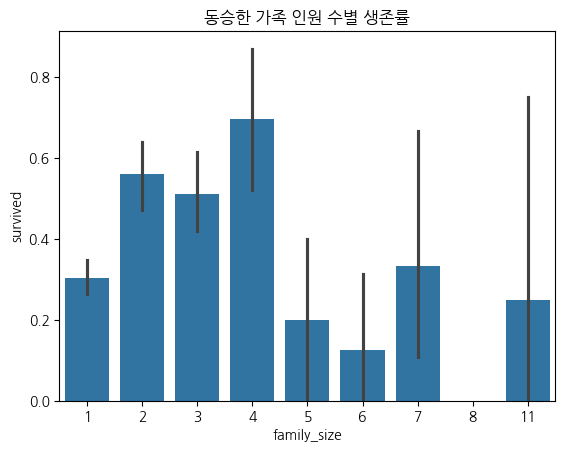

In [730]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [731]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  
914             14.147372            1         1  
805             25.140418            7         0  
255             25.140418            3         0  
769             14.147372            1         1  
527             25.140418            1         1

#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [732]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  
914             14.147372            1         1          0  
805             25.140418            7         0          0  
255             25.140418            3         0          0  
769             14.147372            1         1          0  
527             25.140418            1         1          0

### Data Cleaning

In [733]:
train.isnull().sum().sort_values(ascending=False)

cabin                   580
age                     135
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_embarked      0
avg_fare_by_pclass        0
avg_age_by_embarked       0
avg_age_by_pclass         0
embarked                  0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [734]:
test.isnull().sum().sort_values(ascending=False)

cabin                   138
age                      45
avg_fare_by_embarked      1
avg_age_by_embarked       1
embarked                  1
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [735]:
ori_te.isnull().sum().sort_values(ascending=False)

cabin                   296
age                      83
embarked                  1
avg_fare_by_embarked      1
avg_age_by_embarked       1
fare                      1
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
passengerid               0
pclass                    0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
has_cabin                 0
dtype: int64

In [736]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [737]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

<ipython-input-737-f53c0921e2eb>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-737-f53c0921e2eb>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [738]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [739]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [740]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [741]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

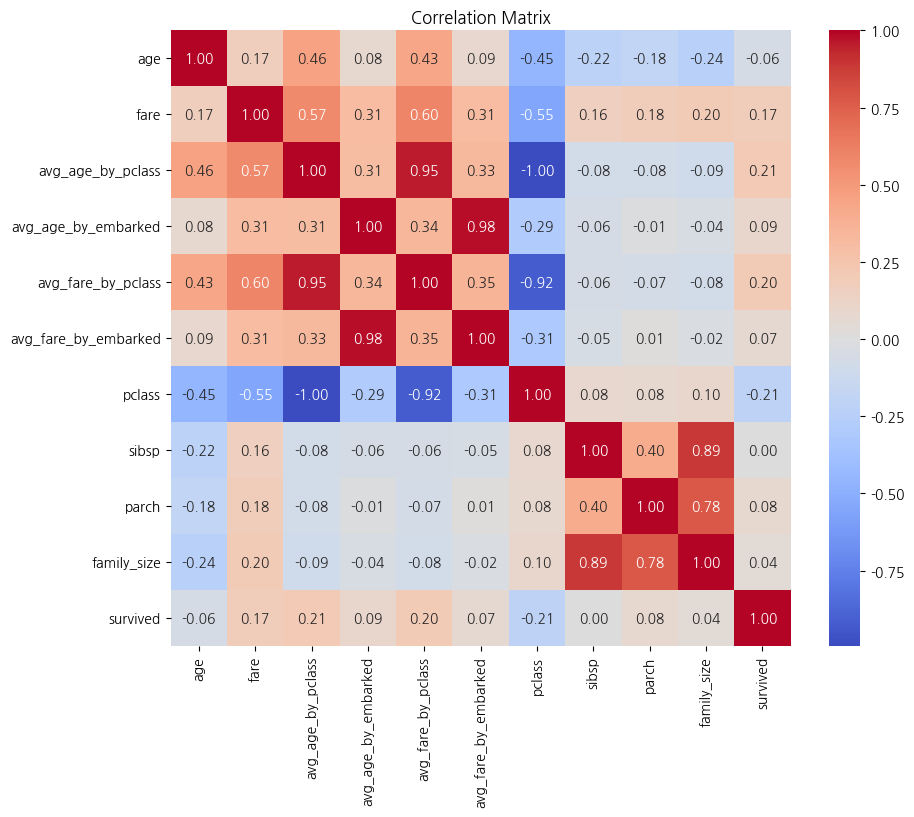

In [742]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

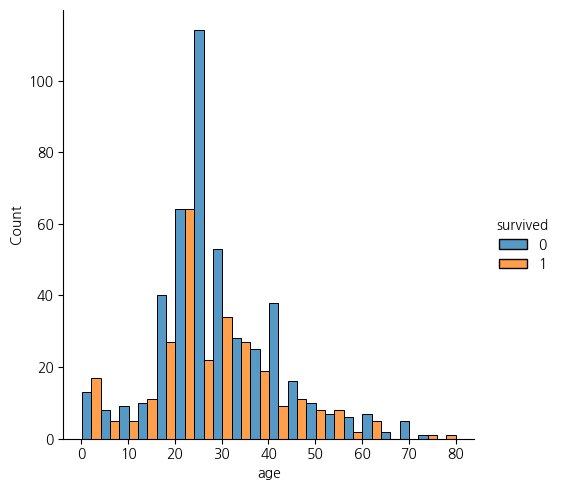

In [743]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [744]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [745]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [746]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

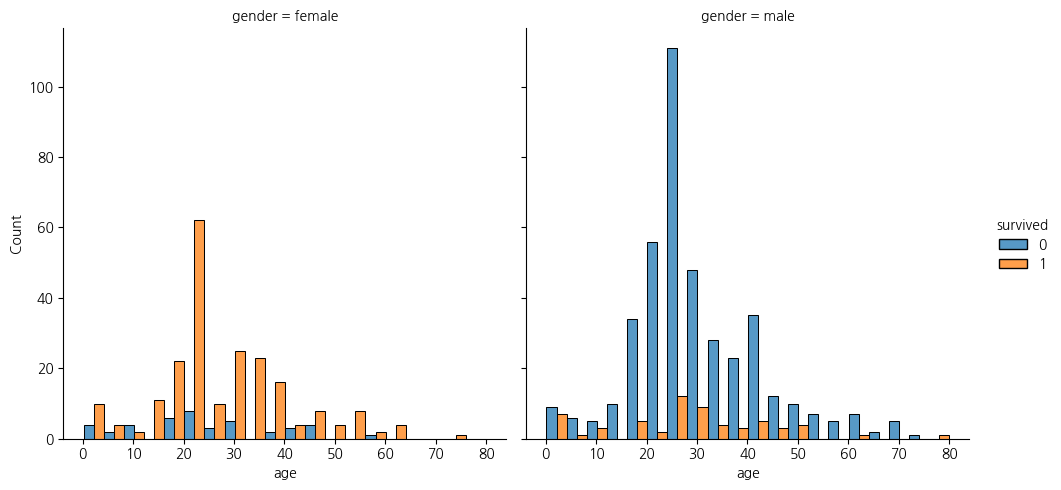

In [747]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [748]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


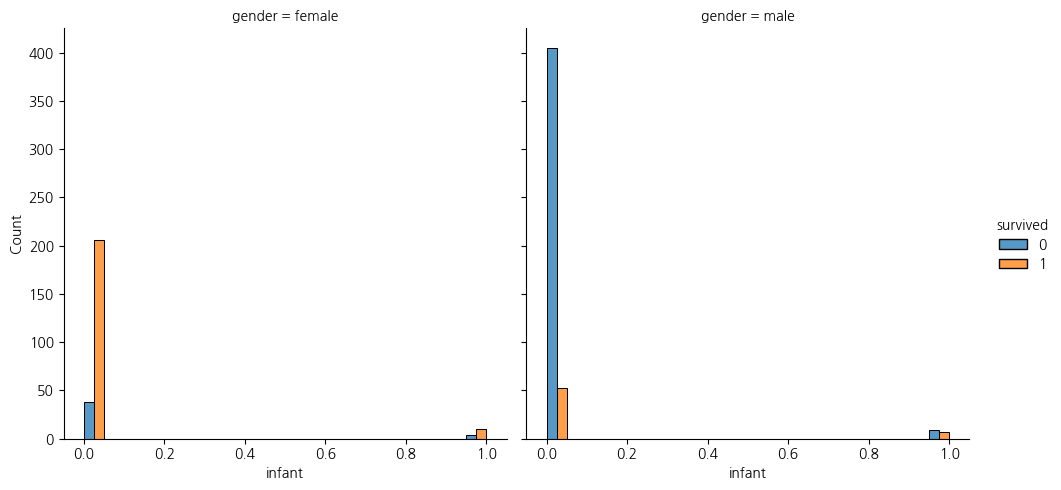

In [749]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [750]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant  
914      female_0  
805      female_0  
255      female_1  
769        male_0  
527        male_0

##### pclass & gender

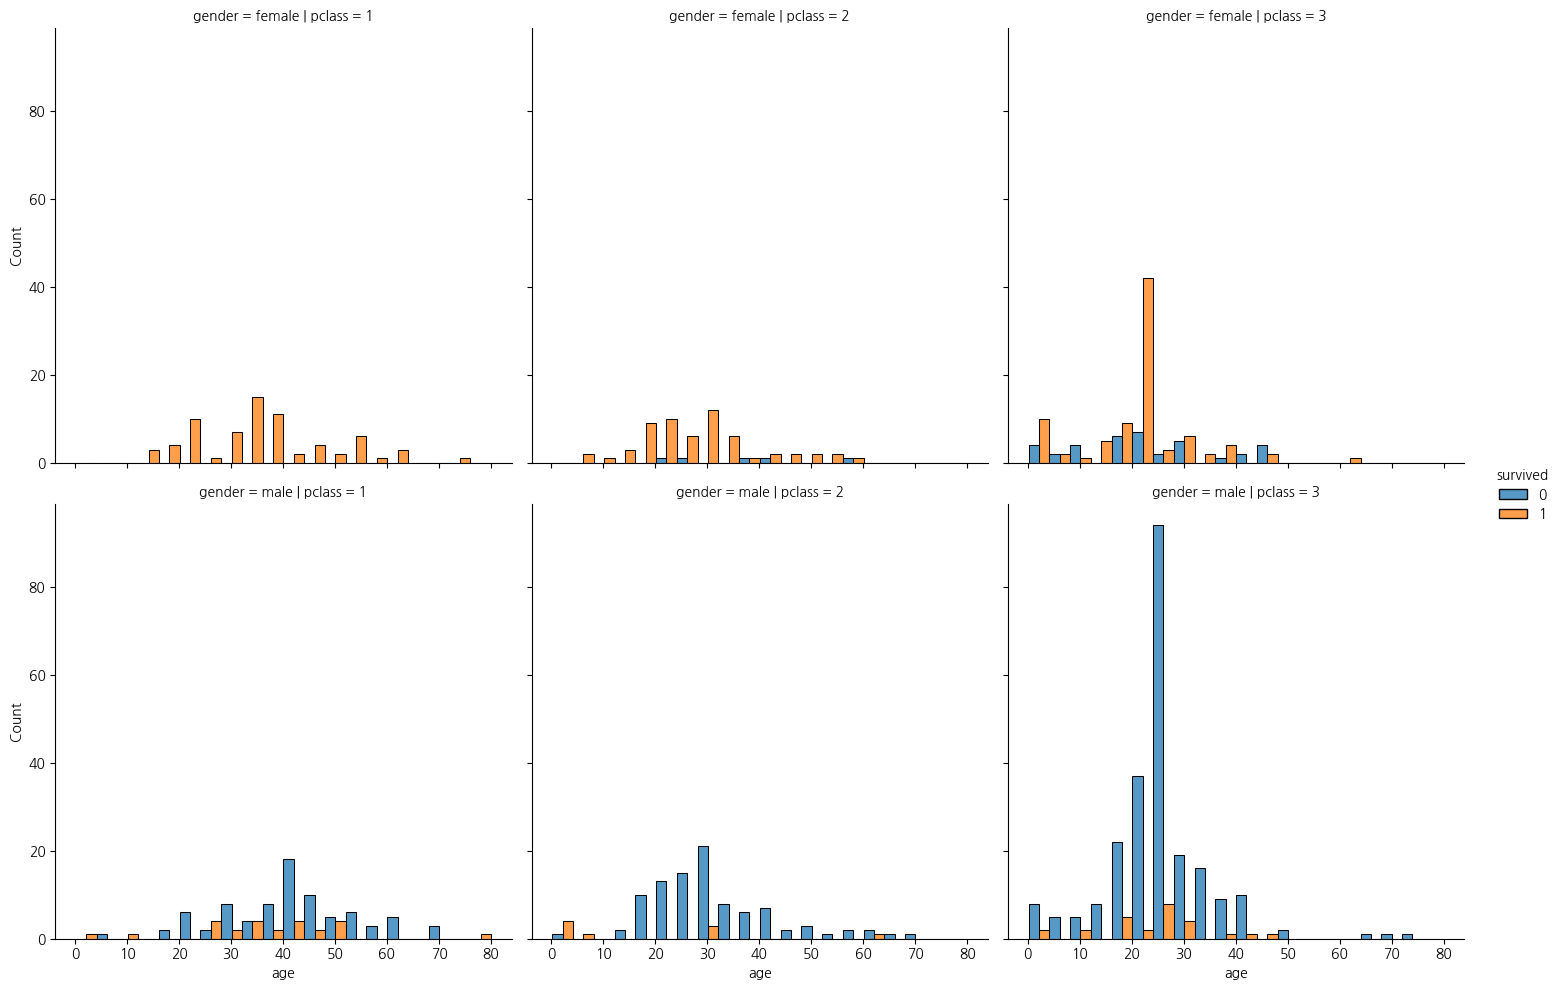

In [751]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [752]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [753]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [754]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [755]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

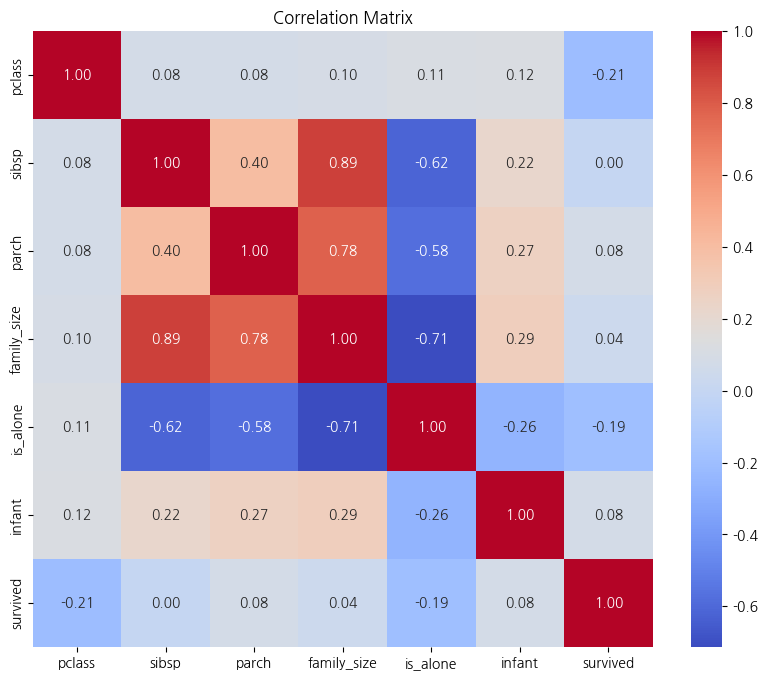

In [756]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [757]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant gender_pclass infant_pclass  
914      female_0      female_3           0_3  
805      female_0      female_3           0_3  
255      female_1      female_3           1_3  
769        male_0        male_3           0_3  
527        male_0        male_3           0_3

##### infant & family_size

In [758]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_pclass  \
914        Q          24.095018  ...            13.55176   
805        S          24.095018  ...            13.55176   
255        S          24.095018  ...            13.55176   
769        Q          24.095018  ...            13.55176   
527        S          24.095018  ...            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

     gender_infant gender_pclass infant_pclass infant_family_size  
914       female_0      female_3           0_3                0_1  
805       female_0      female_3           0_3                0_7  
255       female_1      female_3           1_3                1_3  
769         male_0        male_3           0_3                0_1  
527         male_0        male_3           0_3                0_1  

[5 rows x 21 columns]

##### pclass & is_alone

In [759]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_embarked  family_size  \
914        Q          24.095018  ...             14.147372            1   
805        S          24.095018  ...             25.140418            7   
255        S          24.095018  ...             25.140418            3   
769        Q          24.095018  ...             14.147372            1   
527        S          24.095018  ...             25.140418            1   

     is_alone  has_cabin  infant  gender_infant  gender_pclass infant_pclass  \
914         1          0       0       female_0       female_3           0_3   
805         0          0       0       female_0       female_3           0_3   
255         0          0       1       female_1       female_3           1_3   
769         1          0       0         male_0         male_3           0_3   
527         1          0       0         male_0         male_3           0_3   

    infant_family_size pclass_is_alone  
914                0_1             3_1  
805                0_7             3_0  
255                1_3             3_0  
769                0_1             3_1  
527                0_1             3_1  

[5 rows x 22 columns]

##### pclass_family_size

In [760]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  family_size  is_alone  has_cabin  \
914        Q          24.095018  ...            1         1          0   
805        S          24.095018  ...            7         0          0   
255        S          24.095018  ...            3         0          0   
769        Q          24.095018  ...            1         1          0   
527        S          24.095018  ...            1         1          0   

     infant  gender_infant  gender_pclass  infant_pclass infant_family_size  \
914       0       female_0       female_3            0_3                0_1   
805       0       female_0       female_3            0_3                0_7   
255       1       female_1       female_3            1_3                1_3   
769       0         male_0         male_3            0_3                0_1   
527       0         male_0         male_3            0_3                0_1   

    pclass_is_alone pclass_family_size  
914             3_1                3_1  
805             3_0                3_7  
255             3_0                3_3  
769             3_1                3_1  
527             3_1                3_1  

[5 rows x 23 columns]

In [761]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [762]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [763]:
scaling_cols = ['age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
                'avg_fare_by_embarked', 'family_size']
scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[scaling_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaling_cols)
# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(scaling_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[scaling_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=scaling_cols)
# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(scaling_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[scaling_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=scaling_cols)
# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(scaling_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding

In [764]:
train.columns, len(train.columns)

(Index(['survived', 'is_alone', 'infant_pclass', 'infant', 'has_cabin',
        'gender_infant', 'passengerid', 'infant_family_size', 'sibsp', 'gender',
        'gender_pclass', 'pclass', 'embarked', 'pclass_is_alone', 'parch',
        'pclass_family_size', 'age', 'fare', 'avg_age_by_pclass',
        'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
        'family_size'],
       dtype='object'),
 23)

In [765]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   survived              732 non-null    int64  
 1   is_alone              732 non-null    int64  
 2   infant_pclass         732 non-null    object 
 3   infant                732 non-null    int64  
 4   has_cabin             732 non-null    int64  
 5   gender_infant         732 non-null    object 
 6   passengerid           732 non-null    int64  
 7   infant_family_size    732 non-null    object 
 8   sibsp                 732 non-null    int64  
 9   gender                732 non-null    object 
 10  gender_pclass         732 non-null    object 
 11  pclass                732 non-null    int64  
 12  embarked              732 non-null    object 
 13  pclass_is_alone       732 non-null    object 
 14  parch                 732 non-null    int64  
 15  pclass_family_size    7

In [766]:
train.select_dtypes(include=np.number)

survived  is_alone  infant  has_cabin  passengerid  sibsp  pclass  parch  \
0           1         1       0          0          914      0       3      0   
1           0         0       0          0          805      4       3      2   
2           1         0       1          0          255      1       3      1   
3           0         1       0          0          769      0       3      0   
4           0         1       0          0          527      0       3      0   
..        ...       ...     ...        ...          ...    ...     ...    ...   
727         1         0       1          0          403      0       3      2   
728         0         1       0          0          824      0       3      0   
729         0         0       0          0          879      0       3      2   
730         0         1       0          1          214      0       1      0   
731         0         0       0          1          636      1       1      1   

          age      fare  avg_age_by_pclass  avg_age_by_embarked  \
0   -0.573408 -0.514795          -0.817102            -0.614033   
1   -1.727349  0.012145          -0.817102            -0.484440   
2   -2.101644 -0.415190          -0.817102            -0.484440   
3    3.101048 -0.514421          -0.817102            -0.614033   
4    0.443558 -0.528411          -0.817102            -0.484440   
..        ...       ...                ...                  ...   
727 -2.101644 -0.335541          -0.817102             2.002093   
728  0.368699 -0.507706          -0.817102            -0.484440   
729 -1.427914 -0.147336          -0.817102            -0.484440   
730 -0.379890  1.084863           1.629847             2.002093   
731  3.063619  0.901320           1.629847            -0.484440   

     avg_fare_by_pclass  avg_fare_by_embarked  family_size  
0             -0.638555             -1.185388    -0.566752  
1             -0.638555             -0.399678     3.415925  
2             -0.638555             -0.399678     0.760807  
3             -0.638555             -1.185388    -0.566752  
4             -0.638555             -0.399678    -0.566752  
..                  ...                   ...          ...  
727           -0.638555              1.953991     0.760807  
728           -0.638555             -0.399678    -0.566752  
729           -0.638555             -0.399678     0.760807  
730            1.767622              1.953991    -0.566752  
731            1.767622             -0.399678     0.760807  

[732 rows x 15 columns]

In [767]:
train.select_dtypes(exclude=np.number)

infant_pclass gender_infant infant_family_size  gender gender_pclass  \
0             0_3      female_0                0_1  female      female_3   
1             0_3      female_0                0_7  female      female_3   
2             1_3      female_1                1_3  female      female_3   
3             0_3        male_0                0_1    male        male_3   
4             0_3        male_0                0_1    male        male_3   
..            ...           ...                ...     ...           ...   
727           1_3      female_1                1_3  female      female_3   
728           0_3        male_0                0_1    male        male_3   
729           0_3      female_0                0_3  female      female_3   
730           0_1        male_0                0_1    male        male_1   
731           0_1        male_0                0_3    male        male_1   

    embarked pclass_is_alone pclass_family_size  
0          Q             3_1                3_1  
1          S             3_0                3_7  
2          S             3_0                3_3  
3          Q             3_1                3_1  
4          S             3_1                3_1  
..       ...             ...                ...  
727        C             3_0                3_3  
728        S             3_1                3_1  
729        S             3_0                3_3  
730        C             1_1                1_1  
731        S             1_0                1_3  

[732 rows x 8 columns]

In [768]:
train.columns, len(train.columns)

(Index(['survived', 'is_alone', 'infant_pclass', 'infant', 'has_cabin',
        'gender_infant', 'passengerid', 'infant_family_size', 'sibsp', 'gender',
        'gender_pclass', 'pclass', 'embarked', 'pclass_is_alone', 'parch',
        'pclass_family_size', 'age', 'fare', 'avg_age_by_pclass',
        'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
        'family_size'],
       dtype='object'),
 23)

In [769]:
# 범주형 컬럼들
enc_cols = ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender',
            'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin']

# 수치형 컬럼들
normal_cols = list(set(train.columns) - set(enc_cols))

print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")


범주형 컬럼들 : ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender', 'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin'] / 수치형 컬럼들 : ['survived', 'is_alone', 'fare', 'infant', 'avg_fare_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'passengerid', 'sibsp', 'age', 'family_size', 'parch', 'avg_age_by_pclass']
범주형 컬럼들 개수: 10 / 수치형 컬럼들 개수 : 13


In [770]:
reset_seeds()
print(f'before: {train.shape}, {test.shape}, {ori_te.shape}')

encoder = OneHotEncoder(handle_unknown='ignore')
enc_dfs = []

for df in [train, test, ori_te]:
    if df is train:
        encoded = encoder.fit_transform(df[enc_cols])
    else:
        encoded = encoder.transform(df[enc_cols])

    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

    not_enc_cols = list(set(df.columns) - set(enc_cols))
    enc_dfs.append(pd.concat([df[not_enc_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1))

# 원본 train, test, ori_te를 변환된 데이터프레임으로 덮어쓰기
train, test, ori_te = enc_dfs

# 결과 출력
print(f'after: {train.shape}, {test.shape}, {ori_te.shape}')
train.head()

before: (732, 23), (184, 23), (393, 22)
after: (732, 82), (184, 82), (393, 81)


survived  is_alone      fare  infant  avg_fare_by_pclass  \
0         1         1 -0.514795       0           -0.638555   
1         0         0  0.012145       0           -0.638555   
2         1         0 -0.415190       1           -0.638555   
3         0         1 -0.514421       0           -0.638555   
4         0         1 -0.528411       0           -0.638555   

   avg_age_by_embarked  avg_fare_by_embarked  passengerid  sibsp       age  \
0            -0.614033             -1.185388          914      0 -0.573408   
1            -0.484440             -0.399678          805      4 -1.727349   
2            -0.484440             -0.399678          255      1 -2.101644   
3            -0.614033             -1.185388          769      0  3.101048   
4            -0.484440             -0.399678          527      0  0.443558   

   ...  gender_pclass_male_2  gender_pclass_male_3  pclass_is_alone_1_0  \
0  ...                   0.0                   0.0                  0.0   
1  ...                   0.0                   0.0                  0.0   
2  ...                   0.0                   0.0                  0.0   
3  ...                   0.0                   1.0                  0.0   
4  ...                   0.0                   1.0                  0.0   

   pclass_is_alone_1_1  pclass_is_alone_2_0  pclass_is_alone_2_1  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   pclass_is_alone_3_0  pclass_is_alone_3_1  has_cabin_0  has_cabin_1  
0                  0.0                  1.0          1.0          0.0  
1                  1.0                  0.0          1.0          0.0  
2                  1.0                  0.0          1.0          0.0  
3                  0.0                  1.0          1.0          0.0  
4                  0.0                  1.0          1.0          0.0  

[5 rows x 82 columns]

## Training

In [771]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [772]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 81), (732,), (184, 81), (184,))

In [773]:
# reset_seeds()
# model_name = 'model_lgb_V0'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V0 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V0, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [774]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [775]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [776]:
reset_seeds()
model_name = 'model_lgb_V0'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V0 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V0.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [777]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V0.score(X_tr, y_tr)
# - Test data
score_te_lgb = model_lgb_V0.score(X_te, y_te)

print(f'{model_lgb_V0} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8674863387978142, 0.8641304347826086


### AUC 점수

In [778]:
y_pred = model_lgb_V0.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V0}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9195488721804511


### 혼동행렬

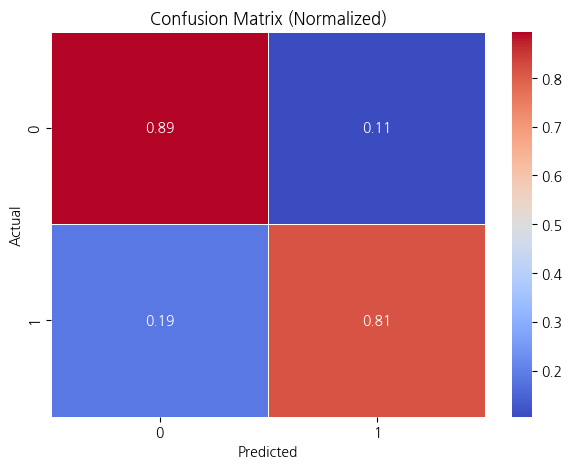

In [779]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측 (클래스 레이블 반환)
y_pred_class = model_lgb_V0.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [780]:
ori_te_pred = model_lgb_V0.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [781]:
df_feature_importances = pd.DataFrame(model_lgb_V0.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(81, 2)


index     0
0              passengerid  1084
1                     fare  1084
2                      age   751
3       avg_fare_by_pclass   382
4      pclass_is_alone_3_0   263
5              has_cabin_0   231
6        avg_age_by_pclass   210
7     gender_infant_male_0   206
8            gender_female   198
9               embarked_S   157
10             has_cabin_1   125
11                is_alone   120
12             gender_male    86
13  pclass_family_size_3_1    82
14                   parch    79
15             family_size    71
16       infant_pclass_0_2    53
17                pclass_1    48
18                pclass_2    47
19     pclass_is_alone_3_1    45

### 결과 정리

In [782]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [783]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

model                                         parameters  score_tr  \
0  model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...  0.867486   

   score_te    auc_te                                        ori_te_pred  \
0   0.86413  0.919549  [0.7406200868968245, 0.7395791515530487, 0.742...   

   len_features                                 feaute_importances  \
0            81  [passengerid, fare, age, avg_fare_by_pclass, p...   

             create_dt  score_diff  auc_diff  total_diff  
0  2025-02-12 22:06:47    0.003356  0.055418    0.058774

#### 중요도 기준 상위 특성 선택

<ipython-input-784-49cae52706ab>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')


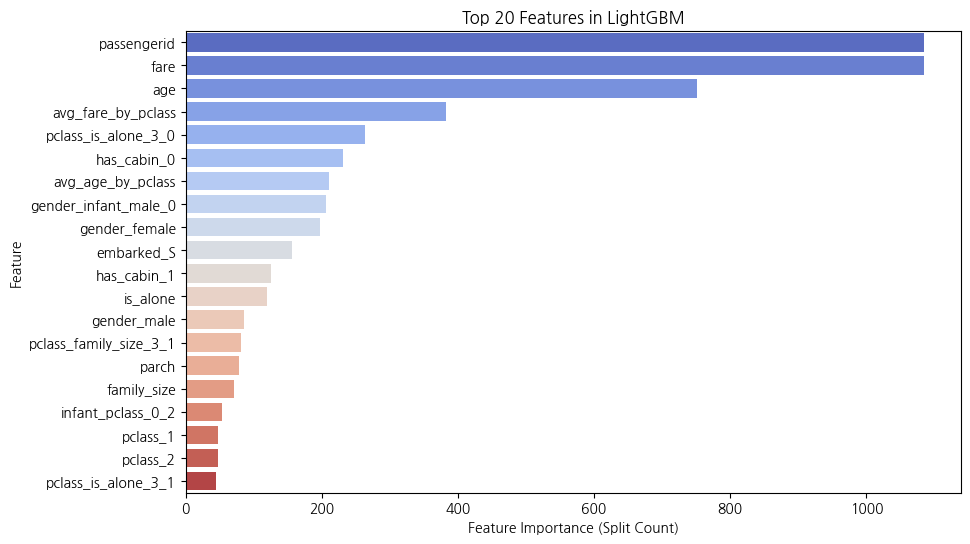

In [784]:
# 상위 20개 특성만 시각화
top_features = df_feature_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')
plt.xlabel("Feature Importance (Split Count)")
plt.ylabel("Feature")
plt.title("Top 20 Features in LightGBM")
plt.show()

In [785]:
top_n = 10
high_importance_features = list(df_feature_importances.head(top_n)['index'])

print(f"선택된 중요 특성: {high_importance_features}")
print(f"선택된 특성 개수: {len(high_importance_features)}")

선택된 중요 특성: ['passengerid', 'fare', 'age', 'avg_fare_by_pclass', 'pclass_is_alone_3_0', 'has_cabin_0', 'avg_age_by_pclass', 'gender_infant_male_0', 'gender_female', 'embarked_S']
선택된 특성 개수: 10


#### 중요도 기준 상위 특성들로 훈련 / 테스트

In [786]:
reset_seeds()

# 선택된 특성만 사용하여 데이터 구성
X_tr_selected = X_tr[high_importance_features]
X_te_selected = X_te[high_importance_features]
ori_te_selected = ori_te[high_importance_features]

model_name = 'model_lgb_V0_high'

# 새로운 모델 학습
reset_seeds()
model_lgb_V0_high = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# 훈련
model_lgb_V0_high.fit(X_tr_selected, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

In [787]:
reset_seeds()

# 평가
score_tr_lgb = model_lgb_V0_high.score(X_tr_selected, y_tr)
score_te_lgb = model_lgb_V0_high.score(X_te_selected, y_te)
print(f"훈련 점수: {score_tr_lgb}, 테스트 점수: {score_te_lgb}")

훈련 점수: 0.8797814207650273, 테스트 점수: 0.8586956521739131


In [788]:
reset_seeds()

# AUC 계산
y_pred_high = model_lgb_V0_high.predict_proba(X_te_selected)[:, 1]
fpr_high, tpr_high, thresholds_high = roc_curve(y_te, y_pred_high)
auc_te_high = auc(fpr_high, tpr_high)
print(f'{model_lgb_V0_high}: {auc_te_high}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9165413533834587


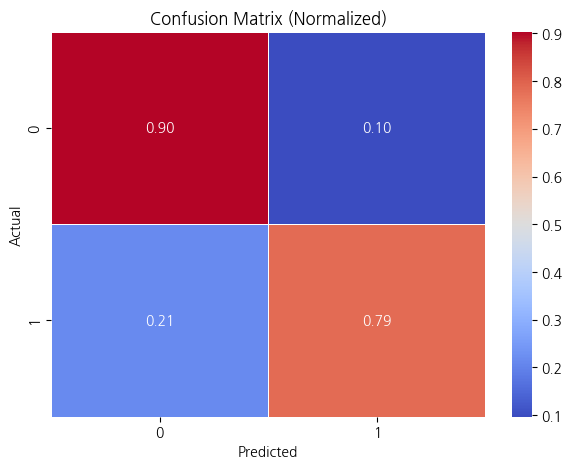

In [789]:
# 혼동행렬 시각화
y_pred_class_high = model_lgb_V0_high.predict(X_te_selected)
norm_conf_mx_high = confusion_matrix(y_te, y_pred_class_high, normalize="true")

plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx_high, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [790]:
ori_te_pred = model_lgb_V0_high.predict_proba(ori_te_selected)[:,1]
ori_te_pred.shape

(393,)

#### 중요도 기준 상위 특성으로 훈련하고 검증한 결과 정리

In [791]:
args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [792]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

model                                         parameters  \
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
0  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   

                                         ori_te_pred  len_features  \
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   

                                  feaute_importances            create_dt  
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47

# model_lgbm_V1 (random search 진행)

## Train & Test Split

In [793]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [794]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [795]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [796]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [797]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [798]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [799]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  
914          24.095018  
805          24.095018  
255          24.095018  
769          24.095018  
527          24.095018

#### embarked별 평균 나이

In [800]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  
914          24.095018            28.948276  
805          24.095018            29.068433  
255          24.095018            29.068433  
769          24.095018            28.948276  
527          24.095018            29.068433

#### pclass별 평균 요금

In [801]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  
914          24.095018            28.948276            13.55176  
805          24.095018            29.068433            13.55176  
255          24.095018            29.068433            13.55176  
769          24.095018            28.948276            13.55176  
527          24.095018            29.068433            13.55176

#### embarked별 평균 요금

In [802]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  
914             14.147372  
805             25.140418  
255             25.140418  
769             14.147372  
527             25.140418

#### 동승한 가족 인원수 컬럼 추가

In [803]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  
914             14.147372            1  
805             25.140418            7  
255             25.140418            3  
769             14.147372            1  
527             25.140418            1

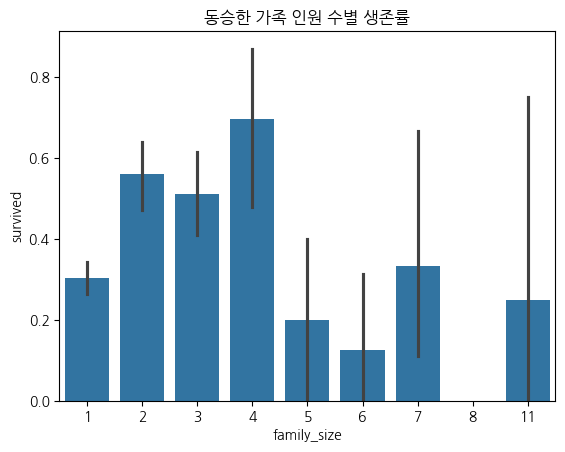

In [804]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [805]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  
914             14.147372            1         1  
805             25.140418            7         0  
255             25.140418            3         0  
769             14.147372            1         1  
527             25.140418            1         1

#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [806]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  
914             14.147372            1         1          0  
805             25.140418            7         0          0  
255             25.140418            3         0          0  
769             14.147372            1         1          0  
527             25.140418            1         1          0

### Data Cleaning

In [807]:
train.isnull().sum().sort_values(ascending=False)

cabin                   580
age                     135
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_embarked      0
avg_fare_by_pclass        0
avg_age_by_embarked       0
avg_age_by_pclass         0
embarked                  0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [808]:
test.isnull().sum().sort_values(ascending=False)

cabin                   138
age                      45
avg_fare_by_embarked      1
avg_age_by_embarked       1
embarked                  1
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [809]:
ori_te.isnull().sum().sort_values(ascending=False)

cabin                   296
age                      83
embarked                  1
avg_fare_by_embarked      1
avg_age_by_embarked       1
fare                      1
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
passengerid               0
pclass                    0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
has_cabin                 0
dtype: int64

In [810]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [811]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-811-e249aeb7e77b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-811-e249aeb7e77b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [812]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [813]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [814]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [815]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

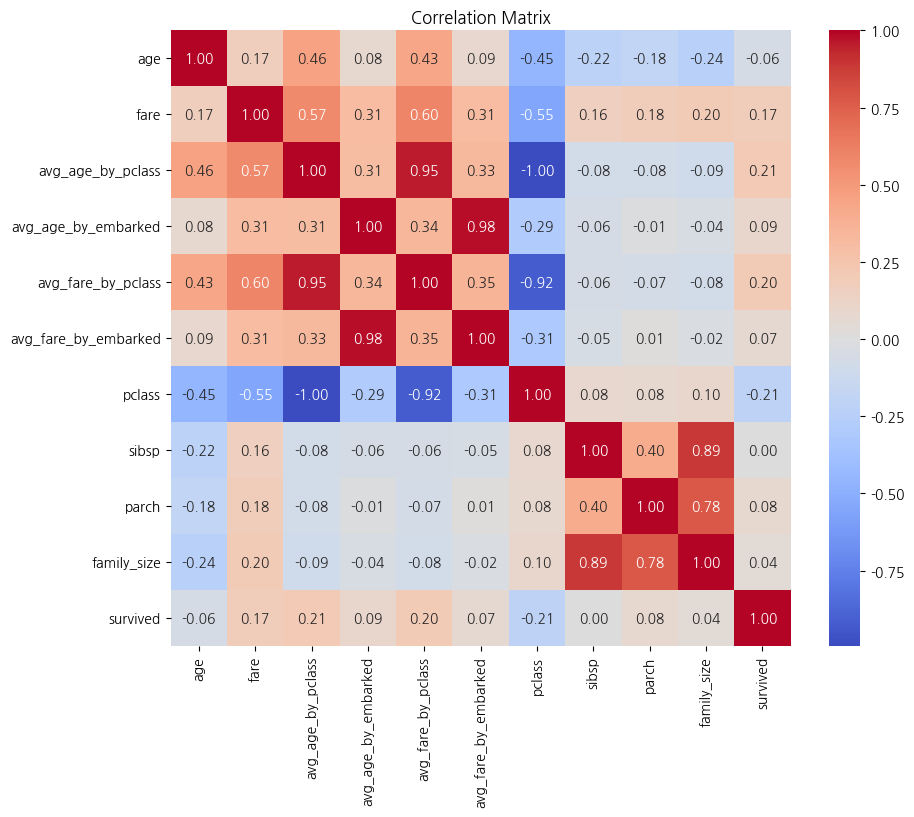

In [816]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

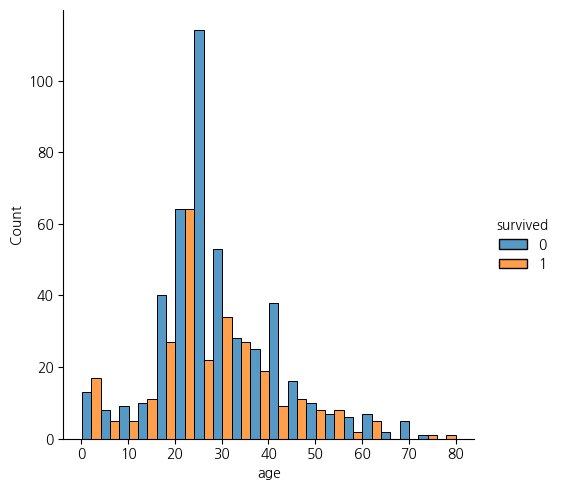

In [817]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [818]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [819]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [820]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

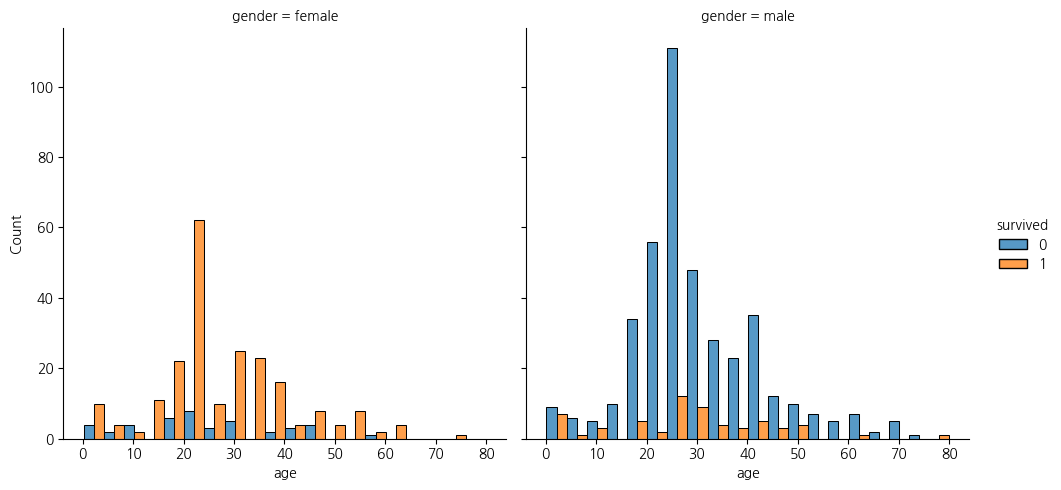

In [821]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [822]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


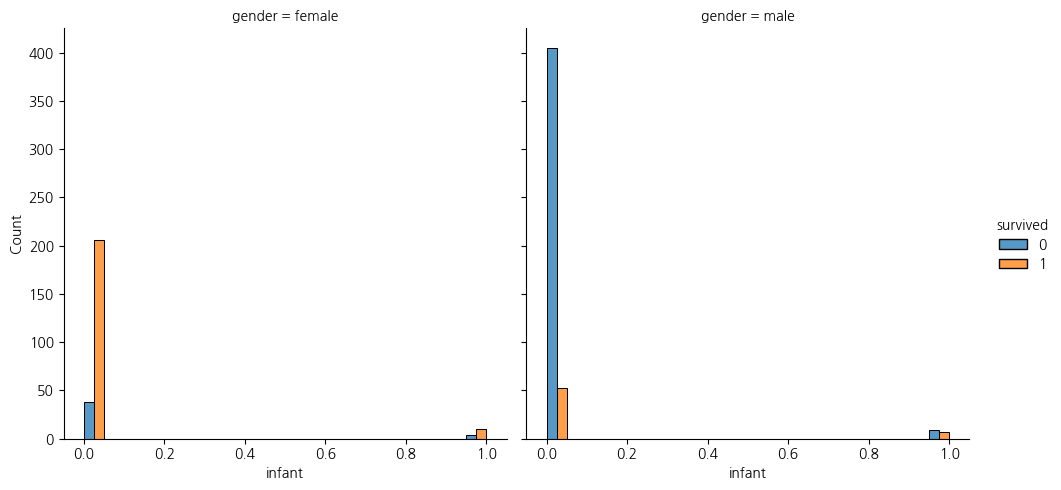

In [823]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [824]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant  
914      female_0  
805      female_0  
255      female_1  
769        male_0  
527        male_0

##### pclass & gender

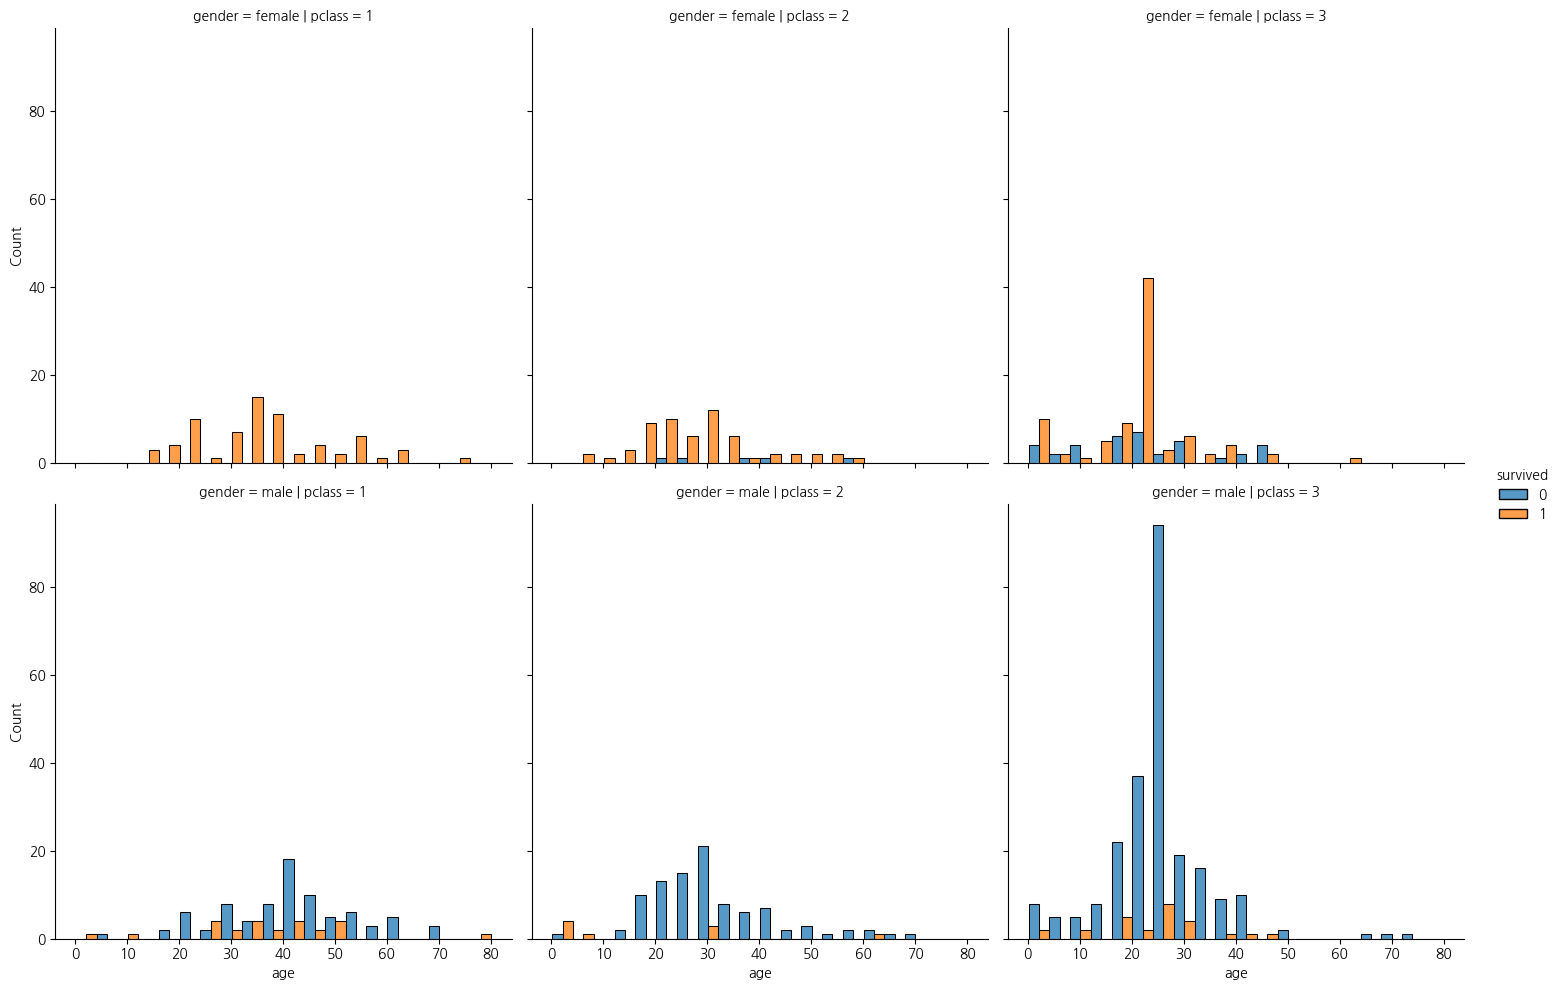

In [825]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [826]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [827]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [828]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [829]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

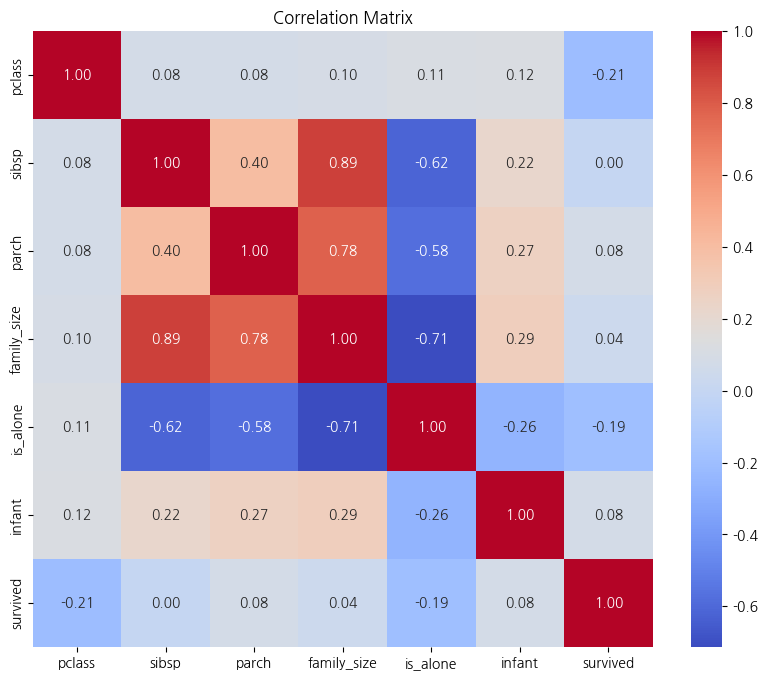

In [830]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [831]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant gender_pclass infant_pclass  
914      female_0      female_3           0_3  
805      female_0      female_3           0_3  
255      female_1      female_3           1_3  
769        male_0        male_3           0_3  
527        male_0        male_3           0_3

##### infant & family_size

In [832]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_pclass  \
914        Q          24.095018  ...            13.55176   
805        S          24.095018  ...            13.55176   
255        S          24.095018  ...            13.55176   
769        Q          24.095018  ...            13.55176   
527        S          24.095018  ...            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

     gender_infant gender_pclass infant_pclass infant_family_size  
914       female_0      female_3           0_3                0_1  
805       female_0      female_3           0_3                0_7  
255       female_1      female_3           1_3                1_3  
769         male_0        male_3           0_3                0_1  
527         male_0        male_3           0_3                0_1  

[5 rows x 21 columns]

##### pclass & is_alone

In [833]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_embarked  family_size  \
914        Q          24.095018  ...             14.147372            1   
805        S          24.095018  ...             25.140418            7   
255        S          24.095018  ...             25.140418            3   
769        Q          24.095018  ...             14.147372            1   
527        S          24.095018  ...             25.140418            1   

     is_alone  has_cabin  infant  gender_infant  gender_pclass infant_pclass  \
914         1          0       0       female_0       female_3           0_3   
805         0          0       0       female_0       female_3           0_3   
255         0          0       1       female_1       female_3           1_3   
769         1          0       0         male_0         male_3           0_3   
527         1          0       0         male_0         male_3           0_3   

    infant_family_size pclass_is_alone  
914                0_1             3_1  
805                0_7             3_0  
255                1_3             3_0  
769                0_1             3_1  
527                0_1             3_1  

[5 rows x 22 columns]

##### pclass_family_size

In [834]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  family_size  is_alone  has_cabin  \
914        Q          24.095018  ...            1         1          0   
805        S          24.095018  ...            7         0          0   
255        S          24.095018  ...            3         0          0   
769        Q          24.095018  ...            1         1          0   
527        S          24.095018  ...            1         1          0   

     infant  gender_infant  gender_pclass  infant_pclass infant_family_size  \
914       0       female_0       female_3            0_3                0_1   
805       0       female_0       female_3            0_3                0_7   
255       1       female_1       female_3            1_3                1_3   
769       0         male_0         male_3            0_3                0_1   
527       0         male_0         male_3            0_3                0_1   

    pclass_is_alone pclass_family_size  
914             3_1                3_1  
805             3_0                3_7  
255             3_0                3_3  
769             3_1                3_1  
527             3_1                3_1  

[5 rows x 23 columns]

In [835]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Data Scaling

In [836]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23)

In [837]:
scaling_cols = ['age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass',
                'avg_fare_by_embarked', 'family_size']
scaler = StandardScaler()

# train 데이터프레임 스케일링
scaled_train = scaler.fit_transform(train[scaling_cols])
scaled_train_df = pd.DataFrame(scaled_train, columns=scaling_cols)
# train의 스케일링되지 않은 컬럼
not_scaling_cols_train = list(set(train.columns) - set(scaling_cols))
train = pd.concat(
    [train[not_scaling_cols_train].reset_index(drop=True), scaled_train_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# test 데이터프레임 스케일링
scaled_test = scaler.transform(test[scaling_cols])
scaled_test_df = pd.DataFrame(scaled_test, columns=scaling_cols)
# test의 스케일링되지 않은 컬럼
not_scaling_cols_test = list(set(test.columns) - set(scaling_cols))
test = pd.concat(
    [test[not_scaling_cols_test].reset_index(drop=True), scaled_test_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# ori_te 데이터프레임 스케일링
scaled_ori_te = scaler.transform(ori_te[scaling_cols])
scaled_ori_te_df = pd.DataFrame(scaled_ori_te, columns=scaling_cols)
# ori_te의 스케일링되지 않은 컬럼
not_scaling_cols_ori_te = list(set(ori_te.columns) - set(scaling_cols))
ori_te = pd.concat(
    [ori_te[not_scaling_cols_ori_te].reset_index(drop=True), scaled_ori_te_df.reset_index(drop=True)],
    axis=1
).reset_index(drop=True)

# 결측치 확인 및 결과 확인
print(f'{train.isnull().sum().sum()}, {test.isnull().sum().sum()}, {ori_te.isnull().sum().sum()}')
train.shape, test.shape, ori_te.shape

0, 0, 0


((732, 23), (184, 23), (393, 22))

### Data Encoding

In [838]:
train.columns, len(train.columns)

(Index(['survived', 'is_alone', 'infant_pclass', 'infant', 'has_cabin',
        'gender_infant', 'passengerid', 'infant_family_size', 'sibsp', 'gender',
        'gender_pclass', 'pclass', 'embarked', 'pclass_is_alone', 'parch',
        'pclass_family_size', 'age', 'fare', 'avg_age_by_pclass',
        'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
        'family_size'],
       dtype='object'),
 23)

In [839]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   survived              732 non-null    int64  
 1   is_alone              732 non-null    int64  
 2   infant_pclass         732 non-null    object 
 3   infant                732 non-null    int64  
 4   has_cabin             732 non-null    int64  
 5   gender_infant         732 non-null    object 
 6   passengerid           732 non-null    int64  
 7   infant_family_size    732 non-null    object 
 8   sibsp                 732 non-null    int64  
 9   gender                732 non-null    object 
 10  gender_pclass         732 non-null    object 
 11  pclass                732 non-null    int64  
 12  embarked              732 non-null    object 
 13  pclass_is_alone       732 non-null    object 
 14  parch                 732 non-null    int64  
 15  pclass_family_size    7

In [840]:
train.select_dtypes(include=np.number)

survived  is_alone  infant  has_cabin  passengerid  sibsp  pclass  parch  \
0           1         1       0          0          914      0       3      0   
1           0         0       0          0          805      4       3      2   
2           1         0       1          0          255      1       3      1   
3           0         1       0          0          769      0       3      0   
4           0         1       0          0          527      0       3      0   
..        ...       ...     ...        ...          ...    ...     ...    ...   
727         1         0       1          0          403      0       3      2   
728         0         1       0          0          824      0       3      0   
729         0         0       0          0          879      0       3      2   
730         0         1       0          1          214      0       1      0   
731         0         0       0          1          636      1       1      1   

          age      fare  avg_age_by_pclass  avg_age_by_embarked  \
0   -0.573408 -0.514795          -0.817102            -0.614033   
1   -1.727349  0.012145          -0.817102            -0.484440   
2   -2.101644 -0.415190          -0.817102            -0.484440   
3    3.101048 -0.514421          -0.817102            -0.614033   
4    0.443558 -0.528411          -0.817102            -0.484440   
..        ...       ...                ...                  ...   
727 -2.101644 -0.335541          -0.817102             2.002093   
728  0.368699 -0.507706          -0.817102            -0.484440   
729 -1.427914 -0.147336          -0.817102            -0.484440   
730 -0.379890  1.084863           1.629847             2.002093   
731  3.063619  0.901320           1.629847            -0.484440   

     avg_fare_by_pclass  avg_fare_by_embarked  family_size  
0             -0.638555             -1.185388    -0.566752  
1             -0.638555             -0.399678     3.415925  
2             -0.638555             -0.399678     0.760807  
3             -0.638555             -1.185388    -0.566752  
4             -0.638555             -0.399678    -0.566752  
..                  ...                   ...          ...  
727           -0.638555              1.953991     0.760807  
728           -0.638555             -0.399678    -0.566752  
729           -0.638555             -0.399678     0.760807  
730            1.767622              1.953991    -0.566752  
731            1.767622             -0.399678     0.760807  

[732 rows x 15 columns]

In [841]:
train.select_dtypes(exclude=np.number)

infant_pclass gender_infant infant_family_size  gender gender_pclass  \
0             0_3      female_0                0_1  female      female_3   
1             0_3      female_0                0_7  female      female_3   
2             1_3      female_1                1_3  female      female_3   
3             0_3        male_0                0_1    male        male_3   
4             0_3        male_0                0_1    male        male_3   
..            ...           ...                ...     ...           ...   
727           1_3      female_1                1_3  female      female_3   
728           0_3        male_0                0_1    male        male_3   
729           0_3      female_0                0_3  female      female_3   
730           0_1        male_0                0_1    male        male_1   
731           0_1        male_0                0_3    male        male_1   

    embarked pclass_is_alone pclass_family_size  
0          Q             3_1                3_1  
1          S             3_0                3_7  
2          S             3_0                3_3  
3          Q             3_1                3_1  
4          S             3_1                3_1  
..       ...             ...                ...  
727        C             3_0                3_3  
728        S             3_1                3_1  
729        S             3_0                3_3  
730        C             1_1                1_1  
731        S             1_0                1_3  

[732 rows x 8 columns]

In [842]:
train.columns, len(train.columns)

(Index(['survived', 'is_alone', 'infant_pclass', 'infant', 'has_cabin',
        'gender_infant', 'passengerid', 'infant_family_size', 'sibsp', 'gender',
        'gender_pclass', 'pclass', 'embarked', 'pclass_is_alone', 'parch',
        'pclass_family_size', 'age', 'fare', 'avg_age_by_pclass',
        'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
        'family_size'],
       dtype='object'),
 23)

In [843]:
# 범주형 컬럼들
enc_cols = ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender',
            'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin']

# 수치형 컬럼들
normal_cols = list(set(train.columns) - set(enc_cols))

print(f"범주형 컬럼들 : {enc_cols} / 수치형 컬럼들 : {normal_cols}")
print(f"범주형 컬럼들 개수: {len(enc_cols)} / 수치형 컬럼들 개수 : {len(normal_cols)}")


범주형 컬럼들 : ['pclass', 'gender_infant', 'pclass_family_size', 'infant_pclass', 'gender', 'infant_family_size', 'embarked', 'gender_pclass', 'pclass_is_alone', 'has_cabin'] / 수치형 컬럼들 : ['survived', 'is_alone', 'fare', 'infant', 'avg_fare_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_embarked', 'passengerid', 'sibsp', 'age', 'family_size', 'parch', 'avg_age_by_pclass']
범주형 컬럼들 개수: 10 / 수치형 컬럼들 개수 : 13


In [844]:
reset_seeds()
print(f'before: {train.shape}, {test.shape}, {ori_te.shape}')

encoder = OneHotEncoder(handle_unknown='ignore')
enc_dfs = []

for df in [train, test, ori_te]:
    if df is train:
        encoded = encoder.fit_transform(df[enc_cols])
    else:
        encoded = encoder.transform(df[enc_cols])

    encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())

    not_enc_cols = list(set(df.columns) - set(enc_cols))
    enc_dfs.append(pd.concat([df[not_enc_cols].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1))

# 원본 train, test, ori_te를 변환된 데이터프레임으로 덮어쓰기
train, test, ori_te = enc_dfs

# 결과 출력
print(f'after: {train.shape}, {test.shape}, {ori_te.shape}')
train.head()

before: (732, 23), (184, 23), (393, 22)
after: (732, 82), (184, 82), (393, 81)


survived  is_alone      fare  infant  avg_fare_by_pclass  \
0         1         1 -0.514795       0           -0.638555   
1         0         0  0.012145       0           -0.638555   
2         1         0 -0.415190       1           -0.638555   
3         0         1 -0.514421       0           -0.638555   
4         0         1 -0.528411       0           -0.638555   

   avg_age_by_embarked  avg_fare_by_embarked  passengerid  sibsp       age  \
0            -0.614033             -1.185388          914      0 -0.573408   
1            -0.484440             -0.399678          805      4 -1.727349   
2            -0.484440             -0.399678          255      1 -2.101644   
3            -0.614033             -1.185388          769      0  3.101048   
4            -0.484440             -0.399678          527      0  0.443558   

   ...  gender_pclass_male_2  gender_pclass_male_3  pclass_is_alone_1_0  \
0  ...                   0.0                   0.0                  0.0   
1  ...                   0.0                   0.0                  0.0   
2  ...                   0.0                   0.0                  0.0   
3  ...                   0.0                   1.0                  0.0   
4  ...                   0.0                   1.0                  0.0   

   pclass_is_alone_1_1  pclass_is_alone_2_0  pclass_is_alone_2_1  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   pclass_is_alone_3_0  pclass_is_alone_3_1  has_cabin_0  has_cabin_1  
0                  0.0                  1.0          1.0          0.0  
1                  1.0                  0.0          1.0          0.0  
2                  1.0                  0.0          1.0          0.0  
3                  0.0                  1.0          1.0          0.0  
4                  0.0                  1.0          1.0          0.0  

[5 rows x 82 columns]

## Training

In [845]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [846]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape

((732, 81), (732,), (184, 81), (184,))

In [847]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [848]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [849]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [850]:
reset_seeds()
model_name = 'model_lgb_V1'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V1 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V1.fit(X_tr, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 54
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [851]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V1.score(X_tr, y_tr)
# - Test data
score_te_lgb = model_lgb_V1.score(X_te, y_te)

print(f'{model_lgb_V0} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8674863387978142, 0.8641304347826086


### AUC 점수

In [852]:
y_pred = model_lgb_V1.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V1}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9195488721804511


### 혼동행렬

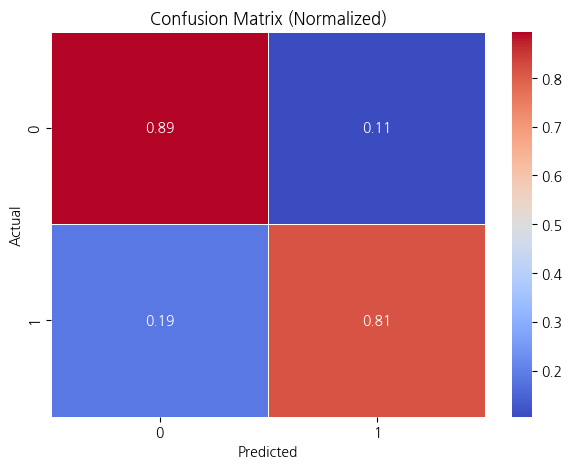

In [853]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측 (클래스 레이블 반환)
y_pred_class = model_lgb_V1.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [854]:
ori_te_pred = model_lgb_V1.predict_proba(ori_te)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [855]:
df_feature_importances = pd.DataFrame(model_lgb_V1.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(81, 2)


index     0
0              passengerid  1084
1                     fare  1084
2                      age   751
3       avg_fare_by_pclass   382
4      pclass_is_alone_3_0   263
5              has_cabin_0   231
6        avg_age_by_pclass   210
7     gender_infant_male_0   206
8            gender_female   198
9               embarked_S   157
10             has_cabin_1   125
11                is_alone   120
12             gender_male    86
13  pclass_family_size_3_1    82
14                   parch    79
15             family_size    71
16       infant_pclass_0_2    53
17                pclass_1    48
18                pclass_2    47
19     pclass_is_alone_3_1    45

### 결과 정리

In [856]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [857]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

model                                         parameters  \
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
2       model_lgb_V1  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
0  0.867486  0.864130  0.919549   
2  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   

                                         ori_te_pred  len_features  \
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
2  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   

                                  feaute_importances            create_dt  \
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47   
2  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19   
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47   

   score_diff  auc_diff  total_diff  
0    0.003356  0.055418    0.058774  
2    0.003356  0.055418    0.058774  
1    0.021086  0.060853    0.081939

#### 중요도 기준 상위 특성 선택

<ipython-input-858-49cae52706ab>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')


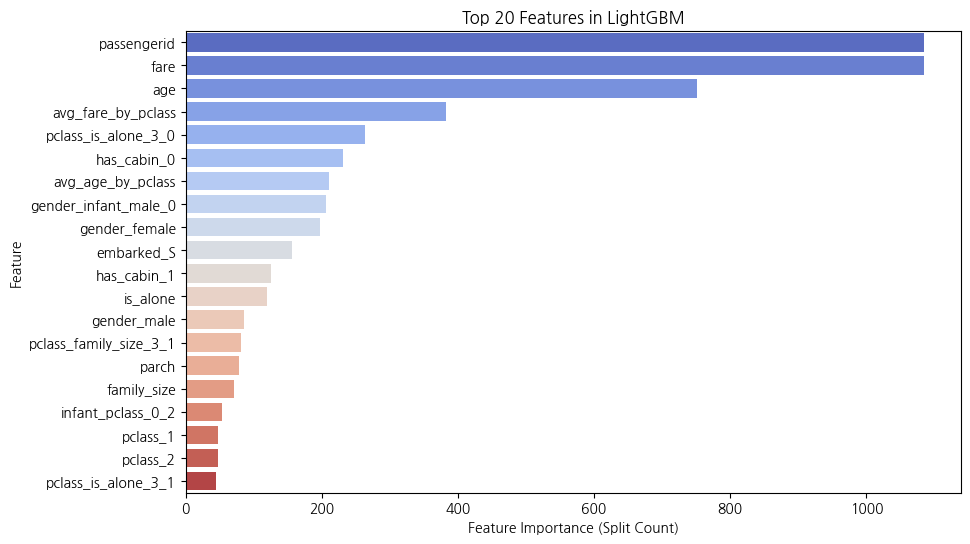

In [858]:
# 상위 20개 특성만 시각화
top_features = df_feature_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')
plt.xlabel("Feature Importance (Split Count)")
plt.ylabel("Feature")
plt.title("Top 20 Features in LightGBM")
plt.show()

In [859]:
top_n = 10
high_importance_features = list(df_feature_importances.head(top_n)['index'])

print(f"선택된 중요 특성: {high_importance_features}")
print(f"선택된 특성 개수: {len(high_importance_features)}")

선택된 중요 특성: ['passengerid', 'fare', 'age', 'avg_fare_by_pclass', 'pclass_is_alone_3_0', 'has_cabin_0', 'avg_age_by_pclass', 'gender_infant_male_0', 'gender_female', 'embarked_S']
선택된 특성 개수: 10


#### 중요도 기준 상위 특성들로 훈련 / 테스트

In [860]:
reset_seeds()

# 선택된 특성만 사용하여 데이터 구성
X_tr_selected = X_tr[high_importance_features]
X_te_selected = X_te[high_importance_features]
ori_te_selected = ori_te[high_importance_features]

model_name = 'model_lgb_V1_high'

# 새로운 모델 학습
reset_seeds()
model_lgb_V1_high = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# 훈련
model_lgb_V1_high.fit(X_tr_selected, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 457
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

In [861]:
reset_seeds()

# 평가
score_tr_lgb = model_lgb_V1_high.score(X_tr_selected, y_tr)
score_te_lgb = model_lgb_V1_high.score(X_te_selected, y_te)
print(f"훈련 점수: {score_tr_lgb}, 테스트 점수: {score_te_lgb}")

훈련 점수: 0.8797814207650273, 테스트 점수: 0.8586956521739131


In [862]:
reset_seeds()

# AUC 계산
y_pred_high = model_lgb_V1_high.predict_proba(X_te_selected)[:, 1]
fpr_high, tpr_high, thresholds_high = roc_curve(y_te, y_pred_high)
auc_te_high = auc(fpr_high, tpr_high)
print(f'{model_lgb_V0_high}: {auc_te_high}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9165413533834587


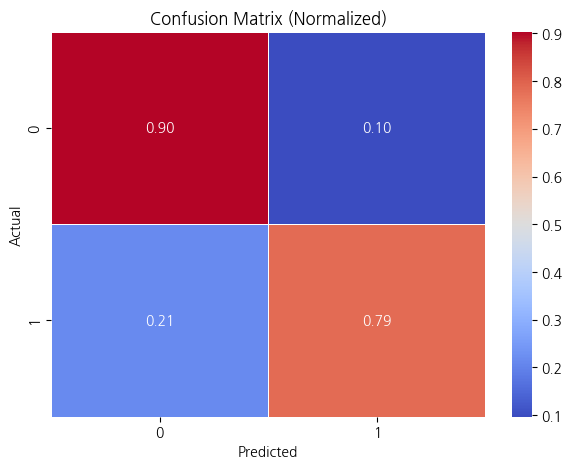

In [863]:
# 혼동행렬 시각화
y_pred_class_high = model_lgb_V1_high.predict(X_te_selected)
norm_conf_mx_high = confusion_matrix(y_te, y_pred_class_high, normalize="true")

plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx_high, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [864]:
ori_te_pred = model_lgb_V1_high.predict_proba(ori_te_selected)[:,1]
ori_te_pred.shape

(393,)

#### 중요도 기준 상위 특성으로 훈련하고 검증한 결과 정리

In [865]:
args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [866]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

model                                         parameters  \
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
2       model_lgb_V1  {'subsample': 0.5, 'objective': 'binary', 'num...   
3  model_lgb_V1_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
0  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   
2  0.867486  0.864130  0.919549   
3  0.879781  0.858696  0.919549   

                                         ori_te_pred  len_features  \
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
2  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
3  [0.7079442896462264, 0.6730694241976282, 0.698...            81   

                                  feaute_importances            create_dt  
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
2  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19  
3  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19

# model_lgbm_V2 (random search 진행) / submission_0212_8.csv
- encoding X
- StandardScaler O

## Train & Test Split

In [867]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [868]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [869]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [870]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [871]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [872]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Feature Extraction

#### pclass별 평균 나이

In [873]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 13) (184, 13) (393, 12)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  
914          24.095018  
805          24.095018  
255          24.095018  
769          24.095018  
527          24.095018

#### embarked별 평균 나이

In [874]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 14) (184, 14) (393, 13)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  
914          24.095018            28.948276  
805          24.095018            29.068433  
255          24.095018            29.068433  
769          24.095018            28.948276  
527          24.095018            29.068433

#### pclass별 평균 요금

In [875]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 15) (184, 15) (393, 14)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  
914          24.095018            28.948276            13.55176  
805          24.095018            29.068433            13.55176  
255          24.095018            29.068433            13.55176  
769          24.095018            28.948276            13.55176  
527          24.095018            29.068433            13.55176

#### embarked별 평균 요금

In [876]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 16) (184, 16) (393, 15)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  
914             14.147372  
805             25.140418  
255             25.140418  
769             14.147372  
527             25.140418

#### 동승한 가족 인원수 컬럼 추가

In [877]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 17) (184, 17) (393, 16)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  
914             14.147372            1  
805             25.140418            7  
255             25.140418            3  
769             14.147372            1  
527             25.140418            1

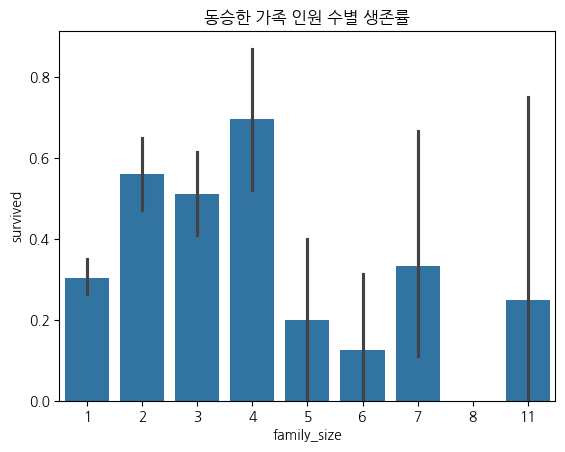

In [878]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [879]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 18) (184, 18) (393, 17)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  
914             14.147372            1         1  
805             25.140418            7         0  
255             25.140418            3         0  
769             14.147372            1         1  
527             25.140418            1         1

#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [880]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

(732, 19) (184, 19) (393, 18)


passengerid  survived  pclass                                name  \
914          914         1       3    Mullens, Miss. Katherine "Katie"   
805          805         0       3  Andersson, Miss. Ebba Iris Alfrida   
255          255         1       3        Klasen, Miss. Gertrud Emilia   
769          769         0       3                Connors, Mr. Patrick   
527          527         0       3                Rintamaki, Mr. Matti   

     gender   age  sibsp  parch             ticket     fare cabin embarked  \
914  female   NaN      0      0              35852   7.7333   NaN        Q   
805  female   6.0      4      2             347082  31.2750   NaN        S   
255  female   1.0      1      1             350405  12.1833   NaN        S   
769    male  70.5      0      0             370369   7.7500   NaN        Q   
527    male  35.0      0      0  STON/O 2. 3101273   7.1250   NaN        S   

     avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914          24.095018            28.948276            13.55176   
805          24.095018            29.068433            13.55176   
255          24.095018            29.068433            13.55176   
769          24.095018            28.948276            13.55176   
527          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  
914             14.147372            1         1          0  
805             25.140418            7         0          0  
255             25.140418            3         0          0  
769             14.147372            1         1          0  
527             25.140418            1         1          0

### Data Cleaning

In [881]:
train.isnull().sum().sort_values(ascending=False)

cabin                   580
age                     135
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_embarked      0
avg_fare_by_pclass        0
avg_age_by_embarked       0
avg_age_by_pclass         0
embarked                  0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [882]:
test.isnull().sum().sort_values(ascending=False)

cabin                   138
age                      45
avg_fare_by_embarked      1
avg_age_by_embarked       1
embarked                  1
passengerid               0
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
fare                      0
survived                  0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
pclass                    0
has_cabin                 0
dtype: int64

In [883]:
ori_te.isnull().sum().sort_values(ascending=False)

cabin                   296
age                      83
embarked                  1
avg_fare_by_embarked      1
avg_age_by_embarked       1
fare                      1
is_alone                  0
family_size               0
avg_fare_by_pclass        0
avg_age_by_pclass         0
passengerid               0
pclass                    0
ticket                    0
parch                     0
sibsp                     0
gender                    0
name                      0
has_cabin                 0
dtype: int64

In [884]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [885]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-885-e249aeb7e77b>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-885-e249aeb7e77b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [886]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 19) / (184, 19)
after: (732, 16) / (184, 16)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone          

In [887]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [888]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [889]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin'],
      dtype='object')

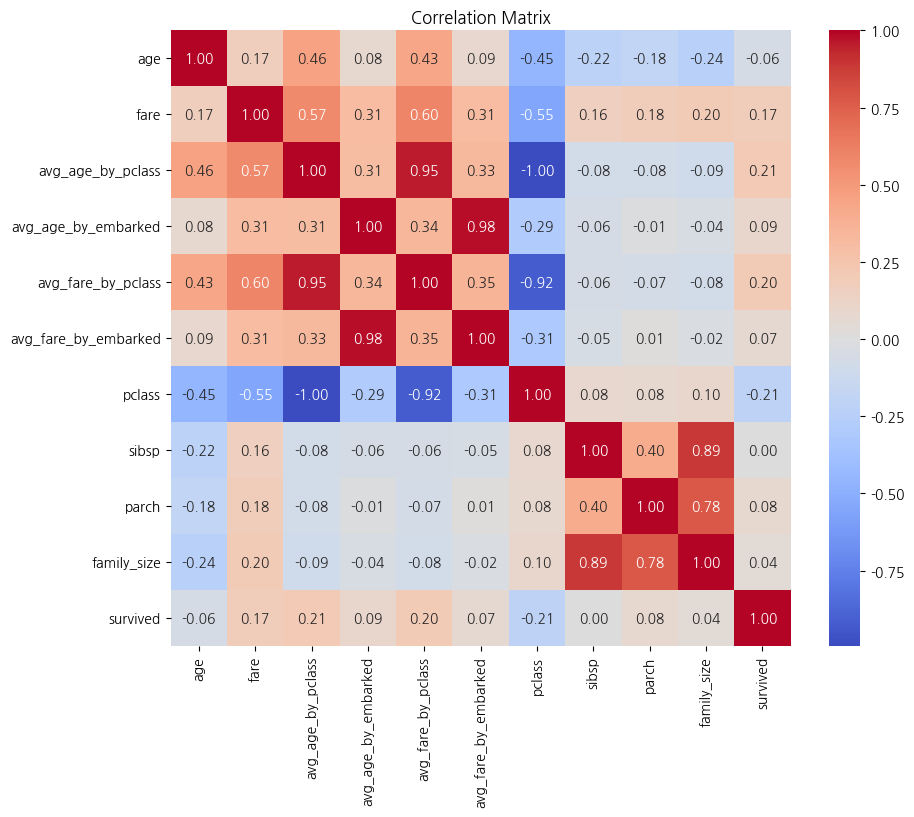

In [890]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

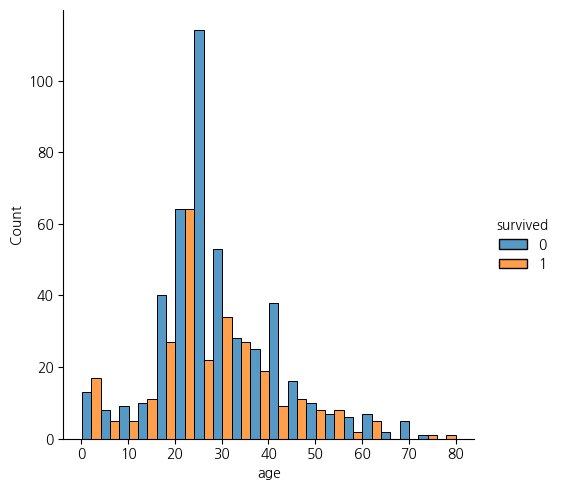

In [891]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [892]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [893]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [894]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

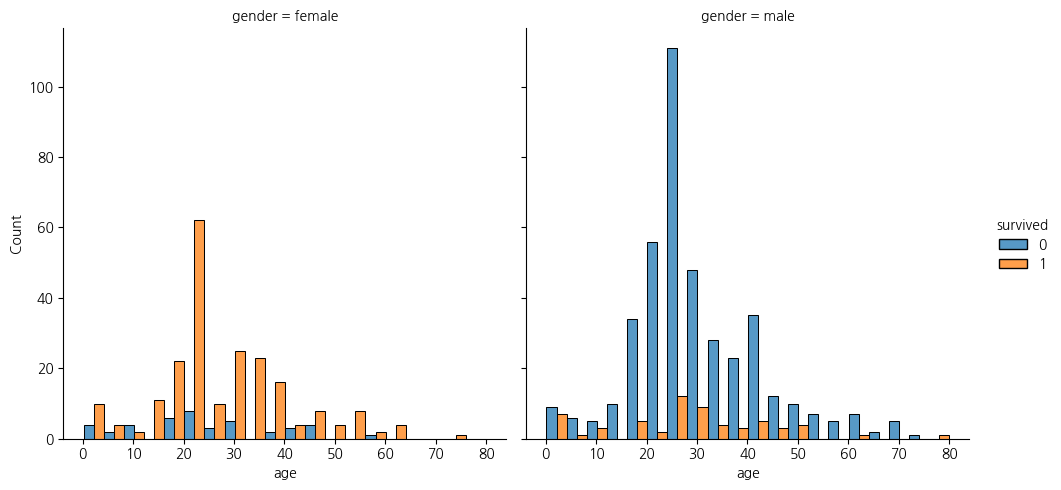

In [895]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [896]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


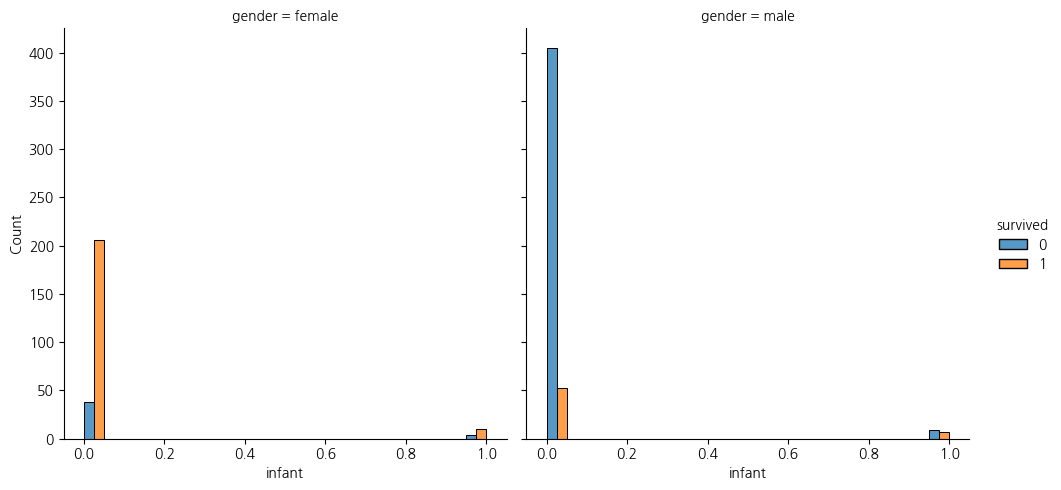

In [897]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [898]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant  
914      female_0  
805      female_0  
255      female_1  
769        male_0  
527        male_0

##### pclass & gender

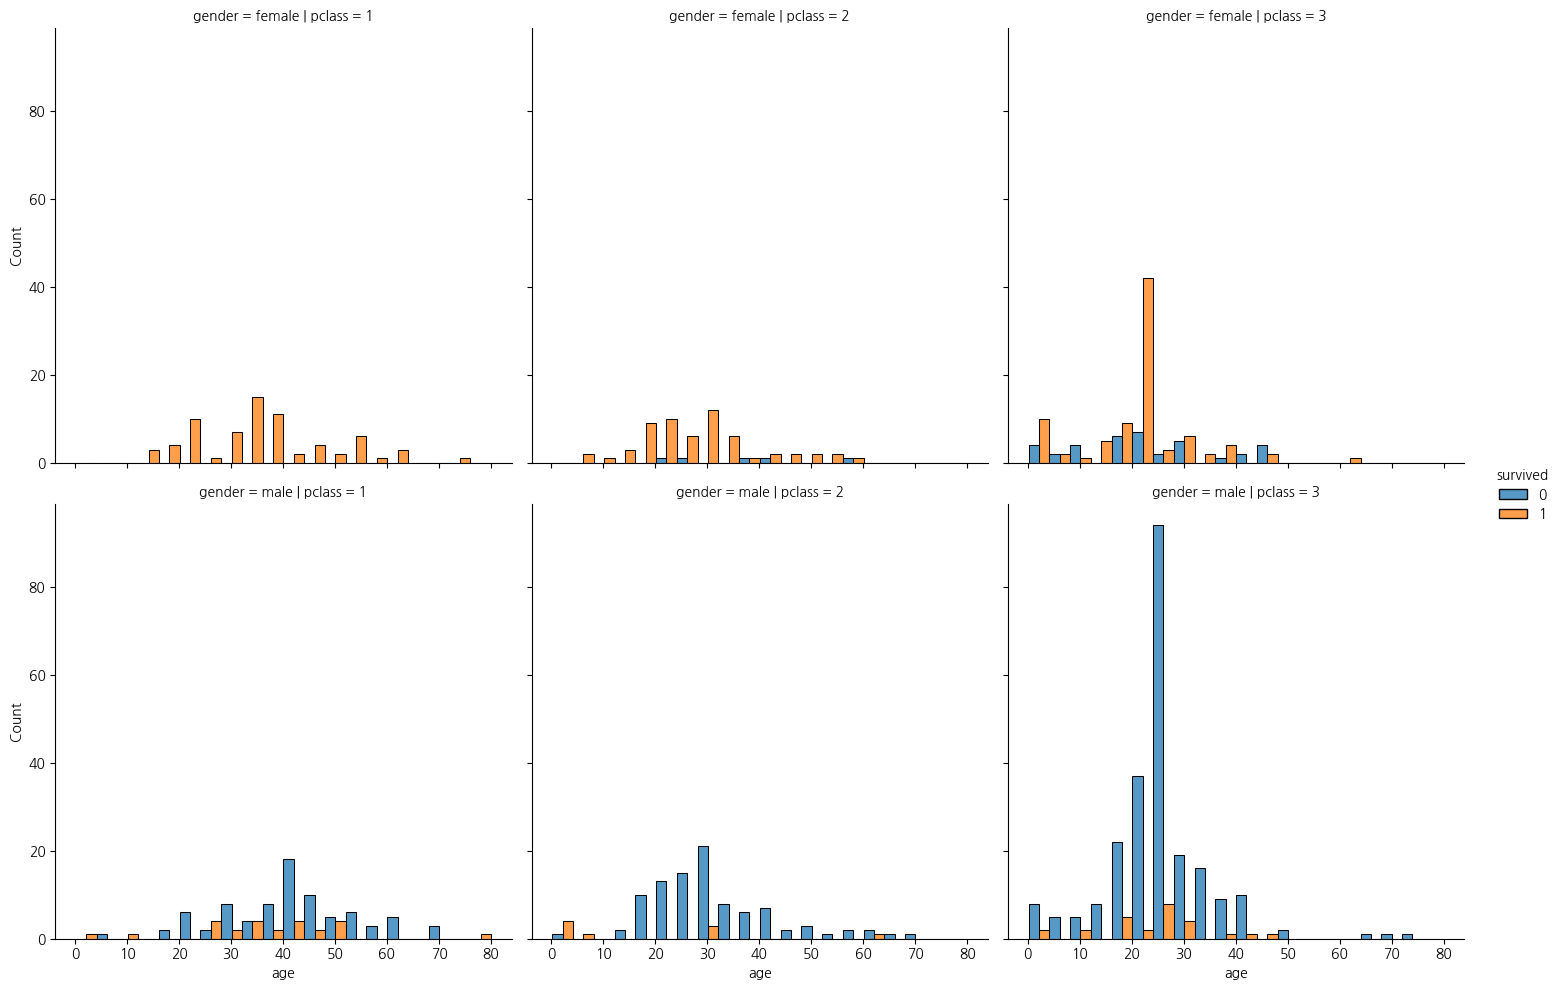

In [899]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [900]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


In [901]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
       dtype='object'),
 19)

In [902]:
train.shape, test.shape, ori_te.shape

((732, 19), (184, 19), (393, 18))

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [903]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
       'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
       'has_cabin', 'infant', 'gender_infant', 'gender_pclass'],
      dtype='object')

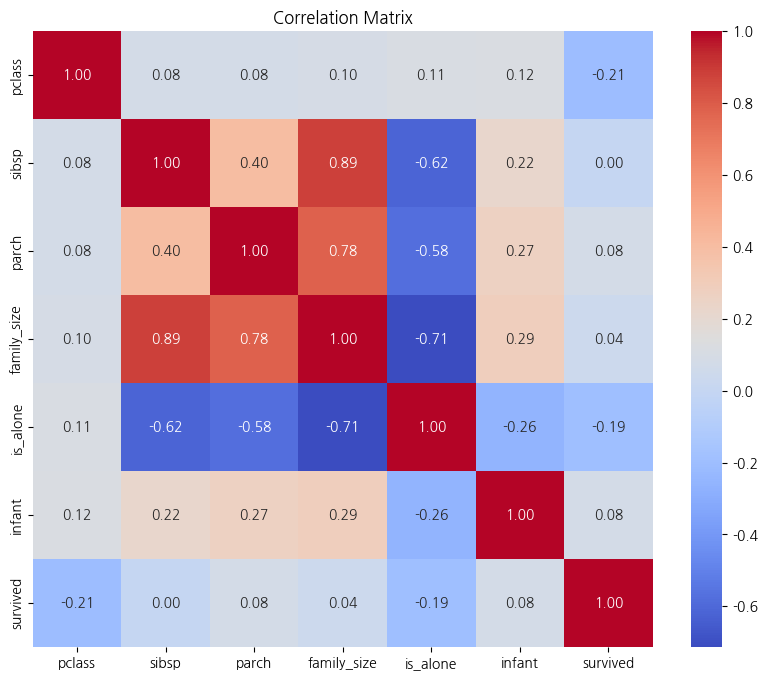

In [904]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [905]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  avg_age_by_embarked  avg_fare_by_pclass  \
914        Q          24.095018            28.948276            13.55176   
805        S          24.095018            29.068433            13.55176   
255        S          24.095018            29.068433            13.55176   
769        Q          24.095018            28.948276            13.55176   
527        S          24.095018            29.068433            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

    gender_infant gender_pclass infant_pclass  
914      female_0      female_3           0_3  
805      female_0      female_3           0_3  
255      female_1      female_3           1_3  
769        male_0        male_3           0_3  
527        male_0        male_3           0_3

##### infant & family_size

In [906]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_pclass  \
914        Q          24.095018  ...            13.55176   
805        S          24.095018  ...            13.55176   
255        S          24.095018  ...            13.55176   
769        Q          24.095018  ...            13.55176   
527        S          24.095018  ...            13.55176   

     avg_fare_by_embarked  family_size  is_alone  has_cabin  infant  \
914             14.147372            1         1          0       0   
805             25.140418            7         0          0       0   
255             25.140418            3         0          0       1   
769             14.147372            1         1          0       0   
527             25.140418            1         1          0       0   

     gender_infant gender_pclass infant_pclass infant_family_size  
914       female_0      female_3           0_3                0_1  
805       female_0      female_3           0_3                0_7  
255       female_1      female_3           1_3                1_3  
769         male_0        male_3           0_3                0_1  
527         male_0        male_3           0_3                0_1  

[5 rows x 21 columns]

##### pclass & is_alone

In [907]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  avg_fare_by_embarked  family_size  \
914        Q          24.095018  ...             14.147372            1   
805        S          24.095018  ...             25.140418            7   
255        S          24.095018  ...             25.140418            3   
769        Q          24.095018  ...             14.147372            1   
527        S          24.095018  ...             25.140418            1   

     is_alone  has_cabin  infant  gender_infant  gender_pclass infant_pclass  \
914         1          0       0       female_0       female_3           0_3   
805         0          0       0       female_0       female_3           0_3   
255         0          0       1       female_1       female_3           1_3   
769         1          0       0         male_0         male_3           0_3   
527         1          0       0         male_0         male_3           0_3   

    infant_family_size pclass_is_alone  
914                0_1             3_1  
805                0_7             3_0  
255                1_3             3_0  
769                0_1             3_1  
527                0_1             3_1  

[5 rows x 22 columns]

##### pclass_family_size

In [908]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


컬럼 생성 이전 : (732, 22), (184, 22), (393, 21)
컬럼 생성 이후 : (732, 23), (184, 23), (393, 22)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  avg_age_by_pclass  ...  family_size  is_alone  has_cabin  \
914        Q          24.095018  ...            1         1          0   
805        S          24.095018  ...            7         0          0   
255        S          24.095018  ...            3         0          0   
769        Q          24.095018  ...            1         1          0   
527        S          24.095018  ...            1         1          0   

     infant  gender_infant  gender_pclass  infant_pclass infant_family_size  \
914       0       female_0       female_3            0_3                0_1   
805       0       female_0       female_3            0_3                0_7   
255       1       female_1       female_3            1_3                1_3   
769       0         male_0         male_3            0_3                0_1   
527       0         male_0         male_3            0_3                0_1   

    pclass_is_alone pclass_family_size  
914             3_1                3_1  
805             3_0                3_7  
255             3_0                3_3  
769             3_1                3_1  
527             3_1                3_1  

[5 rows x 23 columns]

In [909]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Scaling

In [910]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size', 'is_alone',
        'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'infant_family_size', 'pclass_is_alone',
        'pclass_family_size'],
       dtype='object'),
 23,
 Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
        'embarked', 'avg_age_by_pclass', 'avg_age_by_embarked',
        'avg

In [911]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

train: (732, 23), test: (184, 23), ori_te: (393, 22)


In [912]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   passengerid           732 non-null    int64  
 1   survived              732 non-null    int64  
 2   pclass                732 non-null    int64  
 3   gender                732 non-null    object 
 4   age                   732 non-null    float64
 5   sibsp                 732 non-null    int64  
 6   parch                 732 non-null    int64  
 7   fare                  732 non-null    float64
 8   embarked              732 non-null    object 
 9   avg_age_by_pclass     732 non-null    float64
 10  avg_age_by_embarked   732 non-null    float64
 11  avg_fare_by_pclass    732 non-null    float64
 12  avg_fare_by_embarked  732 non-null    float64
 13  family_size           732 non-null    int64  
 14  is_alone              732 non-null    int64  
 15  has_cabin             732 

In [913]:
# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'is_alone', 'has_cabin',
                'infant', 'gender_infant', 'gender_pclass', 'infant_pclass',
                'infant_family_size', 'pclass_is_alone', 'pclass_family_size']

# 수치형 변수만
num_features = ['age', 'sibsp', 'parch', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
                'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size']
len(cat_features), len(num_features)

(12, 9)

In [914]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   passengerid           732 non-null    int64   
 1   survived              732 non-null    int64   
 2   pclass                732 non-null    category
 3   gender                732 non-null    category
 4   age                   732 non-null    float64 
 5   sibsp                 732 non-null    int64   
 6   parch                 732 non-null    int64   
 7   fare                  732 non-null    float64 
 8   embarked              732 non-null    category
 9   avg_age_by_pclass     732 non-null    float64 
 10  avg_age_by_embarked   732 non-null    float64 
 11  avg_fare_by_pclass    732 non-null    float64 
 12  avg_fare_by_embarked  732 non-null    float64 
 13  family_size           732 non-null    int64   
 14  is_alone              732 non-null    category
 15  has_cabin

In [915]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

((732, 22), (732,), (184, 22), (184,), (393, 22))

In [916]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

before: (732, 22), (184, 22), (393, 22)
after: (732, 22), (184, 22), (393, 22)


## Training

In [917]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

In [918]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [919]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [920]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [921]:
reset_seeds()
model_name = 'model_lgb_V2'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V2 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V2.fit(X_tr_scaled, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 555
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

## Evaluation (평가)

In [922]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V2.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V2.score(X_te_scaled, y_te)

print(f'{model_lgb_V2} : {score_tr_lgb}, {score_te_lgb}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5) : 0.8688524590163934, 0.8695652173913043


### AUC 점수

In [923]:
y_pred = model_lgb_V2.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V2}: {auc_te}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9145363408521304


### 혼동행렬

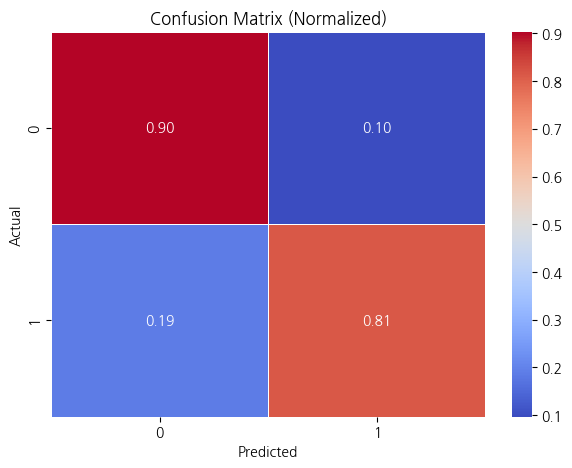

In [924]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V2.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [925]:
ori_te_pred = model_lgb_V2.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

(393,)

### 특성 중요도

In [926]:
df_feature_importances = pd.DataFrame(model_lgb_V2.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

(22, 2)


index     0
0                   fare  1270
1            passengerid  1050
2                    age   928
3                 pclass   588
4                 gender   277
5               embarked   275
6      avg_age_by_pclass   264
7              has_cabin   253
8            family_size   184
9     avg_fare_by_pclass   137
10                 parch   130
11         gender_infant   123
12              is_alone    94
13         gender_pclass    83
14                 sibsp    57
15    pclass_family_size    30
16   avg_age_by_embarked    16
17  avg_fare_by_embarked    13
18       pclass_is_alone     8
19    infant_family_size     2

### 결과 정리

In [927]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [928]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

model                                         parameters  \
4       model_lgb_V2  {'subsample': 0.5, 'objective': 'binary', 'num...   
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
2       model_lgb_V1  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
3  model_lgb_V1_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
4  0.868852  0.869565  0.914536   
0  0.867486  0.864130  0.919549   
2  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   
3  0.879781  0.858696  0.919549   

                                         ori_te_pred  len_features  \
4  [0.731556192254988, 0.6879417768146249, 0.7230...            22   
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
2  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
3  [0.7079442896462264, 0.6730694241976282, 0.698...            81   

                                  feaute_importances            create_dt  \
4  [fare, passengerid, age, pclass, gender, embar...  2025-02-12 22:07:41   
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47   
2  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19   
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47   
3  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19   

   score_diff  auc_diff  total_diff  
4    0.000713  0.044971    0.045684  
0    0.003356  0.055418    0.058774  
2    0.003356  0.055418    0.058774  
1    0.021086  0.060853    0.081939  
3    0.021086  0.060853    0.081939

#### 중요도 기준 상위 특성 선택

<ipython-input-929-49cae52706ab>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')


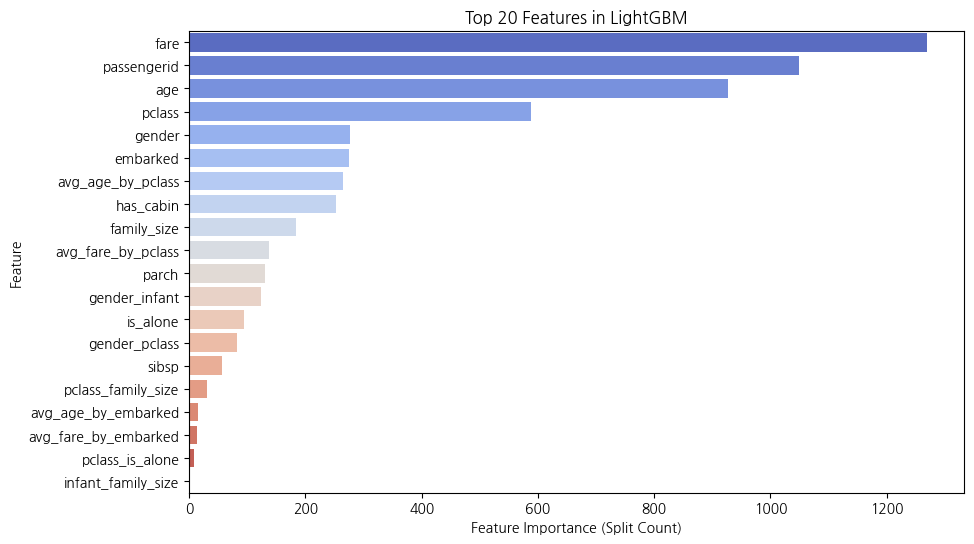

In [929]:
# 상위 20개 특성만 시각화
top_features = df_feature_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')
plt.xlabel("Feature Importance (Split Count)")
plt.ylabel("Feature")
plt.title("Top 20 Features in LightGBM")
plt.show()

In [930]:
top_n = 10
high_importance_features = list(df_feature_importances.head(top_n)['index'])

print(f"선택된 중요 특성: {high_importance_features}")
print(f"선택된 특성 개수: {len(high_importance_features)}")

선택된 중요 특성: ['fare', 'passengerid', 'age', 'pclass', 'gender', 'embarked', 'avg_age_by_pclass', 'has_cabin', 'family_size', 'avg_fare_by_pclass']
선택된 특성 개수: 10


#### 중요도 기준 상위 특성들로 훈련 / 테스트

In [931]:
reset_seeds()

# 선택된 특성만 사용하여 데이터 구성
X_tr_selected = X_tr_scaled[high_importance_features]
X_te_selected = X_te_scaled[high_importance_features]
ori_te_selected = ori_te_scaled[high_importance_features]

model_name = 'model_lgb_V2_high'

# 새로운 모델 학습
reset_seeds()
model_lgb_V2_high = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# 훈련
model_lgb_V2_high.fit(X_tr_selected, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 471
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

In [932]:
reset_seeds()

# 평가
score_tr_lgb = model_lgb_V2_high.score(X_tr_selected, y_tr)
score_te_lgb = model_lgb_V2_high.score(X_te_selected, y_te)
print(f"훈련 점수: {score_tr_lgb}, 테스트 점수: {score_te_lgb}")

훈련 점수: 0.8743169398907104, 테스트 점수: 0.8641304347826086


In [933]:
reset_seeds()

# AUC 계산
y_pred_high = model_lgb_V2_high.predict_proba(X_te_selected)[:, 1]
fpr_high, tpr_high, thresholds_high = roc_curve(y_te, y_pred_high)
auc_te_high = auc(fpr_high, tpr_high)
print(f'{model_lgb_V2_high}: {auc_te_high}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9180451127819549


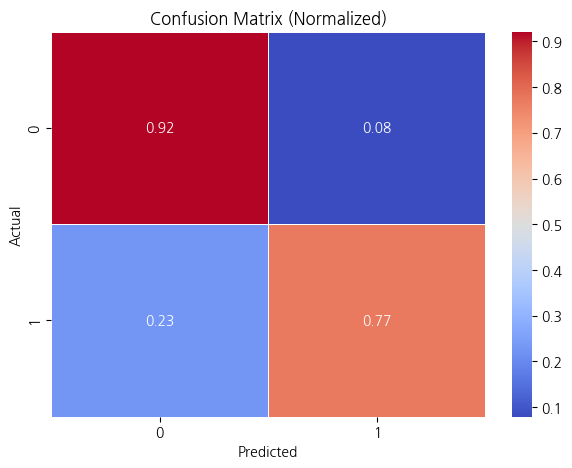

In [934]:
# 혼동행렬 시각화
y_pred_class_high = model_lgb_V2_high.predict(X_te_selected)
norm_conf_mx_high = confusion_matrix(y_te, y_pred_class_high, normalize="true")

plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx_high, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [935]:
ori_te_pred = model_lgb_V2_high.predict_proba(ori_te_selected)[:,1]
ori_te_pred.shape

(393,)

#### 중요도 기준 상위 특성으로 훈련하고 검증한 결과 정리

In [936]:
args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [937]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

model                                         parameters  \
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
2       model_lgb_V1  {'subsample': 0.5, 'objective': 'binary', 'num...   
3  model_lgb_V1_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
4       model_lgb_V2  {'subsample': 0.5, 'objective': 'binary', 'num...   
5  model_lgb_V2_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
0  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   
2  0.867486  0.864130  0.919549   
3  0.879781  0.858696  0.919549   
4  0.868852  0.869565  0.914536   
5  0.874317  0.864130  0.914536   

                                         ori_te_pred  len_features  \
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
2  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
3  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
4  [0.731556192254988, 0.6879417768146249, 0.7230...            22   
5  [0.6748468326466172, 0.5977305058577406, 0.645...            22   

                                  feaute_importances            create_dt  
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
2  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19  
3  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19  
4  [fare, passengerid, age, pclass, gender, embar...  2025-02-12 22:07:41  
5  [fare, passengerid, age, pclass, gender, embar...  2025-02-12 22:07:41

# model_lgbm_V3 (random search 진행)

## Train & Test Split

In [938]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [939]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [940]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [941]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [942]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [943]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Data Cleaning

In [944]:
train.isnull().sum().sort_values(ascending=False)

cabin          580
age            135
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
embarked         0
dtype: int64

In [945]:
test.isnull().sum().sort_values(ascending=False)

cabin          138
age             45
embarked         1
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
dtype: int64

In [946]:
ori_te.isnull().sum().sort_values(ascending=False)

cabin          296
age             83
fare             1
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
dtype: int64

In [947]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [948]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-948-8599dc5499ad>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-948-8599dc5499ad>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

In [949]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 13) / (184, 13)
after: (732, 10) / (184, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   gender       732 non-null    object 
 4   age          732 non-null    float64
 5   sibsp        732 non-null    int64  
 6   parch        732 non-null    int64  
 7   fare         732 non-null    float64
 8   embarked     732 non-null    object 
 9   has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 79.1+ KB


In [950]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [951]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   gender       732 non-null    object 
 4   age          732 non-null    float64
 5   sibsp        732 non-null    int64  
 6   parch        732 non-null    int64  
 7   fare         732 non-null    float64
 8   embarked     732 non-null    object 
 9   has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 79.1+ KB


#### numeric features (수치형 데이터) 중 continuous (연속형)


In [952]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'has_cabin'],
      dtype='object')

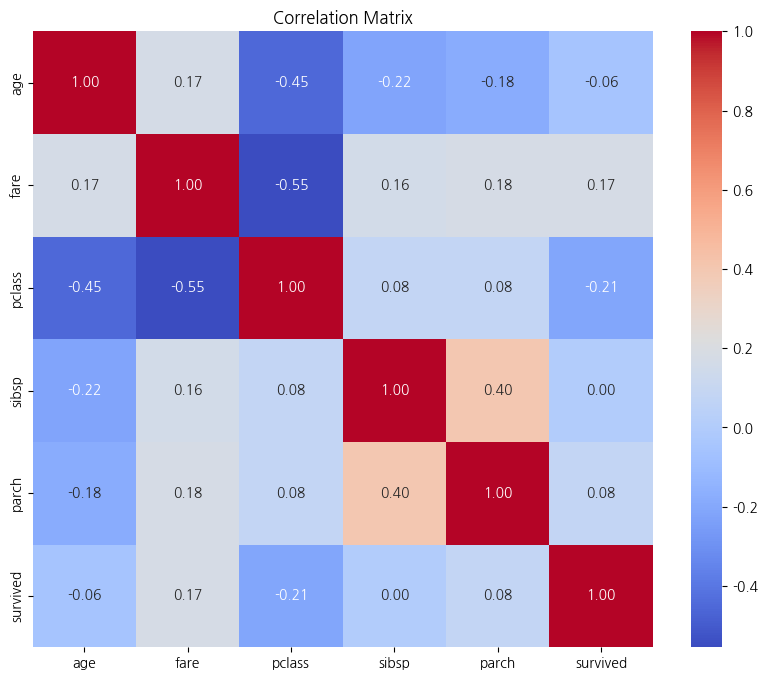

In [953]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

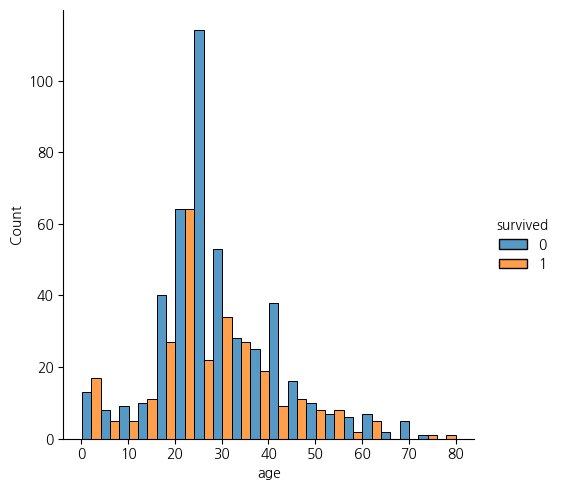

In [954]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [955]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [956]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [957]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

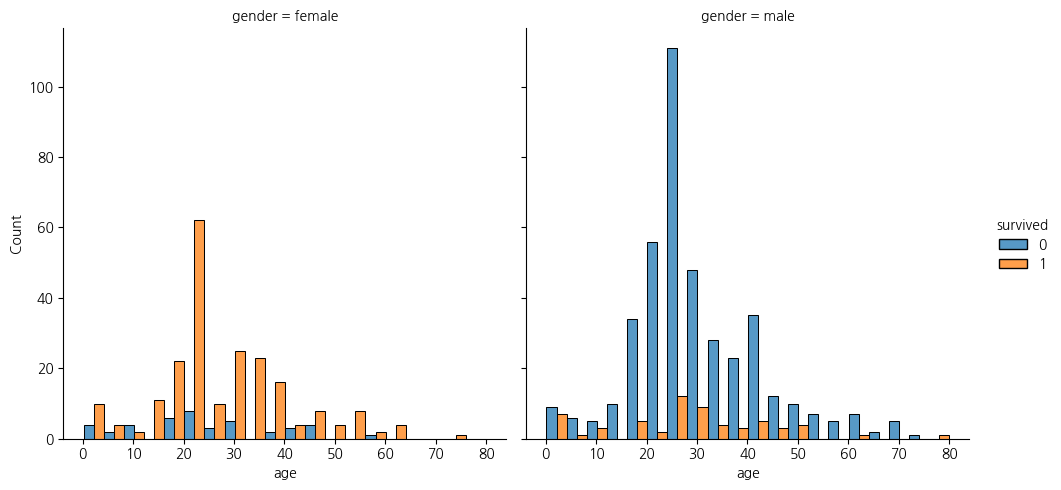

In [958]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [959]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 10), (184, 10), (393, 9)
컬럼 생성 이후 : (732, 11), (184, 11), (393, 10)


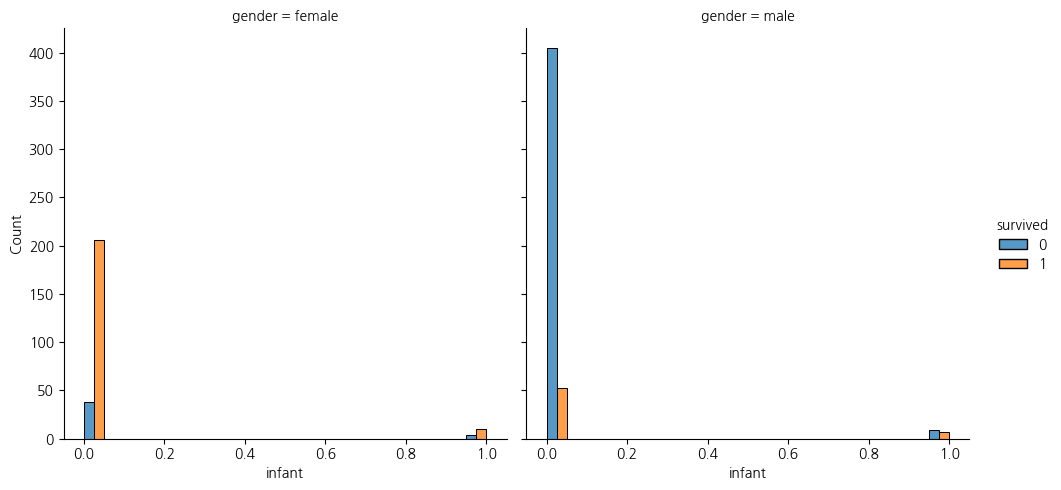

In [960]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [961]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 11), (184, 11), (393, 10)
컬럼 생성 이후 : (732, 12), (184, 12), (393, 11)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  has_cabin  infant gender_infant  
914        Q          0       0      female_0  
805        S          0       0      female_0  
255        S          0       1      female_1  
769        Q          0       0        male_0  
527        S          0       0        male_0

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass', 'infant_pclass']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'infant']

print(f"범주형 : {len(cat_features)}, 수치형 : {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V3'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V3 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V3.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V3.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V3.score(X_te_scaled, y_te)

print(f'{model_lgb_V3} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V3.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V3}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V3.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

- 11%: 사망자를 생존자로 잘못 분류
- 19%: 생존자를 사망자로 잘못 분류

In [ ]:
ori_te_pred = model_lgb_V3.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V3.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

#### 중요도 기준 상위 특성 선택

In [ ]:
# 상위 20개 특성만 시각화
top_features = df_feature_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_features, x=0, y='index', palette='coolwarm')
plt.xlabel("Feature Importance (Split Count)")
plt.ylabel("Feature")
plt.title("Top 20 Features in LightGBM")
plt.show()

In [ ]:
top_n = 15
high_importance_features = list(df_feature_importances.head(top_n)['index'])

print(f"선택된 중요 특성: {high_importance_features}")
print(f"선택된 특성 개수: {len(high_importance_features)}")

#### 중요도 기준 상위 특성들로 훈련 / 테스트

In [ ]:
reset_seeds()

# 선택된 특성만 사용하여 데이터 구성
X_tr_selected = X_tr_scaled[high_importance_features]
X_te_selected = X_te_scaled[high_importance_features]
ori_te_selected = ori_te_scaled[high_importance_features]

model_name = 'model_lgb_V3_high'

# 새로운 모델 학습
reset_seeds()
model_lgb_V3_high = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# 훈련
model_lgb_V3_high.fit(X_tr_selected, y_tr)

[LightGBM] [Info] Number of positive: 276, number of negative: 456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 488
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377049 -> initscore=-0.502092
[LightGBM] [Info] Start training from score -0.502092
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5)

In [ ]:
reset_seeds()

# 평가
score_tr_lgb = model_lgb_V3_high.score(X_tr_selected, y_tr)
score_te_lgb = model_lgb_V3_high.score(X_te_selected, y_te)
print(f"훈련 점수: {score_tr_lgb}, 테스트 점수: {score_te_lgb}")

훈련 점수: 0.8620218579234973, 테스트 점수: 0.8641304347826086


In [ ]:
reset_seeds()

# AUC 계산
y_pred_high = model_lgb_V3_high.predict_proba(X_te_selected)[:, 1]
fpr_high, tpr_high, thresholds_high = roc_curve(y_te, y_pred_high)
auc_te_high = auc(fpr_high, tpr_high)
print(f'{model_lgb_V3_high}: {auc_te_high}')

LGBMClassifier(boosting_type='dart', colsample_bytree=0.5, learning_rate=0.01,
               max_depth=29, metric='auc', min_child_samples=15,
               min_child_weight=10, n_estimators=550, num_leaves=30,
               objective='binary', random_state=42, subsample=0.5): 0.9156641604010024


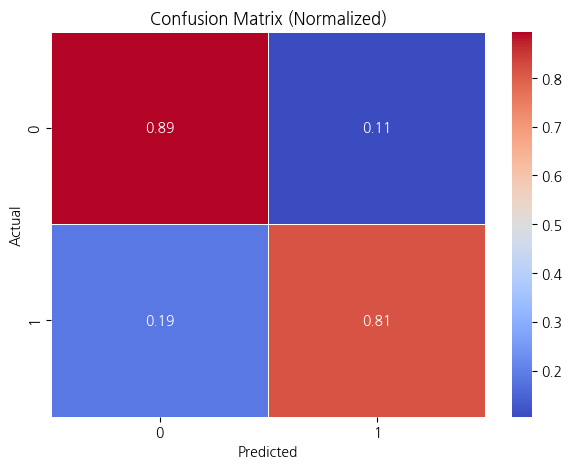

In [ ]:
# 혼동행렬 시각화
y_pred_class_high = model_lgb_V3_high.predict(X_te_selected)
norm_conf_mx_high = confusion_matrix(y_te, y_pred_class_high, normalize="true")

plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx_high, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V3_high.predict_proba(ori_te_selected)[:,1]
ori_te_pred.shape

(393,)

#### 중요도 기준 상위 특성으로 훈련하고 검증한 결과 정리

In [ ]:
args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
pd.DataFrame(args.results).sort_values(by=['auc_te'], ascending=False)

model                                         parameters  \
0       model_lgb_V0  {'subsample': 0.5, 'objective': 'binary', 'num...   
1  model_lgb_V0_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
2       model_lgb_V1  {'subsample': 0.5, 'objective': 'binary', 'num...   
3  model_lgb_V1_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
6       model_lgb_V3  {'subsample': 0.5, 'objective': 'binary', 'num...   
7  model_lgb_V3_high  {'subsample': 0.5, 'objective': 'binary', 'num...   
4       model_lgb_V2  {'subsample': 0.5, 'objective': 'binary', 'num...   
5  model_lgb_V2_high  {'subsample': 0.5, 'objective': 'binary', 'num...   

   score_tr  score_te    auc_te  \
0  0.867486  0.864130  0.919549   
1  0.879781  0.858696  0.919549   
2  0.867486  0.864130  0.919549   
3  0.879781  0.858696  0.919549   
6  0.862022  0.864130  0.917669   
7  0.862022  0.864130  0.917669   
4  0.868852  0.869565  0.914536   
5  0.874317  0.864130  0.914536   

                                         ori_te_pred  len_features  \
0  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
1  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
2  [0.7406200868968245, 0.7395791515530487, 0.742...            81   
3  [0.7079442896462264, 0.6730694241976282, 0.698...            81   
6  [0.7396065909427016, 0.7273871339093434, 0.732...            13   
7  [0.7411703166556863, 0.7281941928812717, 0.737...            13   
4  [0.731556192254988, 0.6879417768146249, 0.7230...            22   
5  [0.6748468326466172, 0.5977305058577406, 0.645...            22   

                                  feaute_importances            create_dt  
0  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
1  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:06:47  
2  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19  
3  [passengerid, fare, age, avg_fare_by_pclass, p...  2025-02-12 22:07:19  
6  [fare, passengerid, age, pclass, embarked, has...  2025-02-12 22:08:13  
7  [fare, passengerid, age, pclass, embarked, has...  2025-02-12 22:08:13  
4  [fare, passengerid, age, pclass, gender, embar...  2025-02-12 22:07:41  
5  [fare, passengerid, age, pclass, gender, embar...  2025-02-12 22:07:41

# model_lgbm_V4 (random search 진행)

## Train & Test Split

In [ ]:
ori_train.head()

passengerid  survived  pclass  \
0            0         0       2   
1            1         0       3   
2            2         1       1   
3            3         1       3   
4            4         0       2   

                                                name  gender   age  sibsp  \
0                     Wheeler, Mr. Edwin Frederick""    male   NaN      0   
1                                 Henry, Miss. Delia  female   NaN      0   
2  Hays, Mrs. Charles Melville (Clara Jennings Gr...  female  52.0      1   
3       Andersson, Mr. August Edvard ("Wennerstrom")    male  27.0      0   
4                                  Hold, Mr. Stephen    male  44.0      1   

   parch         ticket     fare cabin embarked  
0      0  SC/PARIS 2159  12.8750   NaN        S  
1      0         382649   7.7500   NaN        Q  
2      1          12749  93.5000   B69        S  
3      0         350043   7.7958   NaN        S  
4      0          26707  26.0000   NaN        S

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

((916, 12), (393, 11))

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

((732, 12), (184, 12))

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 12), (184, 12), (393, 11))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
ori_te.columns

Index(['passengerid', 'pclass', 'name', 'gender', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

cabin          580
age            135
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
embarked         0
dtype: int64

In [ ]:
test.isnull().sum().sort_values(ascending=False)

cabin          138
age             45
embarked         1
passengerid      0
survived         0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
fare             0
dtype: int64

In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

cabin          296
age             83
fare             1
embarked         1
passengerid      0
pclass           0
name             0
gender           0
sibsp            0
parch            0
ticket           0
dtype: int64

In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

(914    21.414891
 805     6.000000
 255     1.000000
 769    70.500000
 527    35.000000
          ...    
 403     1.000000
 824    34.000000
 879    10.000000
 214    24.000000
 636    70.000000
 Name: age, Length: 732, dtype: float64,
 914     7.7333
 805    31.2750
 255    12.1833
 769     7.7500
 527     7.1250
         ...   
 403    15.7417
 824     8.0500
 879    24.1500
 214    79.2000
 636    71.0000
 Name: fare, Length: 732, dtype: float64,
 'S')

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

<ipython-input-1009-8599dc5499ad>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['age'].fillna(age_mean, inplace=True)
<ipython-input-1009-8599dc5499ad>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

before: (732, 13) / (184, 13)
after: (732, 10) / (184, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   gender       732 non-null    object 
 4   age          732 non-null    float64
 5   sibsp        732 non-null    int64  
 6   parch        732 non-null    int64  
 7   fare         732 non-null    float64
 8   embarked     732 non-null    object 
 9   has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 79.1+ KB


In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### EDA

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  732 non-null    int64  
 1   survived     732 non-null    int64  
 2   pclass       732 non-null    int64  
 3   gender       732 non-null    object 
 4   age          732 non-null    float64
 5   sibsp        732 non-null    int64  
 6   parch        732 non-null    int64  
 7   fare         732 non-null    float64
 8   embarked     732 non-null    object 
 9   has_cabin    732 non-null    int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 79.1+ KB


In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'has_cabin'],
      dtype='object')

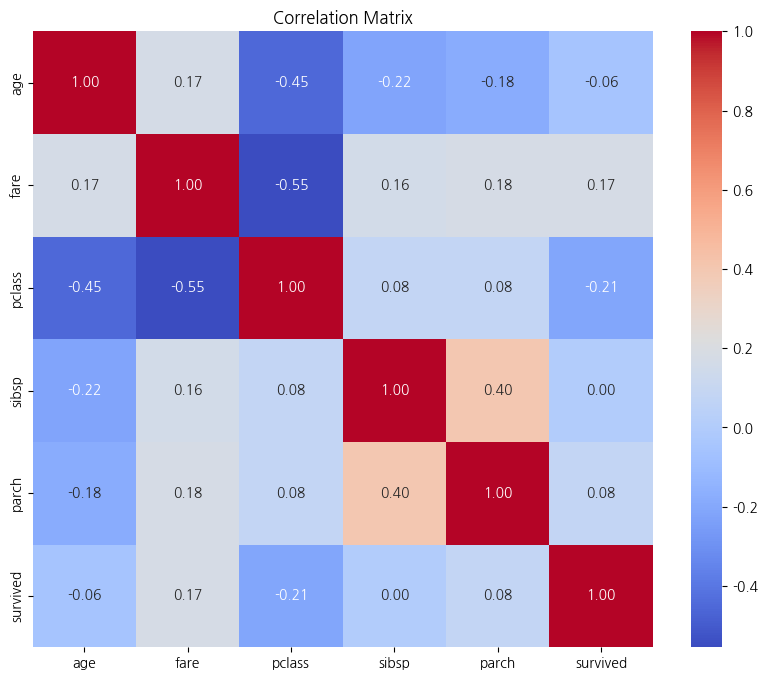

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

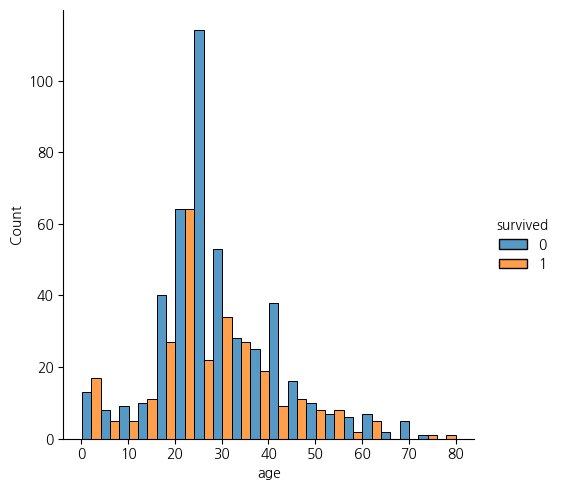

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

0.5757575757575758

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

0.2777777777777778

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

0.3676680972818312

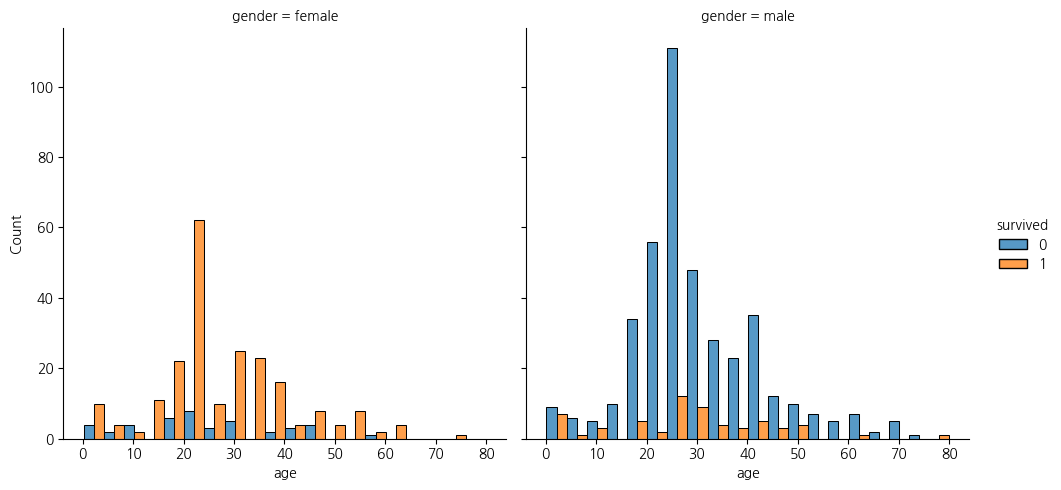

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 10), (184, 10), (393, 9)
컬럼 생성 이후 : (732, 11), (184, 11), (393, 10)


##### gender & infant

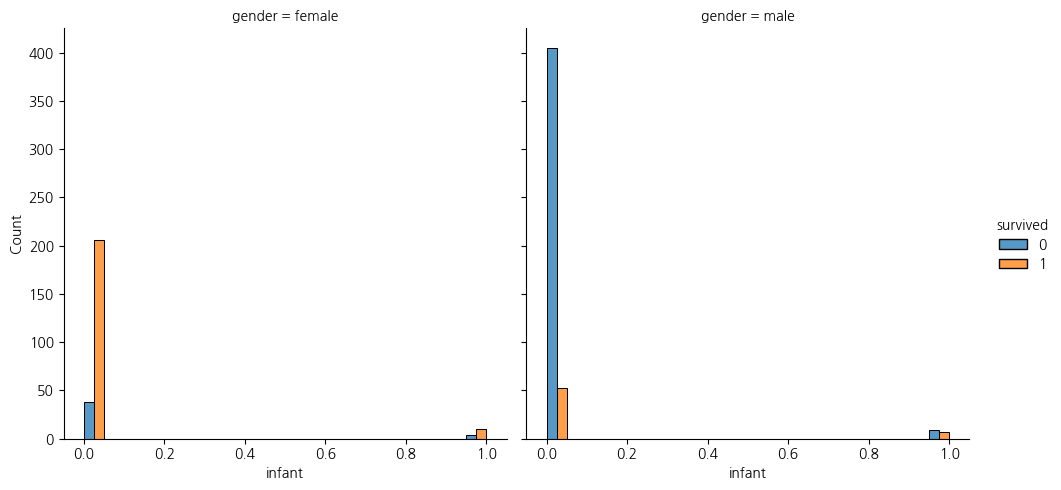

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 11), (184, 11), (393, 10)
컬럼 생성 이후 : (732, 12), (184, 12), (393, 11)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  has_cabin  infant gender_infant  
914        Q          0       0      female_0  
805        S          0       0      female_0  
255        S          0       1      female_1  
769        Q          0       0        male_0  
527        S          0       0        male_0

##### pclass & gender

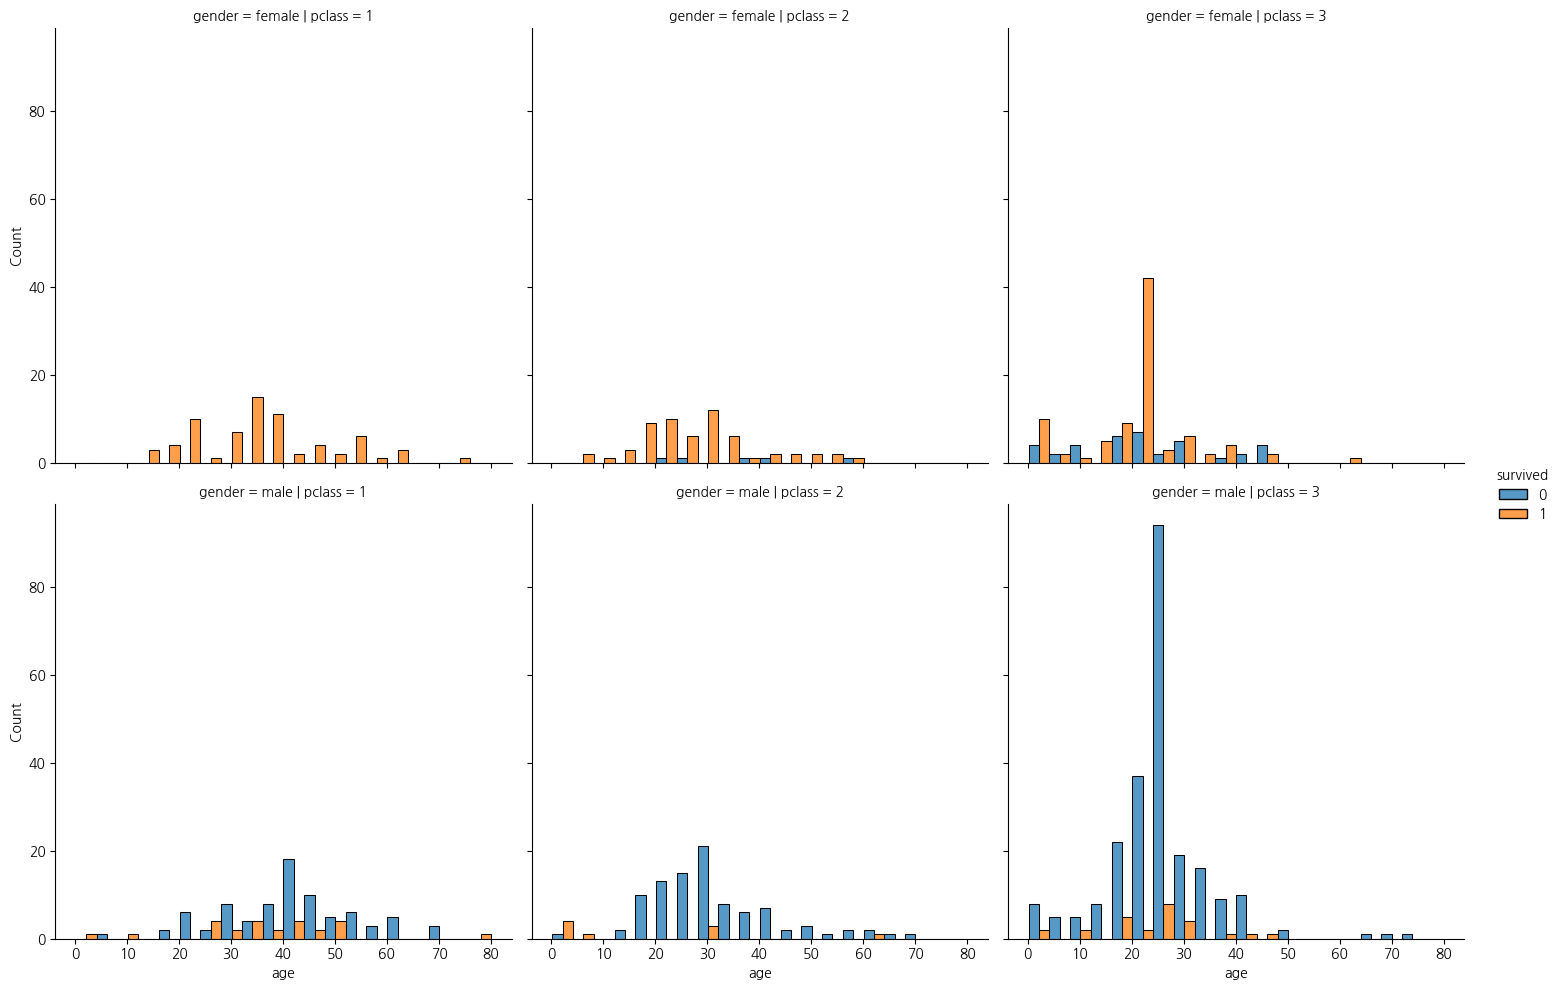

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 12), (184, 12), (393, 11)
컬럼 생성 이후 : (732, 13), (184, 13), (393, 12)


In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass'],
       dtype='object'),
 13)

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 13), (184, 13), (393, 12))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
       'gender_pclass'],
      dtype='object')

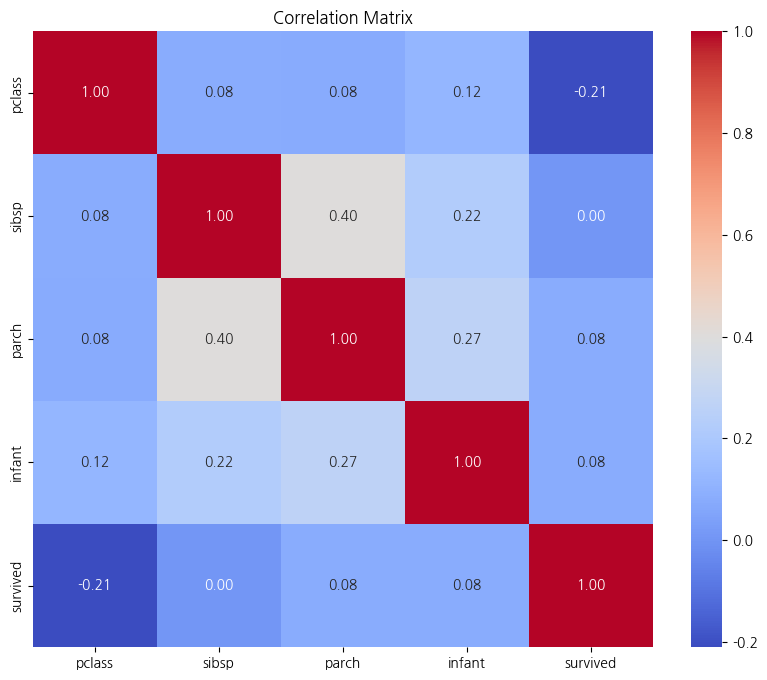

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 13), (184, 13), (393, 12)
컬럼 생성 이후 : (732, 14), (184, 14), (393, 13)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  has_cabin  infant gender_infant gender_pclass infant_pclass  
914        Q          0       0      female_0      female_3           0_3  
805        S          0       0      female_0      female_3           0_3  
255        S          0       1      female_1      female_3           1_3  
769        Q          0       0        male_0        male_3           0_3  
527        S          0       0        male_0        male_3           0_3

In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass', 'infant_pclass'],
       dtype='object'),
 14)

##### gender & sibsp

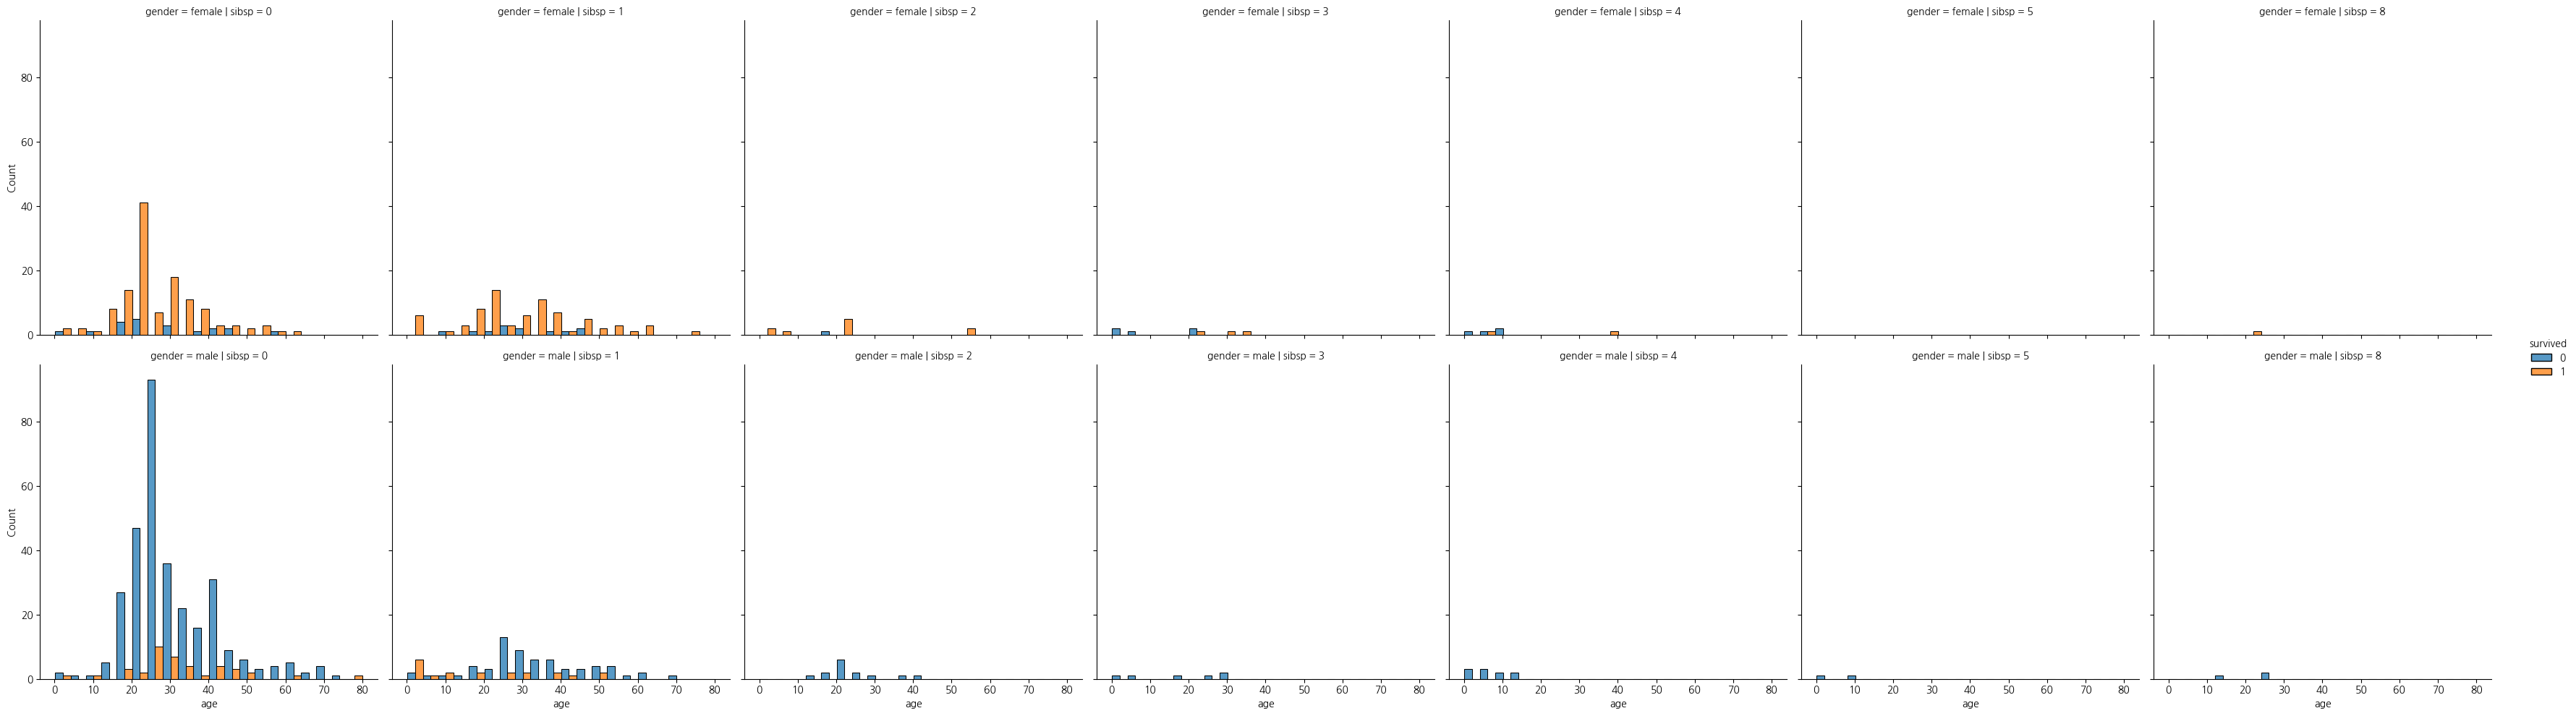

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")
# 'sibsp' 값이 2 이상이면 '2'로 변환, 그렇지 않으면 그대로 유지
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass
  return result

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")


컬럼 생성 이전 : (732, 14), (184, 14), (393, 13)
컬럼 생성 이후 : (732, 15), (184, 15), (393, 14)


#### gender & parch

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

#### fare_pclass

In [ ]:
train.info()

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 객실 등급 대비 요금 비율
train["fare_per_pclass"] = train["fare"] / train["pclass"]
test["fare_per_pclass"] = test["fare"] / test["pclass"]
ori_te["fare_per_pclass"] = ori_te["fare"] / ori_te["pclass"]

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

#### high_fare

In [ ]:
train.describe()

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

fare_threshold = train["fare"].quantile(0.75)
train["high_fare"] = (train["fare"] >= fare_threshold).astype(int)
test["high_fare"] = (test["fare"] >= fare_threshold).astype(int)
ori_te["high_fare"] = (ori_te["fare"] >= fare_threshold).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

#### fare_group

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# fare값을 일정한 범위로 그룹화하여 새로운 범주형 변수 fare_group을 생성
def assign_fare_group(fare):
    if fare < 10:
        return 0
    elif fare < 30:
        return 1
    elif fare < 100:
        return 2
    else:
        return 3

# 요금이 높은 그룹일수록 생존 가능성이 높음
train["fare_group"] = train["fare"].apply(assign_fare_group)
test["fare_group"] = test["fare"].apply(assign_fare_group)
ori_te["fare_group"] = ori_te["fare"].apply(assign_fare_group)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")


#### gender & fare

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["gender_fare"] = train["gender"] + "_" + train["fare_group"].astype(str)
test["gender_fare"] = test["gender"] + "_" + test["fare_group"].astype(str)
ori_te["gender_fare"] = ori_te["gender"] + "_" + ori_te["fare_group"].astype(str)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

#### family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["family_size"] = train["sibsp"] + train["parch"] + 1
test["family_size"] = test["sibsp"] + test["parch"] + 1
ori_te["family_size"] = ori_te["sibsp"] + ori_te["parch"] + 1

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

#### alone

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["is_alone"] = (train["family_size"] == 1).astype(int)
test["is_alone"] = (test["family_size"] == 1).astype(int)
ori_te["is_alone"] = (ori_te["family_size"] == 1).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass',
                'infant_pclass', 'gender_sibsp', 'gender_parch', 'gender_fare']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'infant',
                'fare_per_pclass', 'high_fare', 'fare_group', 'family_size', 'is_alone']

print(f"범주형 : {len(cat_features)}, 수치형 : {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")


In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V4'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V4 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V4.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V4.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V4.score(X_te_scaled, y_te)

print(f'{model_lgb_V4} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V4.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V4}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V4.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V4.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V4.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V5 (random search, minmax 진행)

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

In [ ]:
test.isnull().sum().sort_values(ascending=False)

In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

##### gender & infant

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

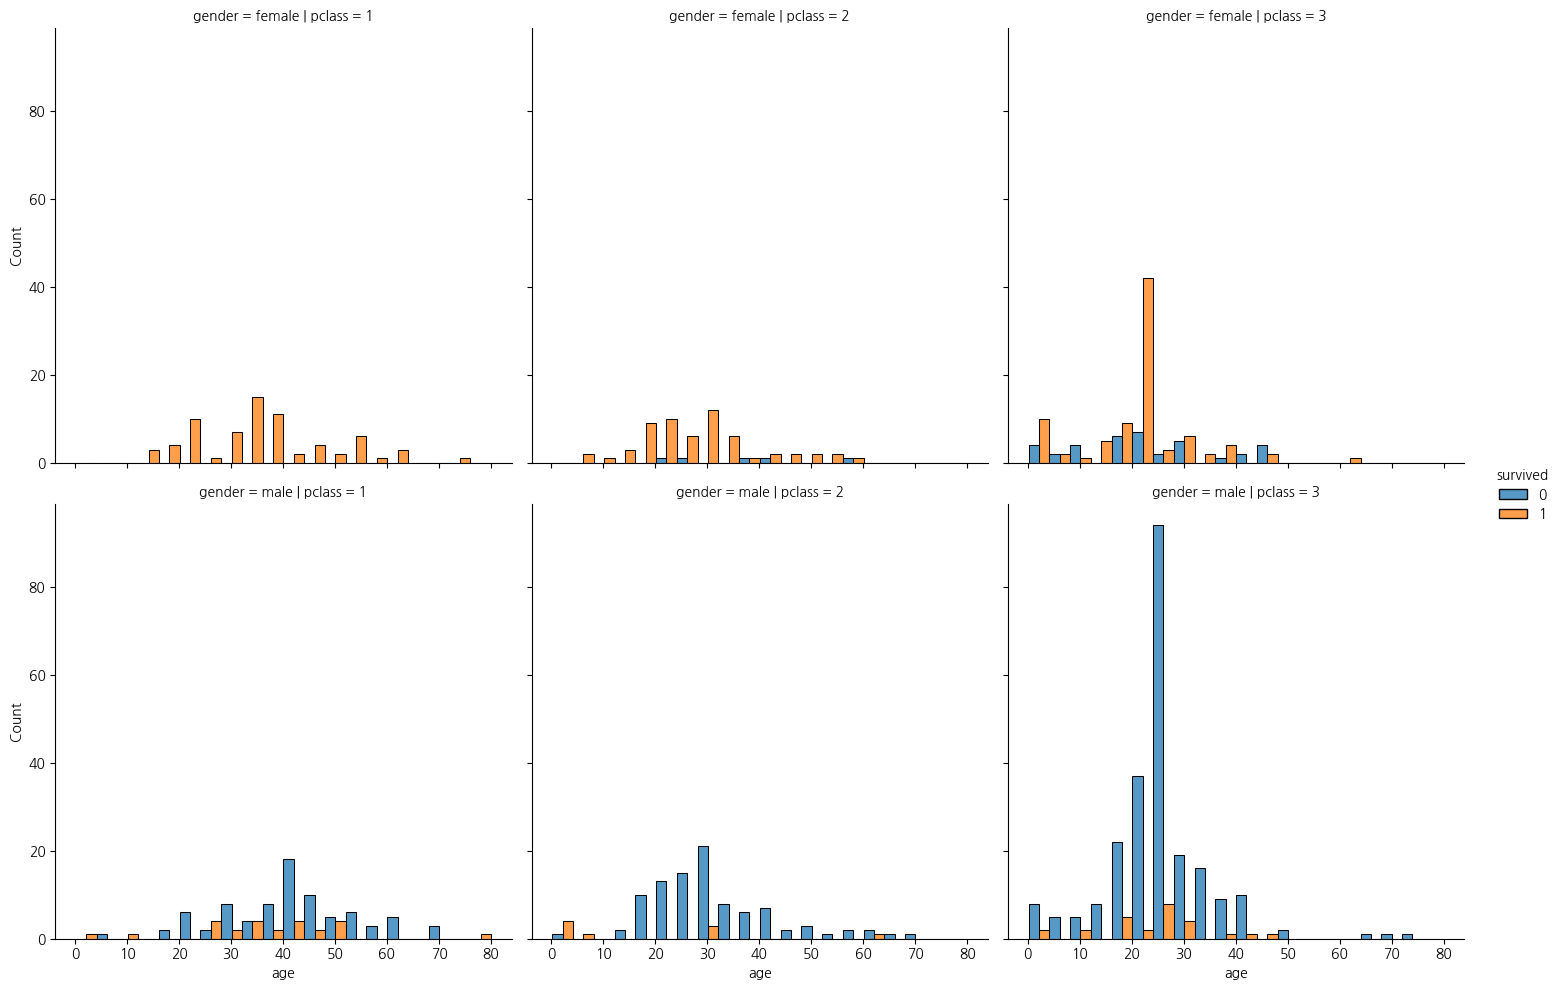

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 12), (184, 12), (393, 11)
컬럼 생성 이후 : (732, 13), (184, 13), (393, 12)


In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass'],
       dtype='object'),
 13)

In [ ]:
train.shape, test.shape, ori_te.shape

((732, 13), (184, 13), (393, 12))

In [ ]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
       'gender_pclass'],
      dtype='object')

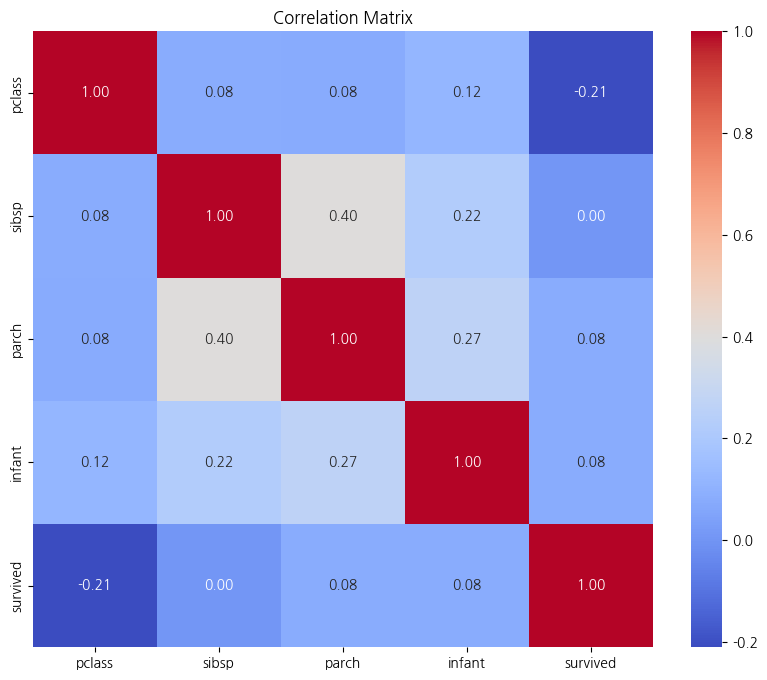

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

컬럼 생성 이전 : (732, 13), (184, 13), (393, 12)
컬럼 생성 이후 : (732, 14), (184, 14), (393, 13)


passengerid  survived  pclass  gender        age  sibsp  parch     fare  \
914          914         1       3  female  21.414891      0      0   7.7333   
805          805         0       3  female   6.000000      4      2  31.2750   
255          255         1       3  female   1.000000      1      1  12.1833   
769          769         0       3    male  70.500000      0      0   7.7500   
527          527         0       3    male  35.000000      0      0   7.1250   

    embarked  has_cabin  infant gender_infant gender_pclass infant_pclass  
914        Q          0       0      female_0      female_3           0_3  
805        S          0       0      female_0      female_3           0_3  
255        S          0       1      female_1      female_3           1_3  
769        Q          0       0        male_0        male_3           0_3  
527        S          0       0        male_0        male_3           0_3

In [ ]:
train.columns, len(train.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass', 'infant_pclass'],
       dtype='object'),
 14)

##### gender & sibsp

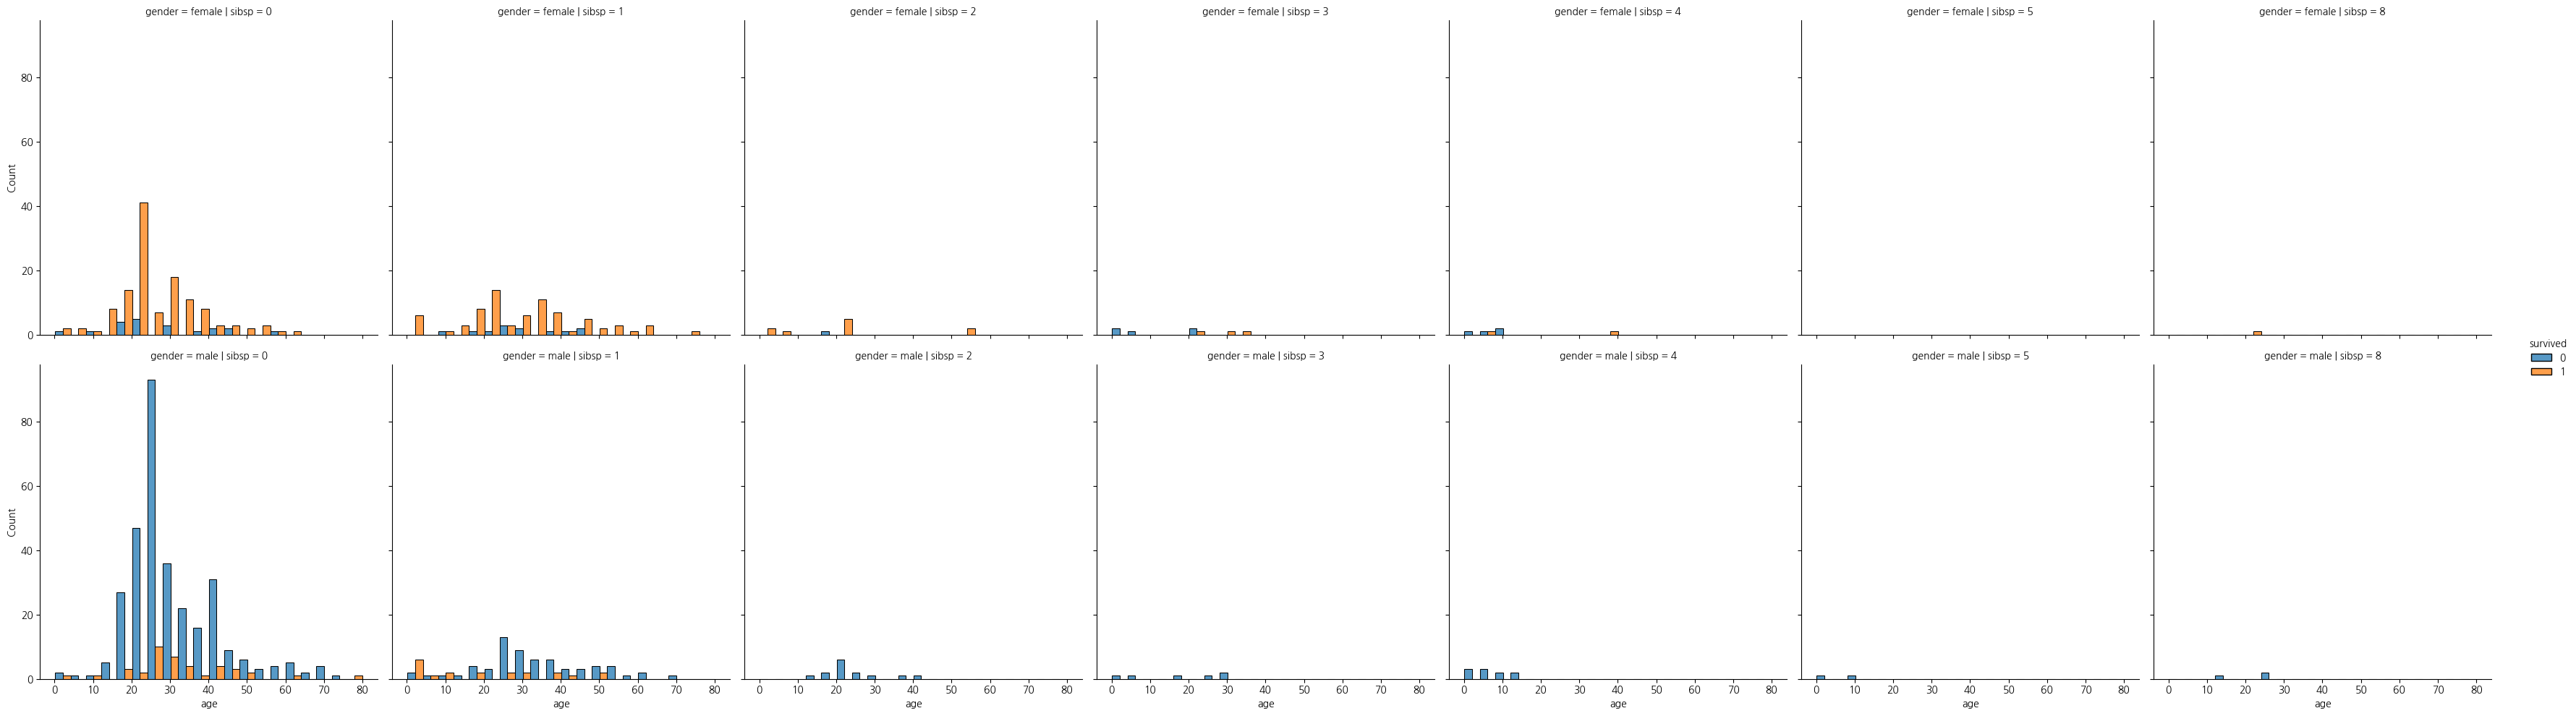

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="sibsp", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")
# 'sibsp' 값이 2 이상이면 '2'로 변환, 그렇지 않으면 그대로 유지
def add_gender_sibsp(gender, sibsp):
  result = None
  try:
    if sibsp < 2:
      result = gender+'_'+str(sibsp)
    else:
      result = gender+'_2'
  except:
    pass
  return result

train['gender_sibsp'] = train.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
test['gender_sibsp'] = test.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)
ori_te['gender_sibsp'] = ori_te.apply(lambda row: add_gender_sibsp(row['gender'], row['sibsp']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")


컬럼 생성 이전 : (732, 14), (184, 14), (393, 13)
컬럼 생성 이후 : (732, 15), (184, 15), (393, 14)


#### gender & parch

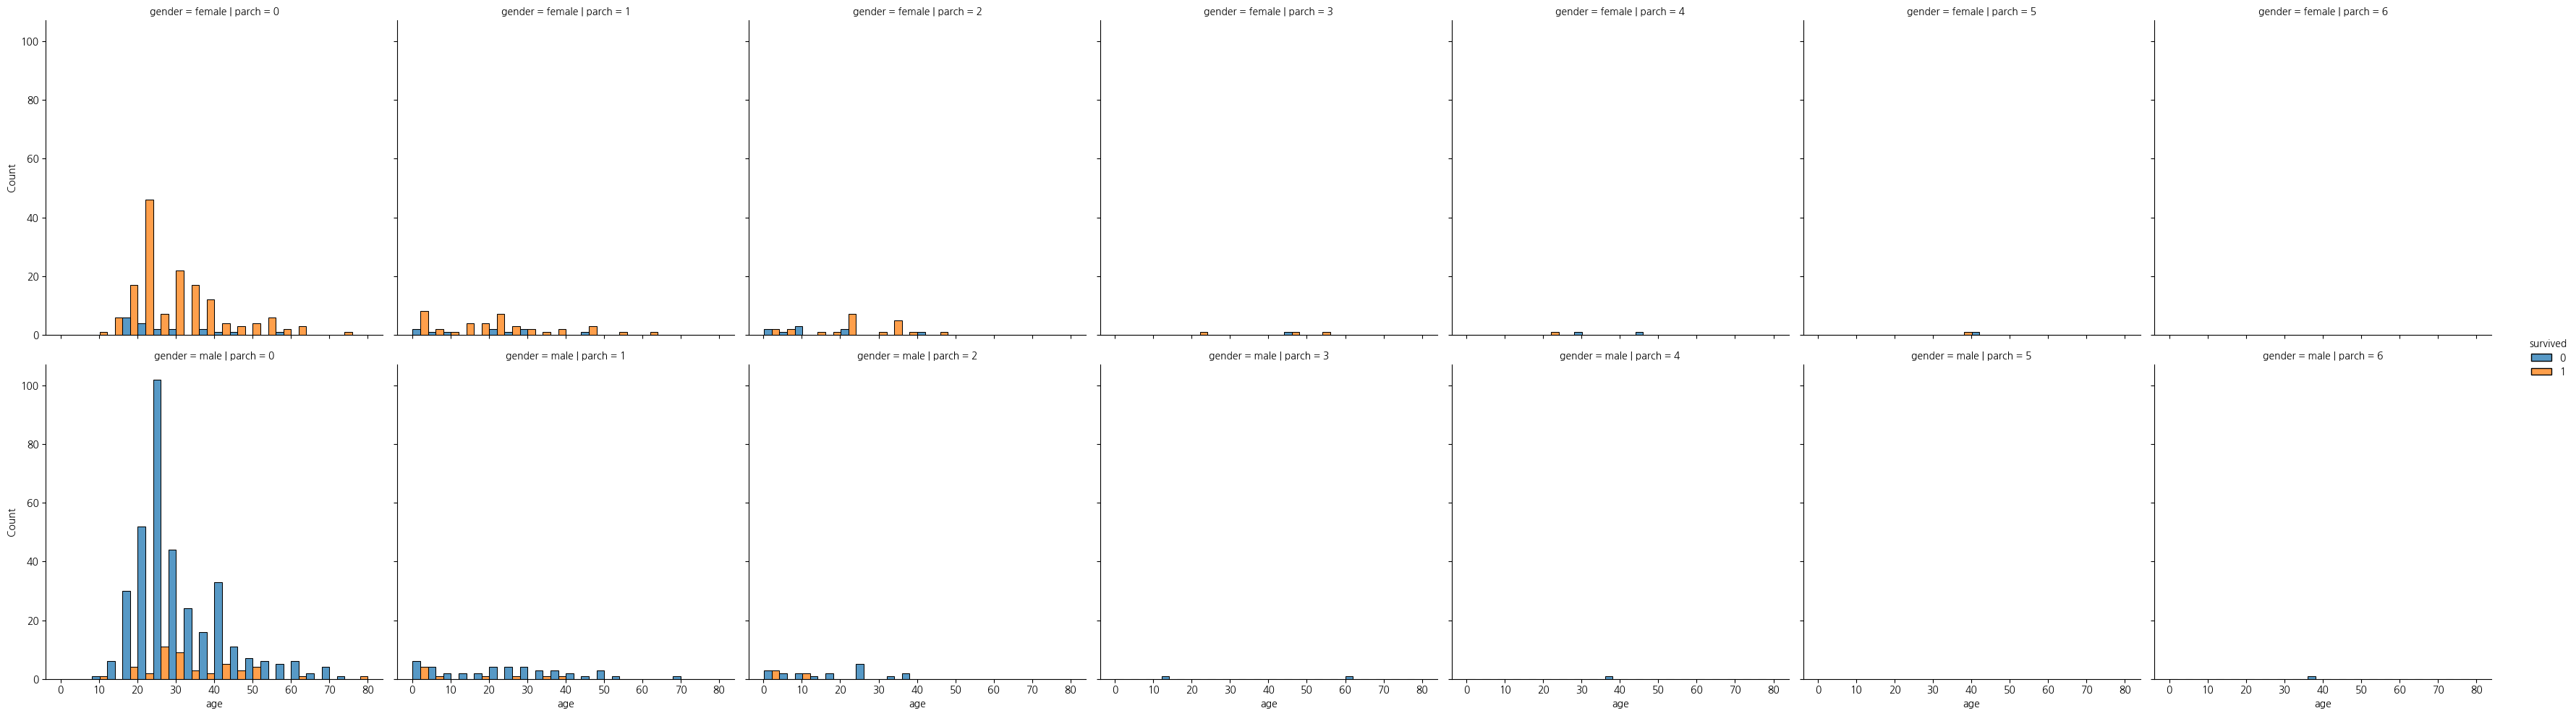

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="parch", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train['gender_parch'] = train.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
test['gender_parch'] = test.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)
ori_te['gender_parch'] = ori_te.apply(lambda row: row['gender']+'_0' if int(row['parch']) == 0 else row['gender']+'_1', axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 15), (184, 15), (393, 14)
컬럼 생성 이후 : (732, 16), (184, 16), (393, 15)


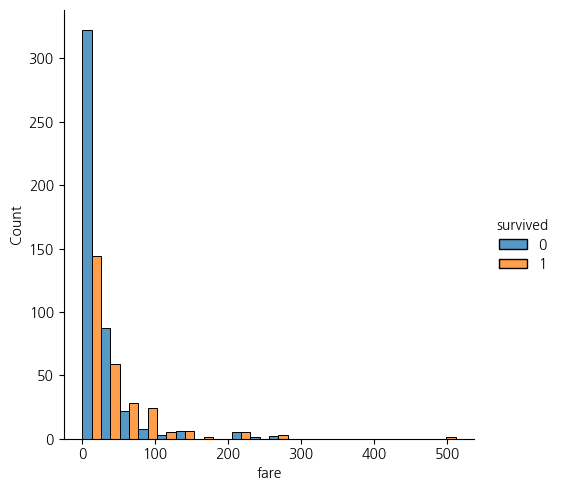

In [ ]:
sns.displot(train, x='fare', hue="survived", multiple="dodge", bins=20)

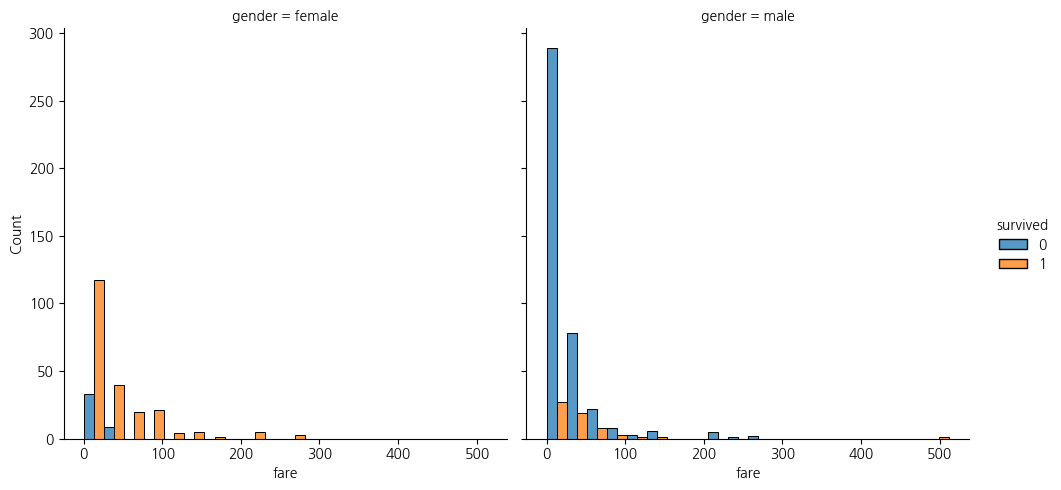

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="gender")

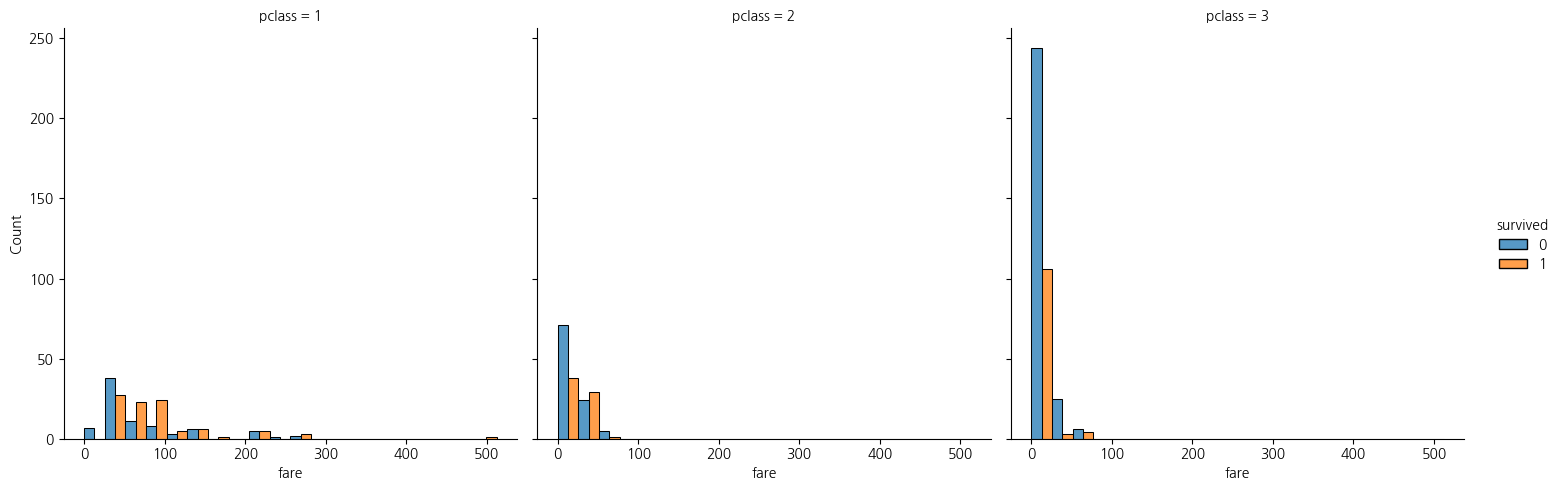

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass")

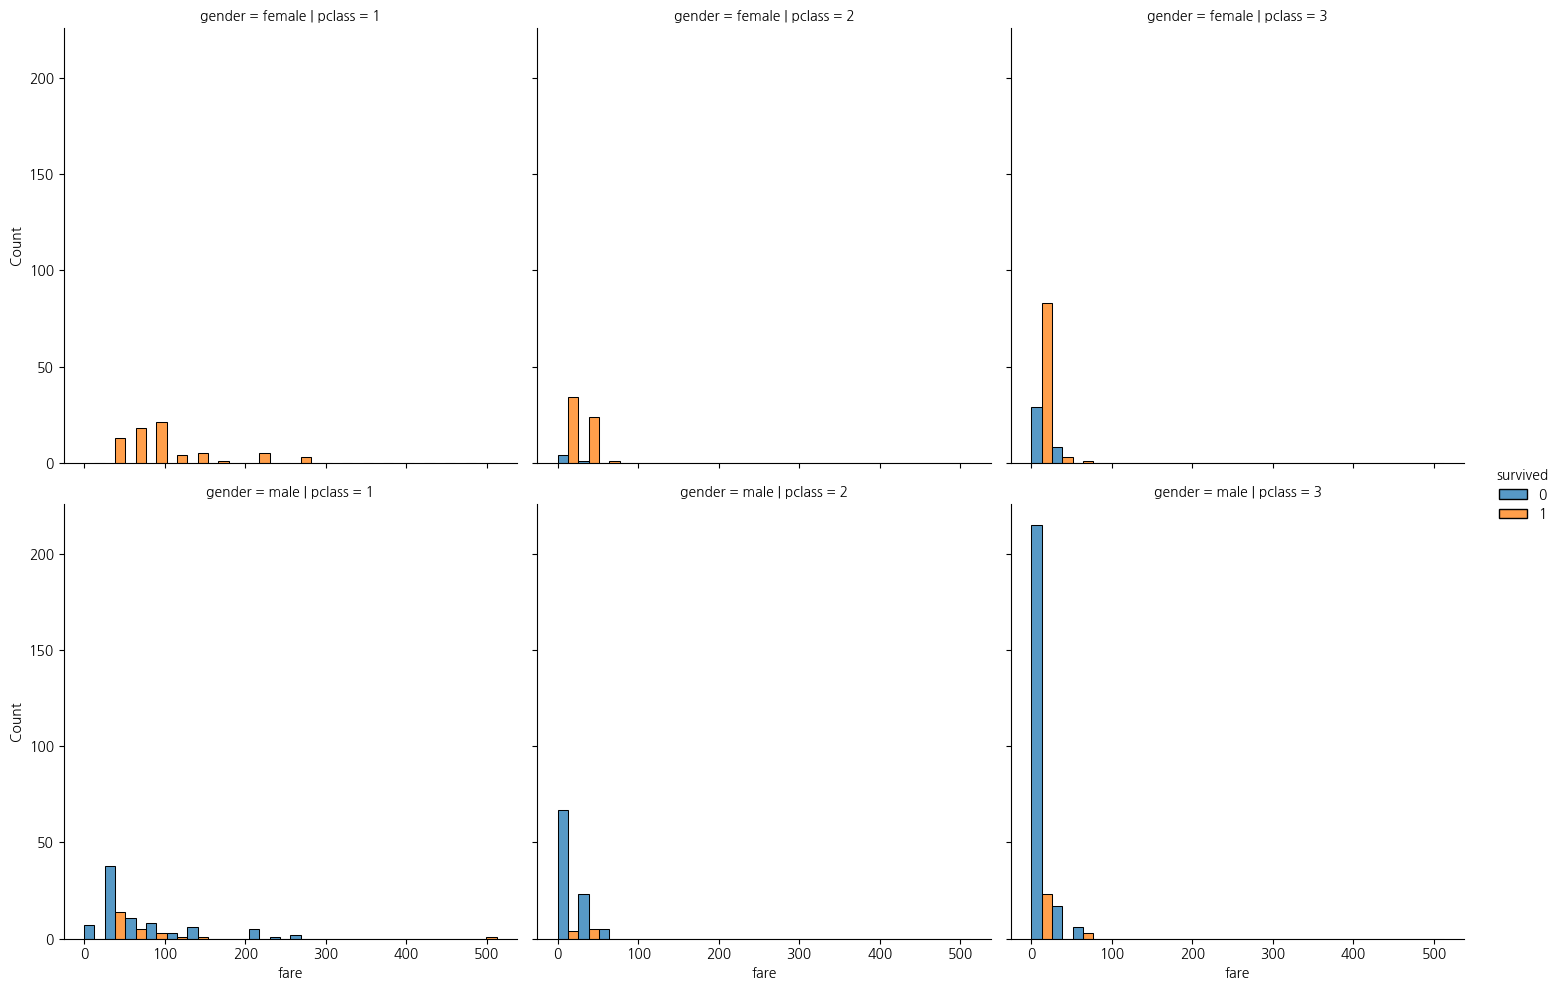

In [ ]:
sns.displot(train, x="fare", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

#### fare_pclass

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 732 entries, 914 to 636
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    732 non-null    int64  
 1   survived       732 non-null    int64  
 2   pclass         732 non-null    int64  
 3   gender         732 non-null    object 
 4   age            732 non-null    float64
 5   sibsp          732 non-null    int64  
 6   parch          732 non-null    int64  
 7   fare           732 non-null    float64
 8   embarked       732 non-null    object 
 9   has_cabin      732 non-null    int64  
 10  infant         732 non-null    int64  
 11  gender_infant  732 non-null    object 
 12  gender_pclass  732 non-null    object 
 13  infant_pclass  732 non-null    object 
 14  gender_sibsp   732 non-null    object 
 15  gender_parch   732 non-null    object 
dtypes: float64(2), int64(7), object(7)
memory usage: 113.4+ KB


In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 객실 등급 대비 요금 비율
train["fare_per_pclass"] = train["fare"] / train["pclass"]
test["fare_per_pclass"] = test["fare"] / test["pclass"]
ori_te["fare_per_pclass"] = ori_te["fare"] / ori_te["pclass"]

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 16), (184, 16), (393, 15)
컬럼 생성 이후 : (732, 17), (184, 17), (393, 16)


#### high_fare

In [ ]:
train.describe()

passengerid    survived      pclass         age       sibsp  \
count   732.000000  732.000000  732.000000  732.000000  732.000000   
mean    459.413934    0.377049    2.289617   29.074743    0.504098   
std     266.621682    0.484979    0.829188   13.367604    1.028318   
min       0.000000    0.000000    1.000000    0.170000    0.000000   
25%     227.750000    0.000000    2.000000   21.414891    0.000000   
50%     461.500000    0.000000    3.000000   26.000000    0.000000   
75%     692.250000    1.000000    3.000000   36.000000    1.000000   
max     915.000000    1.000000    3.000000   80.000000    8.000000   

            parch        fare   has_cabin      infant  fare_per_pclass  
count  732.000000  732.000000  732.000000  732.000000       732.000000  
mean     0.349727   30.732410    0.207650    0.040984        23.581068  
std      0.763810   44.706787    0.405902    0.198388        46.254242  
min      0.000000    0.000000    0.000000    0.000000         0.000000  
25%      0.000000    7.925000    0.000000    0.000000         2.641667  
50%      0.000000   14.458300    0.000000    0.000000         6.500000  
75%      0.000000   29.700000    0.000000    0.000000        18.998950  
max      6.000000  512.329200    1.000000    1.000000       512.329200

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

fare_threshold = train["fare"].quantile(0.75)
train["high_fare"] = (train["fare"] >= fare_threshold).astype(int)
test["high_fare"] = (test["fare"] >= fare_threshold).astype(int)
ori_te["high_fare"] = (ori_te["fare"] >= fare_threshold).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 17), (184, 17), (393, 16)
컬럼 생성 이후 : (732, 18), (184, 18), (393, 17)


#### fare_group

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# fare값을 일정한 범위로 그룹화하여 새로운 범주형 변수 fare_group을 생성
def assign_fare_group(fare):
    if fare < 10:
        return 0
    elif fare < 30:
        return 1
    elif fare < 100:
        return 2
    else:
        return 3

# 요금이 높은 그룹일수록 생존 가능성이 높음
train["fare_group"] = train["fare"].apply(assign_fare_group)
test["fare_group"] = test["fare"].apply(assign_fare_group)
ori_te["fare_group"] = ori_te["fare"].apply(assign_fare_group)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")


컬럼 생성 이전 : (732, 18), (184, 18), (393, 17)
컬럼 생성 이후 : (732, 19), (184, 19), (393, 18)


#### gender & fare

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["gender_fare"] = train["gender"] + "_" + train["fare_group"].astype(str)
test["gender_fare"] = test["gender"] + "_" + test["fare_group"].astype(str)
ori_te["gender_fare"] = ori_te["gender"] + "_" + ori_te["fare_group"].astype(str)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 19), (184, 19), (393, 18)
컬럼 생성 이후 : (732, 20), (184, 20), (393, 19)


#### family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["family_size"] = train["sibsp"] + train["parch"] + 1
test["family_size"] = test["sibsp"] + test["parch"] + 1
ori_te["family_size"] = ori_te["sibsp"] + ori_te["parch"] + 1

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 20), (184, 20), (393, 19)
컬럼 생성 이후 : (732, 21), (184, 21), (393, 20)


#### alone

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

train["is_alone"] = (train["family_size"] == 1).astype(int)
test["is_alone"] = (test["family_size"] == 1).astype(int)
ori_te["is_alone"] = (ori_te["family_size"] == 1).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

컬럼 생성 이전 : (732, 21), (184, 21), (393, 20)
컬럼 생성 이후 : (732, 22), (184, 22), (393, 21)


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

(0, 0, 0)

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

(Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass', 'infant_pclass', 'gender_sibsp', 'gender_parch',
        'fare_per_pclass', 'high_fare', 'fare_group', 'gender_fare',
        'family_size', 'is_alone'],
       dtype='object'),
 22,
 Index(['passengerid', 'survived', 'pclass', 'gender', 'age', 'sibsp', 'parch',
        'fare', 'embarked', 'has_cabin', 'infant', 'gender_infant',
        'gender_pclass', 'infant_pclass', 'gender_sibsp', 'gender_parch',
        'fare_per_pclass', 'high_fare', 'fare_group', 'gender_fare',
        'family_size', 'is_alone'],
       dtype='object'),
 22,
 Index(['passengerid', 'pclass', 'gender', 'age', 'sibsp', 'parch', 'fare',
        'embarked', 'has_cabin', 'infant', 'gender_infant', 'gender_pclass',
        'infant_pclass', 'gender_sibsp', 'gender_parch', 'fare_per_pclass',
        'high_fare', 'fare_group', 'gender_fare', 'family_s

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

train: (732, 22), test: (184, 22), ori_te: (393, 21)


In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass',
                'infant_pclass', 'gender_sibsp', 'gender_parch', 'gender_fare']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'infant',
                'fare_per_pclass', 'high_fare', 'fare_group', 'family_size', 'is_alone']

print(f"범주형 : {len(cat_features)}, 수치형 : {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")


In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = MinMaxScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V1'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 1001, 50)),
#     'max_depth': list(range(5, 31, 3)) + [None],
#     'num_leaves': list(range(20, 150, 10)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V1 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V1, param_distributions=param_dist,
#     n_iter=100, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V0_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V0_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V0_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V5'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 550,
    'min_child_weight': 10,
    'min_child_samples': 15,
    'metric': 'auc',
    'max_depth': 29,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V5 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V5.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V5.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V5.score(X_te_scaled, y_te)

print(f'{model_lgb_V5} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V5.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V5}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V5.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V5.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V5.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V6 (random search 진행) - 0212_6

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Data Cleaning

In [ ]:
# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

train.shape, test.shape, ori_te.shape

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def get_cols_cleaning(p_pd_list: list) -> list:
    """
    주어진 데이터프레임 리스트에서 결측치가 있는 컬럼을 추출하여 반환
    """
    cols_cleaning = []
    for df in p_pd_list:
        tmp = df.isnull().sum()
        cols_cleaning += list(tmp[tmp > 0].index)

    cols_cleaning = list(set(cols_cleaning))
    print(f'결측치 처리 대상 컬럼: {cols_cleaning}')
    return cols_cleaning

def add_cols_cleaning(p_train: pd.DataFrame, p_test: pd.DataFrame, p_ori_te: pd.DataFrame) -> None:
    """
    - 수치형 변수: Train 데이터에서 랜덤 샘플링하여 결측치 대체
    - 범주형 변수: Train 데이터에서 최빈값(mode)으로 결측치 대체
    """
    pd_list = [p_train, p_test, p_ori_te]

    for col in get_cols_cleaning(pd_list):  # 결측치가 있는 컬럼들만 처리
        for df in pd_list:
            if is_numeric_dtype(df[col]):  # 숫자형 결측치 처리
                # Train 데이터에서 결측치가 없는 값들로 랜덤 샘플링
                random_sampling = p_train[col].dropna().sample(df[col].isnull().sum(), replace=True)
                random_sampling.index = df[df[col].isnull()].index  # 인덱스 매칭
                df.loc[df[col].isnull(), col] = random_sampling  # 기존 컬럼에 채우기
            else:  # 범주형 결측치 처리
                df[col].fillna(p_train[col].mode().values[0], inplace=True)

    print(f'결측치 처리 완료: p_train({p_train.isnull().sum().sum()}), '
          f'p_test({p_test.isnull().sum().sum()}), p_ori_te({p_ori_te.isnull().sum().sum()})')


In [ ]:
add_cols_cleaning(train, test, ori_te)

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass', 'infant_pclass']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'infant']

print(f"범주형 : {len(cat_features)}, 수치형 : {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V6'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 2001, 30)),
#     'max_depth': list(range(5, 31, 1)) + [None],
#     'num_leaves': list(range(20, 150, 5)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V6 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V6, param_distributions=param_dist,
#     n_iter=200, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V6_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V6_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V6_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V6'

parameters = {
    'subsample': 0.7,
    'objective': 'binary',
    'num_leaves': 90,
    'n_estimators': 1030,
    'min_child_weight': 0.1,
    'min_child_samples': 30,
    'metric': 'auc',
    'max_depth': 14,
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'boosting_type': 'dart'
}

# LightGBM 모델 초기화
model_lgb_V6 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V6.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V6.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V6.score(X_te_scaled, y_te)

print(f'{model_lgb_V6} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V6.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V6}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V6.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

- 11%: 사망자를 생존자로 잘못 분류
- 19%: 생존자를 사망자로 잘못 분류

In [ ]:
ori_te_pred = model_lgb_V6.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V6.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V7 (random search 진행)
- V6과의 차이점 : 결측치를 처리하는 방법이 다름

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Data Cleaning

In [ ]:
# Cabin 존재 여부를 나타내는 변수 생성
# cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

train.shape, test.shape, ori_te.shape

In [ ]:
# Cabin 결측값을 'unknown'으로 대체
train["cabin"].fillna("unknown", inplace=True)
test["cabin"].fillna("unknown", inplace=True)
ori_te["cabin"].fillna("unknown", inplace=True)

train.shape, test.shape, ori_te.shape

In [ ]:
# 이름에서 호칭(title) 추출
train["title"] = train["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
test["title"] = test["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())
ori_te["title"] = ori_te["name"].apply(lambda x: x.split(",")[1].split(".")[0].strip())

train.shape, test.shape, ori_te.shape

In [ ]:
DICT_INITIAL_NAME = {
    "Mr": "Others",
    "Miss": "Others",
    "Mrs": "Others",
    "Master": "Officer",
    "Dr": "Officer",
    "Rev": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Capt": "Officer",
    "Jonkheer": "Royalty",
    "Countess": "Royalty",
    "Sir": "Royalty",
}

# title을 카테고리로 분류하는 기능
def add_initial_name_type(initial_name):
    result = "Others"
    try:
        result = DICT_INITIAL_NAME[initial_name]
    except:
        pass
    return result

# 이름에서 추출한 호칭(title)을 기반으로 호칭 그룹생성
train["Initial_name_type"] = train["title"].map(lambda x: add_initial_name_type(x))
test["Initial_name_type"] = test["title"].map(lambda x: add_initial_name_type(x))
ori_te["Initial_name_type"] = ori_te["title"].map(lambda x: add_initial_name_type(x))

train.shape, test.shape, ori_te.shape

In [ ]:
# age: title별로 중간값으로 대체
train["age"] = train.groupby("title")["age"].transform(lambda x: x.fillna(x.median()))
test["age"] = test.groupby("title")["age"].transform(lambda x: x.fillna(x.median()))
ori_te["age"] = ori_te.groupby("title")["age"].transform(lambda x: x.fillna(x.median()))

# age: 중간값으로 대체
train["age"].fillna(train["age"].median(), inplace=True)
test["age"].fillna(test["age"].median(), inplace=True)
ori_te["age"].fillna(ori_te["age"].median(), inplace=True)

# fare: 중간값으로 대체
train["fare"].fillna(train["fare"].median(), inplace=True)
test["fare"].fillna(test["fare"].median(), inplace=True)
ori_te["fare"].fillna(ori_te["fare"].median(), inplace=True)

# embarked: 가장 빈번한 값인 's'로 대체
embarked_imputer = SimpleImputer(strategy="most_frequent")
train["embarked"] = embarked_imputer.fit_transform(train[["embarked"]]).ravel()
test["embarked"] = embarked_imputer.fit_transform(test[["embarked"]]).ravel()
ori_te["embarked"] = embarked_imputer.fit_transform(ori_te[["embarked"]]).ravel()

# 'fare' 값이 500이 넘는 경우를 300 이하에서 가장 높은 값으로 변환
max_fare_below_300 = train[train["fare"] <= 300]["fare"].max()
train.loc[train["fare"] > 500, "fare"] = max_fare_below_300
max_fare_below_300 = test[test["fare"] <= 300]["fare"].max()
test.loc[test["fare"] > 500, "fare"] = max_fare_below_300
max_fare_below_300 = ori_te[ori_te["fare"] <= 300]["fare"].max()
ori_te.loc[ori_te["fare"] > 500, "fare"] = max_fare_below_300

train.shape, test.shape, ori_te.shape

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['ticket']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass', 'infant_pclass', 'title',
                'Initial_name_type', 'name', 'cabin']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare', 'has_cabin', 'infant']

print(f"범주형 : {len(cat_features)}, 수치형 : {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V7'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 2001, 30)),
#     'max_depth': list(range(5, 31, 1)) + [None],
#     'num_leaves': list(range(20, 150, 5)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V7 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V7, param_distributions=param_dist,
#     n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V7_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V7_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V7_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V7'

parameters = {
    'subsample': 0.5,
    'objective': 'binary',
    'num_leaves': 30,
    'n_estimators': 1930,
    'min_child_weight': 10,
    'min_child_samples': 25,
    'metric': 'auc',
    'max_depth': 22,
    'learning_rate': 0.01,
    'colsample_bytree': 0.7,
    'boosting_type': 'gbdt'
}

# LightGBM 모델 초기화
model_lgb_V7 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V7.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V7.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V7.score(X_te_scaled, y_te)

print(f'{model_lgb_V7} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V7.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V7}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V7.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

- 11%: 사망자를 생존자로 잘못 분류
- 19%: 생존자를 사망자로 잘못 분류

In [ ]:
ori_te_pred = model_lgb_V7.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V7.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V8 (random search 진행)
- V7과의 차이점 : V6과 같은 결측치 처리, 스케일링X, 인코딩 진행 (label 인코딩)

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Data Cleaning

In [ ]:
# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

train.shape, test.shape, ori_te.shape

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype

def get_cols_cleaning(p_pd_list: list) -> list:
    """
    주어진 데이터프레임 리스트에서 결측치가 있는 컬럼을 추출하여 반환
    """
    cols_cleaning = []
    for df in p_pd_list:
        tmp = df.isnull().sum()
        cols_cleaning += list(tmp[tmp > 0].index)

    cols_cleaning = list(set(cols_cleaning))
    print(f'결측치 처리 대상 컬럼: {cols_cleaning}')
    return cols_cleaning

def add_cols_cleaning(p_train: pd.DataFrame, p_test: pd.DataFrame, p_ori_te: pd.DataFrame) -> None:
    """
    - 수치형 변수: Train 데이터에서 랜덤 샘플링하여 결측치 대체
    - 범주형 변수: Train 데이터에서 최빈값(mode)으로 결측치 대체
    """
    pd_list = [p_train, p_test, p_ori_te]

    for col in get_cols_cleaning(pd_list):  # 결측치가 있는 컬럼들만 처리
        for df in pd_list:
            if is_numeric_dtype(df[col]):  # 숫자형 결측치 처리
                # Train 데이터에서 결측치가 없는 값들로 랜덤 샘플링
                random_sampling = p_train[col].dropna().sample(df[col].isnull().sum(), replace=True)
                random_sampling.index = df[df[col].isnull()].index  # 인덱스 매칭
                df.loc[df[col].isnull(), col] = random_sampling  # 기존 컬럼에 채우기
            else:  # 범주형 결측치 처리
                df[col].fillna(p_train[col].mode().values[0], inplace=True)

    print(f'결측치 처리 완료: p_train({p_train.isnull().sum().sum()}), '
          f'p_test({p_test.isnull().sum().sum()}), p_ori_te({p_ori_te.isnull().sum().sum()})')


In [ ]:
add_cols_cleaning(train, test, ori_te)

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = ['age', 'fare', 'pclass', 'sibsp', 'parch'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling (여기서는 X) & Encoding (label)

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'gender_infant', 'gender_pclass', 'infant_pclass', 'has_cabin', 'infant']

# 수치형 변수
num_features = ['age', 'sibsp', 'parch', 'fare']

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

# 포함되지 않은 컬럼 확인
excluded_features = set(train.columns) - set(cat_features) - set(num_features)

print(f"포함되지 않은 컬럼들: {excluded_features}")


In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype(str)

train.info()

In [ ]:
for col in cat_features:
    le = LabelEncoder()

    combined_data = pd.concat([train[col], test[col], ori_te[col]], axis=0, ignore_index=True)
    le.fit(combined_data)

    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    ori_te[col] = le.transform(ori_te[col])

train.shape, test.shape, ori_te.shape

## Training

In [ ]:
train.columns

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V8'

# # 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
# param_dist = {
#     'n_estimators': list(range(400, 2001, 20)),
#     'max_depth': list(range(5, 31, 1)) + [None],
#     'num_leaves': list(range(20, 150, 5)),
#     'min_child_samples': list(range(5, 31, 5)),
#     'min_child_weight': [1e-3, 1e-2, 1e-1, 1, 10],
#     'subsample': [0.5, 0.7, 0.9, 1.0],
#     'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'boosting_type': ['gbdt', 'dart'],
#     'objective': ['binary'],
#     'metric': ['auc']
# }

# # LightGBM 모델 초기화
# model_lgb_V8 = lgb.LGBMClassifier(random_state=args.random_seed)

# # 랜덤 서치 실행
# random_search = RandomizedSearchCV(
#     estimator=model_lgb_V8, param_distributions=param_dist,
#     n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
# )

# random_search.fit(X_tr, y_tr)

In [ ]:
# # 최적의 하이퍼파라미터 출력
# parameters = random_search.best_params_
# print("Best parameters found: ", parameters)

In [ ]:
# reset_seeds()

# # 최적의 파라미터로 새로운 LightGBM 모델 생성
# model_lgb_V8_best = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
# print(f'{model_lgb_V8_best} : {X_tr.shape} / {y_tr.shape}')

# # 모델 학습
# model_lgb_V8_best.fit(X_tr, y_tr)

In [ ]:
reset_seeds()
model_name = 'model_lgb_V8'

parameters = {
    'boosting_type' : 'dart',
    'colsample_bytree' : 0.7,
    'learning_rate' : 0.01,
    'max_depth' : 14,
    'metric' : 'auc',
    'min_child_samples' : 30,
    'min_child_weight' : 0.1,
    'n_estimators' : 1030,
    'num_leaves' : 90,
    'objective' : 'binary',
    'subsample' : 0.7
}

# LightGBM 모델 초기화
model_lgb_V8 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

model_lgb_V8.fit(X_tr, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V8.score(X_tr, y_tr)
# - Test data
score_te_lgb = model_lgb_V8.score(X_te, y_te)

print(f'{model_lgb_V8} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V8.predict_proba(X_te)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V8}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V8.predict(X_te)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

- 11%: 사망자를 생존자로 잘못 분류
- 19%: 생존자를 사망자로 잘못 분류

In [ ]:
ori_te_pred = model_lgb_V8.predict_proba(ori_te)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V8.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V9 (random search 진행)
- V2에서 랜덤서치를 진행 (범위를 넓혀서)
- encoding X
- StandardScaler O

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Feature Extraction

#### pclass별 평균 나이

In [ ]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### embarked별 평균 나이

In [ ]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### pclass별 평균 요금

In [ ]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### embarked별 평균 요금

In [ ]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### 동승한 가족 인원수 컬럼 추가

In [ ]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

In [ ]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [ ]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [ ]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

In [ ]:
test.isnull().sum().sort_values(ascending=False)

In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### infant & family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


##### pclass & is_alone

In [ ]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


##### pclass_family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
# 범주형 변수
cat_features = ['pclass', 'gender', 'embarked', 'is_alone', 'has_cabin',
                'infant', 'gender_infant', 'gender_pclass', 'infant_pclass',
                'infant_family_size', 'pclass_is_alone', 'pclass_family_size']

# 수치형 변수만
num_features = ['age', 'sibsp', 'parch', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
                'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size']
len(cat_features), len(num_features)

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
reset_seeds()
model_name = 'model_lgb_V9'

# 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
param_dist = {
    'n_estimators': list(range(500, 701, 50)),  # 최적값 600 기준 ±100 범위
    'max_depth': list(range(20, 27, 1)) + [None],  # 최적값 23 기준 ±3 범위
    'num_leaves': list(range(100, 141, 10)),  # 최적값 120 기준 ±20 범위
    'min_child_samples': list(range(20, 41, 5)),  # 최적값 30 기준 ±10 범위
    'min_child_weight': [0.1, 0.5, 1, 5, 10],  # 최적값 1 포함, 주변값 추가
    'subsample': [0.8, 0.9, 1.0],  # 최적값 1.0 기준
    'colsample_bytree': [0.4, 0.5, 0.6],  # 최적값 0.5 기준 ±0.1
    'learning_rate': [0.005, 0.01, 0.02],  # 최적값 0.01 기준 ±0.01 범위
    'boosting_type': ['dart'],  # 최적값 dart 고정
    'objective': ['binary'],  # 최적값 binary 고정
    'metric': ['auc']  # 최적값 auc 고정
}


# LightGBM 모델 초기화
model_lgb_V9 = lgb.LGBMClassifier(random_state=args.random_seed)

# 랜덤 서치 실행
random_search = RandomizedSearchCV(
    estimator=model_lgb_V9, param_distributions=param_dist,
    n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
)

random_search.fit(X_tr_scaled, y_tr)

In [ ]:
# 최적의 하이퍼파라미터 출력
parameters = random_search.best_params_
print("Best parameters found: ", parameters)

In [ ]:
reset_seeds()

# 최적의 파라미터로 새로운 LightGBM 모델 생성
model_lgb_V9 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
print(f'{model_lgb_V9} : {X_tr_scaled.shape} / {y_tr.shape}')

# 모델 학습
model_lgb_V9.fit(X_tr_scaled, y_tr)

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V2'

# parameters = {
#     'subsample': 0.5,
#     'objective': 'binary',
#     'num_leaves': 30,
#     'n_estimators': 550,
#     'min_child_weight': 10,
#     'min_child_samples': 15,
#     'metric': 'auc',
#     'max_depth': 29,
#     'learning_rate': 0.01,
#     'colsample_bytree': 0.5,
#     'boosting_type': 'dart'
# }

# # LightGBM 모델 초기화
# model_lgb_V2 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# model_lgb_V2.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V9.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V9.score(X_te_scaled, y_te)

print(f'{model_lgb_V9} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V9.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V9}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V9.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V9.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V9.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# model_lgbm_V10 (random search 진행)
- V9와의 차이 : 범주형 컬럼들이 무엇인지 명시하고, 훈련때 알려주기
- encoding X
- StandardScaler O

## Train & Test Split

In [ ]:
ori_train.head()

In [ ]:
ori_tr = ori_train.copy()
ori_te = ori_test.copy()

ori_tr.shape, ori_te.shape

In [ ]:
reset_seeds()
train, test = train_test_split(ori_tr, test_size=0.2, stratify=ori_tr['survived'], random_state=args.random_seed)

train.shape, test.shape

## Data Preprocessing

In [ ]:
train.shape, test.shape, ori_te.shape

In [ ]:
train.columns

In [ ]:
ori_te.columns

### Feature Extraction

#### pclass별 평균 나이

In [ ]:
# pclass별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_pclass'] = train.groupby('pclass')['age'].transform('mean')
test['avg_age_by_pclass'] = test.groupby('pclass')['age'].transform('mean')
ori_te['avg_age_by_pclass'] = ori_te.groupby('pclass')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### embarked별 평균 나이

In [ ]:
# embarked별 평균 나이를 계산하여 새로운 컬럼 추가
train['avg_age_by_embarked'] = train.groupby('embarked')['age'].transform('mean')
test['avg_age_by_embarked'] = test.groupby('embarked')['age'].transform('mean')
ori_te['avg_age_by_embarked'] = ori_te.groupby('embarked')['age'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### pclass별 평균 요금

In [ ]:
# pclass별 평균 요금을 계산하여 새로운 컬럼 추가
train['avg_fare_by_pclass'] = train.groupby('pclass')['fare'].transform('mean')
test['avg_fare_by_pclass'] = test.groupby('pclass')['fare'].transform('mean')
ori_te['avg_fare_by_pclass'] = ori_te.groupby('pclass')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### embarked별 평균 요금

In [ ]:
train['avg_fare_by_embarked'] = train.groupby('embarked')['fare'].transform('mean')
test['avg_fare_by_embarked'] = test.groupby('embarked')['fare'].transform('mean')
ori_te['avg_fare_by_embarked'] = ori_te.groupby('embarked')['fare'].transform('mean')

print(train.shape, test.shape, ori_te.shape)
train.head()

#### 동승한 가족 인원수 컬럼 추가

In [ ]:
# sibsp : 동승한 형제/배우자의 수, parch: 동승한 부모/자녀의 수.
train['family_size'] = train['sibsp'] + train['parch'] + 1
test['family_size'] = test['sibsp'] + test['parch'] + 1
ori_te['family_size'] = ori_te['sibsp'] + ori_te['parch'] + 1

print(train.shape, test.shape, ori_te.shape)
train.head()

In [ ]:
sns.barplot(data=train, x='family_size', y='survived')
plt.title('동승한 가족 인원 수별 생존률')
plt.show()

#### 가족 인원 수를 기준으로 그룹화

In [ ]:
train['is_alone'] = (train['family_size'] == 1).astype(int)
test['is_alone'] = (test['family_size'] == 1).astype(int)
ori_te['is_alone'] = (ori_te['family_size'] == 1).astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

#### cabin 컬럼의 값이 있으면 1, 없으면 0

In [ ]:
# Cabin 존재 여부를 나타내는 컬럼
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

print(train.shape, test.shape, ori_te.shape)
train.head()

### Data Cleaning

In [ ]:
train.isnull().sum().sort_values(ascending=False)

In [ ]:
test.isnull().sum().sort_values(ascending=False)

In [ ]:
ori_te.isnull().sum().sort_values(ascending=False)

In [ ]:
# pclass와 gender로 그룹화하여 그룹별 평균값으로 결측치 대체
age_mean = train.groupby(['pclass', 'gender'])['age'].transform(lambda x: x.fillna(x.mean()))
age_overall_mean = train['age'].mean()
fare_mean = train.groupby(['pclass', 'gender'])['fare'].transform(lambda x: x.fillna(x.mean()))
fare_overall_mean = train['fare'].mean()

# embarked와 cabin에 대해 mode()를 사용하는 이유는 두 열이 범주형 데이터이기 때문
embarked_mode = train['embarked'].mode().values[0]

age_mean, fare_mean, embarked_mode

In [ ]:
# train과 test, ori_te 데이터마다 그룹화 결과가 달라서 결측치가 완전히 없어지지 않는 것으로 생각해서
# 그 경우에는 그냥 train 데이터의 전체 평균으로 대체
train['age'].fillna(age_mean, inplace=True)
train['age'].fillna(age_overall_mean, inplace=True)
test['age'].fillna(age_mean, inplace=True)
test['age'].fillna(age_overall_mean, inplace=True)
ori_te['age'].fillna(age_mean, inplace=True)
ori_te['age'].fillna(age_overall_mean, inplace=True)

train['fare'].fillna(fare_mean, inplace=True)
train['fare'].fillna(fare_overall_mean, inplace=True)
test['fare'].fillna(fare_mean, inplace=True)
test['fare'].fillna(fare_overall_mean, inplace=True)
ori_te['fare'].fillna(fare_mean, inplace=True)
ori_te['fare'].fillna(fare_overall_mean, inplace=True)

# 'avg_fare_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'fare' 컬럼의 평균으로 결측치 대체
train['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
test['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)
ori_te['avg_fare_by_embarked'].fillna(fare_overall_mean, inplace=True)

# 'avg_age_by_embarked' 컬럼의 결측치도 embarked의 결측치로 인해 발생한 것으로 보임
# 전체 'age' 컬럼의 평균으로 결측치 대체
train['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
test['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)
ori_te['avg_age_by_embarked'].fillna(age_overall_mean, inplace=True)

train['embarked'].fillna(embarked_mode, inplace=True)
test['embarked'].fillna(embarked_mode, inplace=True)
ori_te['embarked'].fillna(embarked_mode, inplace=True)

# cabin의 경우 사용하지 않을 것이고, cabin 컬럼의 값이 있으면 1 없으면 0이라는 데이터가 들어가는 컬럼을 추가
# Cabin 존재 여부를 나타내는 변수 생성
train['has_cabin'] = train['cabin'].notnull().astype(int)
test['has_cabin'] = test['cabin'].notnull().astype(int)
ori_te['has_cabin'] = ori_te['cabin'].notnull().astype(int)

In [ ]:
print(f'before: {train.shape} / {test.shape}')
drop_cols = ['name', 'ticket', 'cabin']

train.drop(drop_cols, axis=1, inplace=True) # 모델이 학습하는데 사용하는 데이터
test.drop(drop_cols, axis=1, inplace=True) # 모델의 학습을 평가(잘했는지?? 못했는지??)하기 위한 데이터
ori_te.drop(drop_cols, axis=1, inplace=True) # 학습이 잘된 모델을 이용해서 내가 알고 싶은(ori_te) 데이터를 예측하게 하는 것

print(f'after: {train.shape} / {test.shape}')
train.info()

In [ ]:
# 컬럼 삭제 이후에 결측치 있는지 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### EDA

In [ ]:
train.info()

#### numeric features (수치형 데이터) 중 continuous (연속형)


In [ ]:
train.columns

In [ ]:
# 수치형 데이터 중 연속형 컬럼 리스트
numeric_cols = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked', 'avg_fare_by_pclass', 'avg_fare_by_embarked',
    'pclass', 'sibsp', 'parch', 'family_size'] + ['survived']

# 상관관계 분석
corr_matrix = train[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### age <= 5

In [ ]:
sns.displot(train, x='age', hue="survived", multiple="dodge", bins=20)

In [ ]:
c1 = train['age'] <= 5
train.loc[c1]['survived'].mean()

In [ ]:
c1 = train['age'] <= 10
c2 = train['age'] > 5
c = c1 &c2
train.loc[c]['survived'].mean()

In [ ]:
c1 = train['age'] > 5
train.loc[c1]['survived'].mean()

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="gender")

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'infant' 컬럼 생성 : age가 5 미만이면 1, 그렇지 않으면 0
train['infant'] = (train['age'] < 5).astype(int)
test['infant'] = (test['age'] < 5).astype(int)
ori_te['infant'] = (ori_te['age'] < 5).astype(int)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
sns.displot(train, x="infant", hue="survived", multiple="dodge", bins=20, col="gender")

##### gender & infant

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_infant' 컬럼 생성 / male_1: 남성이며 어린이, female_0: 여성이며 어린이 아님.
train['gender_infant'] = train.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
test['gender_infant'] = test.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)
ori_te['gender_infant'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['infant']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### pclass & gender

In [ ]:
sns.displot(train, x="age", hue="survived", multiple="dodge", bins=20, col="pclass", row='gender')

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# 'gender_pclass' 컬럼 생성 / male_1: 남성이며 객실 등급은 1, female_2: 여성이며 객실 등급은 2.
train['gender_pclass'] = train.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
test['gender_pclass'] = test.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)
ori_te['gender_pclass'] = ori_te.apply(lambda row: row['gender']+'_'+str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")

In [ ]:
train.columns, len(train.columns)

In [ ]:
train.shape, test.shape, ori_te.shape

#### numeric features (수치형 데이터) 중 ordinal (서열형)

In [ ]:
train.columns

In [ ]:
ordinal_cols = ['pclass', 'sibsp', 'parch', 'family_size', 'is_alone', 'infant'] + ['survived']

# 상관관계 분석
corr_matrix = train[ordinal_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

##### infant & pclass

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_pclass 컬럼 생성: 어린이 여부와 객실 등급 결합
train['infant_pclass'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
test['infant_pclass'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)
ori_te['infant_pclass'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['pclass']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()

##### infant & family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# infant_family_size 컬럼 생성: 어린이 여부와 가족 크기 결합
train['infant_family_size'] = train.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
test['infant_family_size'] = test.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)
ori_te['infant_family_size'] = ori_te.apply(lambda row: str(row['infant']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


##### pclass & is_alone

In [ ]:

print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_is_alone 컬럼 생성: 객실 등급과 단독 탑승 여부 결합
train['pclass_is_alone'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
test['pclass_is_alone'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)
ori_te['pclass_is_alone'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['is_alone']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


##### pclass_family_size

In [ ]:
print(f"컬럼 생성 이전 : {train.shape}, {test.shape}, {ori_te.shape}")

# pclass_family_size 컬럼 생성: 객실 등급과 가족 크기 결합
train['pclass_family_size'] = train.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
test['pclass_family_size'] = test.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)
ori_te['pclass_family_size'] = ori_te.apply(lambda row: str(row['pclass']) + '_' + str(row['family_size']), axis=1)

print(f"컬럼 생성 이후 : {train.shape}, {test.shape}, {ori_te.shape}")
train.head()


In [ ]:
# 컬럼들을 이것저것 추가했기 때문에 결측치를 한번 더 확인
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

### Scaling

In [ ]:
train.columns, len(train.columns), test.columns, len(test.columns), ori_te.columns, len(ori_te.columns)

In [ ]:
print(f"train: {train.shape}, test: {test.shape}, ori_te: {ori_te.shape}")

In [ ]:
train.info()

In [ ]:
print(f"{len(train.columns)}, {len(test.columns)}, {len(ori_te.columns)}")

# 범주형
cat_features = [
    'pclass', 'gender', 'embarked', 'sibsp', 'parch', 'has_cabin', 'infant',
    'is_alone', 'gender_infant', 'gender_pclass', 'infant_pclass',
    'infant_family_size', 'pclass_is_alone', 'pclass_family_size'
]

# 수치형
num_features = [
    'age', 'fare', 'avg_age_by_pclass', 'avg_age_by_embarked',
    'avg_fare_by_pclass', 'avg_fare_by_embarked', 'family_size'
]

print(f"범주형 변수 개수: {len(cat_features)}, 수치형 변수 개수: {len(num_features)}")

excluded_features = set(train.columns) - set(cat_features) - set(num_features)
print(f"포함되지 않은 컬럼들: {excluded_features}")

In [ ]:
for df in [train, test, ori_te]:
    df[cat_features] = df[cat_features].astype('category')

train.info()

In [ ]:
y_tr = train['survived']
X_tr = train.drop(['survived'], axis=1)

y_te = test['survived']
X_te = test.drop(['survived'], axis=1)

X_tr.shape, y_tr.shape, X_te.shape, y_te.shape, ori_te.shape

In [ ]:
print(f"before: {X_tr.shape}, {X_te.shape}, {ori_te.shape}")

scaler = StandardScaler()

X_tr_scaled = X_tr.copy()
X_te_scaled = X_te.copy()
ori_te_scaled = ori_te.copy()

X_tr_scaled[num_features] = scaler.fit_transform(X_tr[num_features])
X_te_scaled[num_features] = scaler.transform(X_te[num_features])
ori_te_scaled[num_features] = scaler.transform(ori_te[num_features])

print(f"after: {X_tr_scaled.shape}, {X_te_scaled.shape}, {ori_te_scaled.shape}")

## Training

In [ ]:
train.isnull().sum().sum(), test.isnull().sum().sum(), ori_te.isnull().sum().sum()

In [ ]:
reset_seeds()
model_name = 'model_lgb_V10'

# 랜덤 서치를 위한 하이퍼파라미터 그리드 정의
param_dist = {
    'n_estimators': list(range(500, 701, 50)),  # 최적값 600 기준 ±100 범위
    'max_depth': list(range(20, 27, 1)) + [None],  # 최적값 23 기준 ±3 범위
    'num_leaves': list(range(100, 141, 10)),  # 최적값 120 기준 ±20 범위
    'min_child_samples': list(range(20, 41, 5)),  # 최적값 30 기준 ±10 범위
    'min_child_weight': [0.1, 0.5, 1, 5, 10],  # 최적값 1 포함, 주변값 추가
    'subsample': [0.8, 0.9, 1.0],  # 최적값 1.0 기준
    'colsample_bytree': [0.4, 0.5, 0.6],  # 최적값 0.5 기준 ±0.1
    'learning_rate': [0.005, 0.01, 0.02],  # 최적값 0.01 기준 ±0.01 범위
    'boosting_type': ['dart'],  # 최적값 dart 고정
    'objective': ['binary'],  # 최적값 binary 고정
    'metric': ['auc']  # 최적값 auc 고정
}


# LightGBM 모델 초기화
model_lgb_V10 = lgb.LGBMClassifier(random_state=args.random_seed)

# 랜덤 서치 실행
random_search = RandomizedSearchCV(
    estimator=model_lgb_V10, param_distributions=param_dist,
    n_iter=300, cv=10, scoring='roc_auc', random_state=args.random_seed, n_jobs=-1, verbose=2
)

random_search.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
# 최적의 하이퍼파라미터 출력
parameters = random_search.best_params_
print("Best parameters found: ", parameters)

In [ ]:
reset_seeds()

# 최적의 파라미터로 새로운 LightGBM 모델 생성
model_lgb_V10 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)
print(f'{model_lgb_V10} : {X_tr_scaled.shape} / {y_tr.shape}')

# 모델 학습
model_lgb_V10.fit(X_tr_scaled, y_tr, categorical_feature=cat_features)

In [ ]:
# reset_seeds()
# model_name = 'model_lgb_V2'

# parameters = {
#     'subsample': 0.5,
#     'objective': 'binary',
#     'num_leaves': 30,
#     'n_estimators': 550,
#     'min_child_weight': 10,
#     'min_child_samples': 15,
#     'metric': 'auc',
#     'max_depth': 29,
#     'learning_rate': 0.01,
#     'colsample_bytree': 0.5,
#     'boosting_type': 'dart'
# }

# # LightGBM 모델 초기화
# model_lgb_V2 = lgb.LGBMClassifier(**parameters, random_state=args.random_seed)

# model_lgb_V2.fit(X_tr_scaled, y_tr)

## Evaluation (평가)

In [ ]:
reset_seeds()

# Light GBM 모델
# - Train data
score_tr_lgb = model_lgb_V10.score(X_tr_scaled, y_tr)
# - Test data
score_te_lgb = model_lgb_V10.score(X_te_scaled, y_te)

print(f'{model_lgb_V10} : {score_tr_lgb}, {score_te_lgb}')

### AUC 점수

In [ ]:
y_pred = model_lgb_V10.predict_proba(X_te_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_te, y_pred)

auc_te = auc(fpr, tpr)
print(f'{model_lgb_V10}: {auc_te}')

### 혼동행렬

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 모델을 사용해 예측
y_pred_class = model_lgb_V10.predict(X_te_scaled)

# 혼동행렬 계산
norm_conf_mx = confusion_matrix(y_te, y_pred_class, normalize="true")

# 혼동행렬 시각화
plt.figure(figsize=(7, 5))
sns.heatmap(norm_conf_mx, annot=True, cmap="coolwarm", linewidth=0.5, fmt=".2f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Normalized)')
plt.show()

In [ ]:
ori_te_pred = model_lgb_V10.predict_proba(ori_te_scaled)[:,1]
ori_te_pred.shape

### 특성 중요도

In [ ]:
df_feature_importances = pd.DataFrame(model_lgb_V10.feature_importances_, X_tr_scaled.columns).sort_values(by=[0], ascending=False).reset_index()

print(f'{df_feature_importances.shape}')
df_feature_importances.head(20)

### 결과 정리

In [ ]:
# 현재 한국 시간 가져오기
now_kst = datetime.now(kst)

args.results.append(
    {
        'model': model_name,
        'parameters' : parameters,
        'score_tr': score_tr_lgb,
        'score_te': score_te_lgb,
        'auc_te': auc_te,
        'ori_te_pred': ori_te_pred,
        'len_features': X_tr.shape[1],
        'feaute_importances': list(df_feature_importances['index'].values[:X_tr.shape[1]]),
        'create_dt': str(now_kst.strftime("%Y-%m-%d %H:%M:%S"))
    }
)

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

# Submission

In [ ]:
default_submission = pd.read_csv(args.default_submission)
default_submission.head()

In [ ]:
# Public과 Private 점수 차이를 줄이면서도 가장 일반화 성능이 좋은 모델을 선택
df_results = pd.DataFrame(args.results).assign(
    score_diff=lambda df: abs(df['score_tr'] - df['score_te']),  # Train-Test 차이 계산
    auc_diff=lambda df: abs(df['score_te'] - df['auc_te']),  # Test-AUC 차이 계산
    total_diff=lambda df: abs(df['score_tr'] - df['score_te']) + abs(df['score_te'] - df['auc_te'])  # 전체 차이
).sort_values(by=['total_diff', 'auc_te'], ascending=[True, False])

df_results

In [ ]:
default_submission['survived'] = df_results.iloc[0]['ori_te_pred']

# 결측값 확인 및 결과 출력
print(f'{default_submission.isnull().sum().sum()}')
default_submission.head(10)

In [ ]:
default_submission.to_csv(args.submission_csv, header=True, index=False)

In [ ]:
# 방금 제출한 csv 파일의 파일명 출력
submission_filename = os.path.basename(args.submission_csv)
print(submission_filename)